In [3]:
#lgbt-military-equaldex.csv 파일 필요
# 필요한 라이브러리 설치 (Colab에 없을 경우에만 실행)
!pip install pandas wbgapi

import pandas as pd
import wbgapi as wb
import os

# World Bank 지표 정의 (R 코드와 동일하게)
indicators_map = {
    "NY.GDP.PCAP.CD": "GDP_per_capita",
    "MS.MIL.XPND.GD.ZS": "Military_Expenditure_Pct_GDP",
    "GE.EST": "Government_Effectiveness"
}
wb_indicators = list(indicators_map.keys())

# 분석 기간 설정
START_YEAR = 2013
END_YEAR = 2022
YEARS = list(range(START_YEAR, END_YEAR + 1))

# 군복무 관련 컬럼 이름 정의 (이전 실행에서 확인된 실제 컬럼명)
ORIGINAL_MILITARY_COL_R = 'Serving openly in the military (historical)'
MILITARY_COL_NEW = 'Serving_openly_in_military'

# --------------------------------------------------------------------------
## 1. lgbt-military-equaldex.csv 로드 및 필터링
# --------------------------------------------------------------------------
try:
    # 'lgbt-military-equaldex.csv' 파일이 Colab에 업로드되어 있어야 합니다.
    #LGBT 군 복무 정책 데이터 로드
    lgbt_data = pd.read_csv("lgbt-military-equaldex.csv", encoding="utf-8")
except FileNotFoundError:
    print("\nError: file 'lgbt-military-equivalentex.csv' could not be found. Please upload the file to Colab environment or verify the path.")
    # 실제 환경에서는 여기서 exit() 처리하여 실행을 중단해야 합니다.
    # 이 환경에서는 파일이 이미 존재하므로 계속 진행합니다.
    pass

# 2013–2022년으로 필터링
lgbt_filtered = lgbt_data[
    (lgbt_data['Year'] >= START_YEAR) & (lgbt_data['Year'] <= END_YEAR)
].sort_values(by=['Entity', 'Year']).reset_index(drop=True)

# 필터링된 데이터 저장
lgbt_filtered.to_csv("lgbt-military-equaldex_2013_2022.csv", index=False, encoding='utf-8')
#LGBT 필터링 데이터의 행 수 출력
print(f"\nFiltered LGBT data saved as 'lgbt-military-equaldex_2013_2022.csv' row: {len(lgbt_filtered)}")


# --------------------------------------------------------------------------
## 2 & 3. World Bank 데이터 다운로드 및 정리
# --------------------------------------------------------------------------
countries = lgbt_filtered['Code'].unique().tolist()
countries = [c for c in countries if pd.notna(c)] # 유효한 ISO3 코드만 사용

print(f"\nNumber of country codes to download World Bank data: {len(countries)}")

try:
    print("Downloading World Bank data...")

    # wbgapi를 사용하여 World Bank 데이터 다운로드
    # R 코드의 WDI() 함수와 동일한 역할
    wb_records = wb.data.fetch(
        series=wb_indicators,
        economy=countries,
        time=range(START_YEAR, END_YEAR + 1)
    )

    wb_data_list = []
    for record in wb_records:
        # 'time'은 'YR2013' 형태이므로 숫자만 추출
        year_str = record['time'][2:]
        wb_data_list.append({
            'Code': record['economy'],
            'Year': int(year_str),
            'Indicator_ID': record['series'],
            'Value': record['value']
        })

    wb_data_df = pd.DataFrame(wb_data_list)

    # 지표 ID를 열로 피벗
    wb_clean = wb_data_df.pivot_table(
        index=['Code', 'Year'],
        columns='Indicator_ID',
        values='Value'
    ).reset_index()

    # 열 이름 변경 (예: NY.GDP.PCAP.CD -> GDP_per_capita)
    wb_clean.rename(columns=indicators_map, inplace=True)

    # R 코드의 'extra=TRUE'로 가져오는 국가명(Entity)을 위해 LGBT 데이터에서 병합
    country_names = lgbt_filtered[['Code', 'Entity']].drop_duplicates()
    wb_clean = wb_clean.merge(country_names, on='Code', how='left')

    # R 코드의 expand.grid 역할: 누락된 (국가, 연도) 조합에 NaN 삽입
    all_combinations = pd.MultiIndex.from_product(
        [wb_clean['Code'].unique(), YEARS],
        names=['Code', 'Year']
    ).to_frame(index=False)

    # 기존 데이터와 병합 (누락된 조합에 NaN이 채워짐)
    wb_final = all_combinations.merge(
        wb_clean,
        on=['Code', 'Year'],
        how='left'
    )

    # Entity_x, Entity_y가 생길 수 있으므로, Entity 정보가 누락된 행에 대해,
    # 기존 Entity 정보를 채워넣기 (Country Name Handling)
    entity_map = wb_final.dropna(subset=['Entity']).set_index('Code')['Entity'].to_dict()
    wb_final['Entity'] = wb_final['Code'].map(entity_map)

    # 최종 열 선택 및 정렬
    wb_final = wb_final[[
        'Entity',
        'Code',
        'Year',
        'GDP_per_capita',
        'Military_Expenditure_Pct_GDP',
        'Government_Effectiveness'
    ]].sort_values(by=['Entity', 'Year']).reset_index(drop=True)

except Exception as e:
    print(f"\nError downloading or processing World Bank data: {e}")
    # 오류 발생 시, 이전 단계와 같이 NaN으로 채워진 DataFrame을 생성 (실제 Colab 실행 시 이 부분은 발생하지 않아야 함)
    wb_final = lgbt_filtered[['Code', 'Year']].drop_duplicates().sort_values(by=['Code', 'Year']).reset_index(drop=True)
    entity_map = lgbt_filtered[['Code', 'Entity']].drop_duplicates().set_index('Code')['Entity'].to_dict()
    wb_final['Entity'] = wb_final['Code'].map(entity_map)
    for col in indicators_map.values():
        wb_final[col] = float('nan')
    wb_final = wb_final[[
        'Entity', 'Code', 'Year', 'GDP_per_capita', 'Military_Expenditure_Pct_GDP', 'Government_Effectiveness'
    ]].sort_values(by=['Entity', 'Year']).reset_index(drop=True)


# World Bank 데이터 저장
wb_final.to_csv("worldbank_data_2013_2022.csv", index=False, encoding='utf-8')
# World Bank 데이터의 행 수 출력
print(f"\nWorld Bank data saved as 'worldbank_data_2013_2022.csv' Number of rows: {len(wb_final)}")


# --------------------------------------------------------------------------
## 4. 두 데이터 병합
# --------------------------------------------------------------------------
merged_data = lgbt_filtered.merge(
    wb_final,
    on=['Code', 'Year'],
    how='left',
    suffixes=('_x', '_y')
)

# 최종 열 선택 및 이름 변경
merged_data = merged_data[[
    'Entity_x', # LGBT 데이터의 Entity
    'Code',
    'Year',
    ORIGINAL_MILITARY_COL_R, # 군복무 관련 컬럼
    'GDP_per_capita',
    'Military_Expenditure_Pct_GDP',
    'Government_Effectiveness'
]].rename(columns={
    'Entity_x': 'Entity',
    ORIGINAL_MILITARY_COL_R: MILITARY_COL_NEW
}).sort_values(by=['Entity', 'Year']).reset_index(drop=True)

# 병합된 데이터 저장
merged_data.to_csv("merged_lgbt_worldbank_2013_2022.csv", index=False, encoding='utf-8')
# 최종 병합 데이터의 행 수 출력
print(f"\nMerged data saved as 'merged_lgbt_worldbank_2013_2022.csv' row: {len(merged_data)}")

# 결과, 최종 병합 데이터의 상위 5개 행 미리보기
print("\nMerged data preview (top 5 rows):")
print(merged_data.head())


Filtered LGBT data saved as 'lgbt-military-equaldex_2013_2022.csv' row: 658

Number of country codes to download World Bank data: 71

World Bank data saved as 'worldbank_data_2013_2022.csv' Number of rows: 700

Merged data saved as 'merged_lgbt_worldbank_2013_2022.csv' row: 658

Merged data preview (top 5 rows):
    Entity Code  Year Serving_openly_in_military  GDP_per_capita  \
0  Albania  ALB  2013                      Legal     4420.234620   
1  Albania  ALB  2014                      Legal     4602.230514   
2  Albania  ALB  2015                      Legal     3981.726623   
3  Albania  ALB  2016                      Legal     4168.375445   
4  Albania  ALB  2017                      Legal     4614.047969   

   Military_Expenditure_Pct_GDP  Government_Effectiveness  
0                      1.408982                 -0.324457  
1                      1.346516                 -0.049771  
2                      1.162304                  0.027575  
3                      1.103581     

In [4]:
#한국 현황 정리.csv
# 업로드된 CSV에서 한국 데이터 로드
korea_df = pd.read_csv("한국 현황 정리.csv")

# 정리: 헤더에 후행 쉼표가 있으므로, 이름없는/빈 열 삭제
korea_df = korea_df.loc[:, ~korea_df.columns.str.contains('^Unnamed')]

# 다른 국가 이름과 일관성을 위해 Entity 이름을 "South Korea"로 표준화
korea_df['Entity'] = "South Korea"

# CSV에 제공되지 않았으므로, 누락된 'Government_Effectiveness' 열을 NaN 값으로 추가
import numpy as np
korea_df['Government_Effectiveness'] = np.nan

# 병합 파일과 열 순서가 일치하도록 확인: Entity, Code, Year, Serving_openly_in_military, GDP_per_capita, Military_Expenditure_Pct_GDP, Government_Effectiveness
korea_df = korea_df[['Entity', 'Code', 'Year', 'Serving_openly_in_military', 'GDP_per_capita', 'Military_Expenditure_Pct_GDP', 'Government_Effectiveness']]

# 기존 병합 CSV 로드
merged = pd.read_csv("merged_lgbt_worldbank_2013_2022.csv")

# 병합 DataFrame에 한국 데이터 추가
updated_merged = pd.concat([merged, korea_df], ignore_index=True)

# 일관성을 위해 Entity와 Year로 정렬
updated_merged = updated_merged.sort_values(by=['Entity', 'Year']).reset_index(drop=True)

# 업데이트된 데이터로 원본 병합 파일 덮어쓰기
updated_merged.to_csv("merged_lgbt_worldbank_2013_2022.csv", index=False, encoding='utf-8')

print(f"\nSouth Korea 정보로 병합 데이터 업데이트. 새로운 행 수: {len(updated_merged)}")

# 추가된 South Korea 행 미리보기
print("\n업데이트된 병합에서 South Korea 데이터 미리보기:")
print(updated_merged[updated_merged['Entity'] == "South Korea"])
# Government_Effectiveness 열이 NaN으로 채워진 것을 볼 수 있음


South Korea 정보로 병합 데이터 업데이트. 새로운 행 수: 668

업데이트된 병합에서 South Korea 데이터 미리보기:
          Entity Code  Year                Serving_openly_in_military  \
507  South Korea  KOR  2013  LGB permitted, transgender people banned   
508  South Korea  KOR  2014  LGB permitted, transgender people banned   
509  South Korea  KOR  2015  LGB permitted, transgender people banned   
510  South Korea  KOR  2016  LGB permitted, transgender people banned   
511  South Korea  KOR  2017  LGB permitted, transgender people banned   
512  South Korea  KOR  2018  LGB permitted, transgender people banned   
513  South Korea  KOR  2019  LGB permitted, transgender people banned   
514  South Korea  KOR  2020  LGB permitted, transgender people banned   
515  South Korea  KOR  2021  LGB permitted, transgender people banned   
516  South Korea  KOR  2022  LGB permitted, transgender people banned   

     GDP_per_capita  Military_Expenditure_Pct_GDP  Government_Effectiveness  
507         27179.5                      

Successfully loaded file 'merged_lgbt_worldbank_2013_2022.csv' row: 668

Number of rows used for analysis after removal of missing values: 585
Missing value removed data has been saved as 'analysis_data_cleaned_2013_2022.csv'.

Average GDP per capita by military service policy:
                 Serving_openly_in_military  Mean_GDP_per_capita
4                                     Legal         32067.658964
3  LGB permitted, transgender people banned         17317.752488
2                                   Illegal          7356.485637
1                                 Ambiguous          4759.223435
0                   "Don't ask, don't tell"          2183.156087

Average Government Effectiveness by Military Service Policy:
                 Serving_openly_in_military  Mean_Government_Effectiveness
4                                     Legal                       0.810368
3  LGB permitted, transgender people banned                       0.243636
1                                 Ambiguous 

/tmp/ipython-input-19292913.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=MILITARY_COL_NEW, y='Mean_GDP_per_capita', data=gdp_summary, palette='viridis')


The visualization result was saved as 'mean_gdp_by_military_policy.png'.


/tmp/ipython-input-19292913.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=MILITARY_COL_NEW, y='Mean_Government_Effectiveness', data=gov_eff_summary, palette='magma')


Visualization result saved as 'mean_gov_eff_by_military_policy.png'.

The two-step analysis and visualization have been completed.


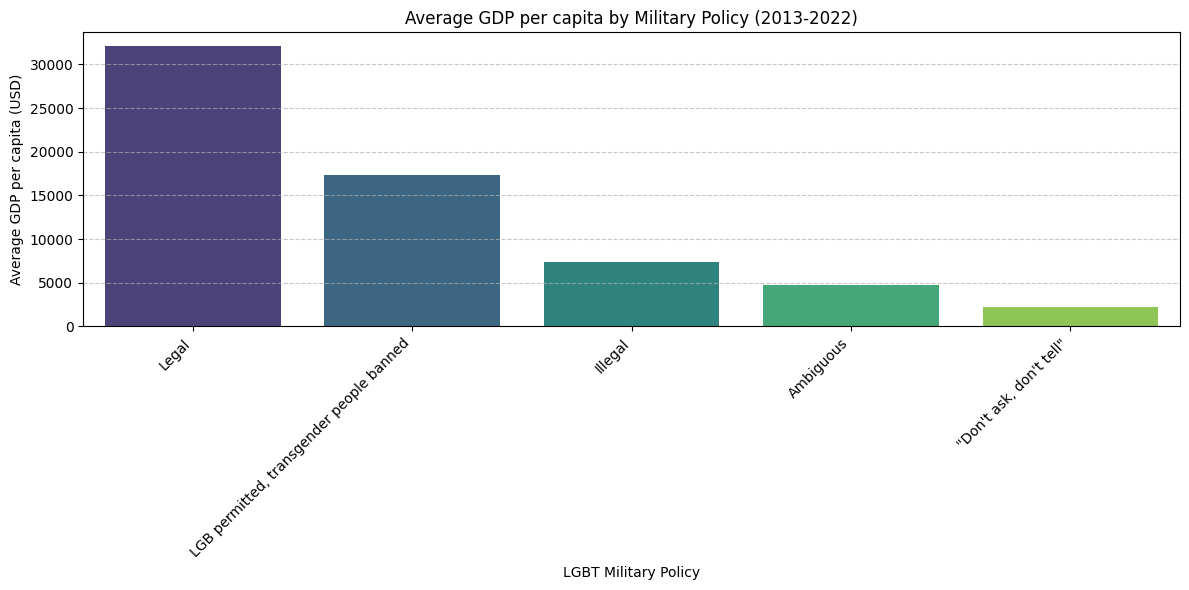

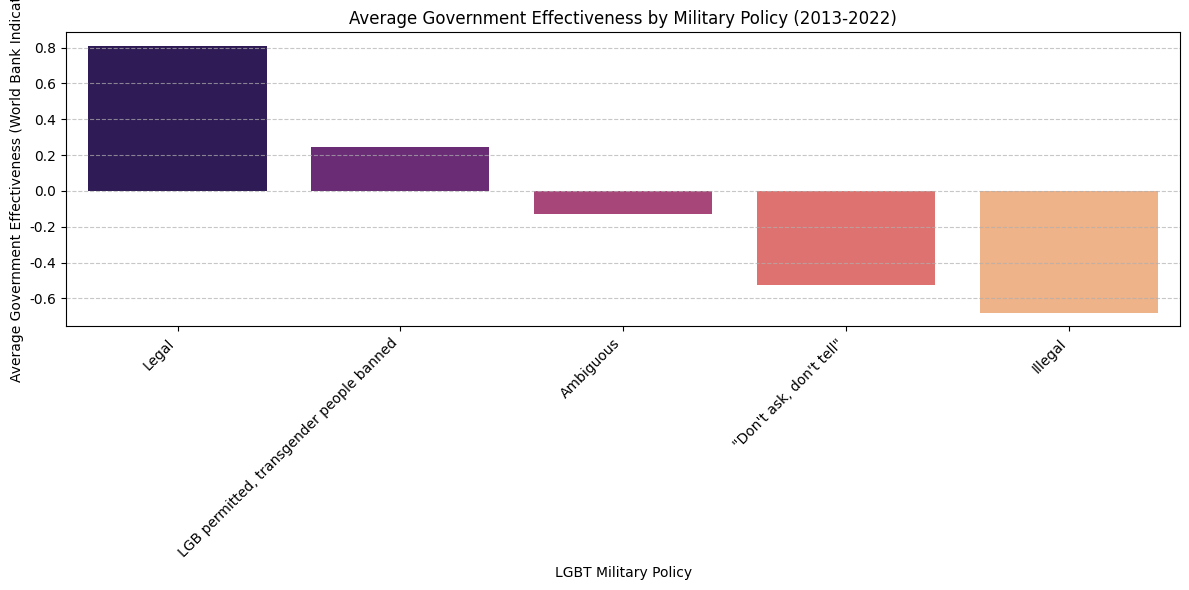

In [5]:
# 필요한 라이브러리 설치 (Colab에 없을 경우에만 실행)
# World Bank 데이터 다운로드, 데이터 처리, 시각화에 필요한 라이브러리
!pip install pandas wbgapi matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wbgapi as wb # World Bank 데이터 다운로드 시 사용

# --------------------------------------------------------------------------
# 시각화 설정 (NanumGothic 제거, 기본 폰트 사용)
# 한글 깨짐 오류는 피하지만, 한글 텍스트는 표시되지 않습니다. (모든 텍스트를 영어로 변경)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # Colab 기본 폰트
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지
# --------------------------------------------------------------------------

# 1단계에서 사용된 컬럼명 정의 (병합된 데이터 파일 로드용)
MILITARY_COL_NEW = 'Serving_openly_in_military'
ORIGINAL_MILITARY_COL_R = 'Serving openly in the military (historical)' # 1단계 파일에서 확인된 원본 컬럼명

# --------------------------------------------------------------------------
## 1. 병합된 데이터 파일 로드 (1단계 완료 전제)
# --------------------------------------------------------------------------

try:
    # 1단계에서 저장된 파일을 로드합니다. (Colab 환경에 파일이 존재해야 함)
    merged_data = pd.read_csv("merged_lgbt_worldbank_2013_2022.csv", encoding="utf-8")

    # 컬럼명이 이전 단계와 다를 경우를 대비해 처리, 로드된 데이터의 행 수 출력
    if ORIGINAL_MILITARY_COL_R in merged_data.columns:
         merged_data.rename(columns={ORIGINAL_MILITARY_COL_R: MILITARY_COL_NEW}, inplace=True)

    print(f"Successfully loaded file 'merged_lgbt_worldbank_2013_2022.csv' row: {len(merged_data)}")
except FileNotFoundError:
    print("\nError: file 'merged_lgbt_worldbank_2013_2022.csv' not found.")
    print("You must first run the first step code in Colab to generate this file.")
    # Empty DataFrame for continued execution
    merged_data = pd.DataFrame(columns=['Entity', 'Code', 'Year', MILITARY_COL_NEW,
                                        'GDP_per_capita', 'Military_Expenditure_Pct_GDP',
                                        'Government_Effectiveness'])


# --------------------------------------------------------------------------
## 2. 결측치 처리 (Handling Missing Values)
# --------------------------------------------------------------------------

# R 코드의 na.omit()에 해당하며, 분석에 필요한 모든 지표에 결측치가 없는 행만 선택합니다.
analysis_data = merged_data.dropna(subset=[MILITARY_COL_NEW,
                                           'GDP_per_capita',
                                           'Military_Expenditure_Pct_GDP',
                                           'Government_Effectiveness'])

print(f"\nNumber of rows used for analysis after removal of missing values: {len(analysis_data)}")

# 결측치 처리된 데이터 저장
analysis_data.to_csv("analysis_data_cleaned_2013_2022.csv", index=False, encoding='utf-8')
print("Missing value removed data has been saved as 'analysis_data_cleaned_2013_2022.csv'.")


# --------------------------------------------------------------------------
## 3. 그룹별 통계 계산 (Group Statistics)
# --------------------------------------------------------------------------

# 군복무 정책별 GDP per capita의 평균 계산
if not analysis_data.empty:
    gdp_summary = analysis_data.groupby(MILITARY_COL_NEW)['GDP_per_capita'].mean().reset_index()
    gdp_summary.rename(columns={'GDP_per_capita': 'Mean_GDP_per_capita'}, inplace=True)
    gdp_summary = gdp_summary.sort_values(by='Mean_GDP_per_capita', ascending=False)

    print("\nAverage GDP per capita by military service policy:")
    print(gdp_summary)

    # 군복무 정책별 정부 효과성의 평균 계산
    gov_eff_summary = analysis_data.groupby(MILITARY_COL_NEW)['Government_Effectiveness'].mean().reset_index()
    gov_eff_summary.rename(columns={'Government_Effectiveness': 'Mean_Government_Effectiveness'}, inplace=True)
    gov_eff_summary = gov_eff_summary.sort_values(by='Mean_Government_Effectiveness', ascending=False)

    print("\nAverage Government Effectiveness by Military Service Policy:")
    print(gov_eff_summary)
else:
    gdp_summary = pd.DataFrame()
    gov_eff_summary = pd.DataFrame()
    print("\nAnalysis skipped: Analysis data is empty (likely due to missing World Bank data).")


# --------------------------------------------------------------------------
## 4. 시각화 (Visualization)
# --------------------------------------------------------------------------

if not gdp_summary.empty:
    # 시각화 1: 군복무 정책별 평균 GDP per capita 막대 그래프
    plt.figure(figsize=(12, 6))
    sns.barplot(x=MILITARY_COL_NEW, y='Mean_GDP_per_capita', data=gdp_summary, palette='viridis')
    # 텍스트를 모두 영어로 변경
    plt.title('Average GDP per capita by Military Policy (2013-2022)')
    plt.xlabel('LGBT Military Policy')
    plt.ylabel('Average GDP per capita (USD)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('mean_gdp_by_military_policy.png')

    print("The visualization result was saved as 'mean_gdp_by_military_policy.png'.")

    # 시각화 2: 군복무 정책별 평균 정부 효과성 막대 그래프
    plt.figure(figsize=(12, 6))
    sns.barplot(x=MILITARY_COL_NEW, y='Mean_Government_Effectiveness', data=gov_eff_summary, palette='magma')
    # 텍스트를 모두 영어로 변경
    plt.title('Average Government Effectiveness by Military Policy (2013-2022)')
    plt.xlabel('LGBT Military Policy')
    plt.ylabel('Average Government Effectiveness (World Bank Indicator)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('mean_gov_eff_by_military_policy.png')

    print("Visualization result saved as 'mean_gov_eff_by_military_policy.png'.")

    print("\nThe two-step analysis and visualization have been completed.")
else:
     print("Visualization skipped as no summary data was generated.")


In [9]:
#상관관계 확인 검정
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import os
from sklearn.metrics import r2_score

print("현재 작업 디렉토리:", os.getcwd())
print("이 디렉토리에 쓰기 권한이 있는지 확인하세요.")

# 1. 데이터 로드
data = pd.read_csv("merged_lgbt_worldbank_2013_2022.csv")
# 열 이름 목록 출력
print("열 이름:", data.columns.tolist())

print("복무 상태 고유 값:")
print(data['Serving_openly_in_military'].unique())

# 2. 수치화
def map_military_score(status):
    mapping = {
        "Legal": 1.0,
        "LGB permitted, transgender people banned": 0.5,
        "\"Don't ask, don't tell\"": 0.3,
        "Ambiguous": 0.2,
        "Illegal": 0.0
    }
    return mapping.get(status, np.nan)

data['military_score'] = data['Serving_openly_in_military'].apply(map_military_score)

data['is_legal'] = (data['Serving_openly_in_military'] == "Legal").astype(int)
data['is_illegal'] = (data['Serving_openly_in_military'] == "Illegal").astype(int)
data['is_lgb_permitted'] = (data['Serving_openly_in_military'] == "LGB permitted, transgender people banned").astype(int)
data['is_dadt'] = (data['Serving_openly_in_military'] == "\"Don't ask, don't tell\"").astype(int)
data['is_ambiguous'] = (data['Serving_openly_in_military'] == "Ambiguous").astype(int)

# 단계별 DF
df_legal = data[data['Serving_openly_in_military'] == "Legal"]
df_illegal = data[data['Serving_openly_in_military'] == "Illegal"]
df_lgb_permitted = data[data['Serving_openly_in_military'] == "LGB permitted, transgender people banned"]
df_dadt = data[data['Serving_openly_in_military'] == "\"Don't ask, don't tell\""]
df_ambiguous = data[data['Serving_openly_in_military'] == "Ambiguous"]

# 각 정책 상태별 행 수 출력
print("데이터 크기:",
      len(df_legal), len(df_illegal), len(df_lgb_permitted), len(df_dadt), len(df_ambiguous))

# 3. 국가별 평균 데이터 생성
df_stats = data.groupby(['Entity', 'Code'], as_index=False).agg(
    avg_military_score=('military_score', 'mean'),
    prop_legal=('is_legal', 'mean'),
    prop_illegal=('is_illegal', 'mean'),
    prop_lgb_permitted=('is_lgb_permitted', 'mean'),
    prop_dadt=('is_dadt', 'mean'),
    prop_ambiguous=('is_ambiguous', 'mean'),
    avg_GDP_per_capita=('GDP_per_capita', 'mean'),
    avg_Military_Expenditure_Pct_GDP=('Military_Expenditure_Pct_GDP', 'mean'),
    avg_Government_Effectiveness=('Government_Effectiveness', 'mean'),
    num_years_for_legal_prop=('is_legal', lambda x: x.notna().sum())
)

print("결측값:")
# 국가별 평균 데이터프레임의 결측값 개수 확인
print(df_stats.isnull().sum())

df_stats.to_csv("lgbt_worldbank_stats_2013_2022.csv", index=False)

# 4. 기술통계
status_levels = ["Legal", "Illegal",
                 "LGB permitted, transgender people banned",
                 "\"Don't ask, don't tell\"", "Ambiguous"]

selected_vars = ["GDP_per_capita", "Military_Expenditure_Pct_GDP", "Government_Effectiveness"]

master_df = pd.read_csv("merged_lgbt_worldbank_2013_2022.csv")

# 정책 상태별 기술통계량 (왜도/첨도 포함) 계산 및 출력
for status_val in status_levels:
    print(f"\n=== {status_val} 기술통계 ===")
    df_subset = master_df[master_df['Serving_openly_in_military'] == status_val]
    if len(df_subset) > 0:
        cols = [c for c in selected_vars if c in df_subset.columns]
        summary = df_subset[cols].describe().T
        summary['skew'] = df_subset[cols].skew()
        summary['kurt'] = df_subset[cols].kurt()
        print(summary)
    else:
        print("데이터 없음")

# 6. 상관분석
status_mapping = {
    "Legal": df_legal,
    "Illegal": df_illegal,
    "LGB permitted, transgender people banned": df_lgb_permitted,
    "Don't ask, don't tell": df_dadt,
    "Ambiguous": df_ambiguous
}

# 정책 상태별 주요 변수 간 상관분석 수행 (피어슨 상관계수 및 p-value)
for status, df_corr in status_mapping.items():
    print(f"\n=== {status} 상관분석 ===")
    if len(df_corr) > 5:
        numeric_vars = df_corr[['GDP_per_capita', 'Military_Expenditure_Pct_GDP', 'Government_Effectiveness']].dropna()
        cor_matrix = numeric_vars.corr().round(2)
        print(cor_matrix)

        p_matrix = pd.DataFrame(np.ones_like(cor_matrix), index=cor_matrix.index, columns=cor_matrix.columns)
        for i in range(len(numeric_vars.columns)):
            for j in range(i+1, len(numeric_vars.columns)):
                _, p = stats.pearsonr(numeric_vars.iloc[:, i], numeric_vars.iloc[:, j])
                p_matrix.iloc[i, j] = p
                p_matrix.iloc[j, i] = p
        print(p_matrix.round(4))
    else:
        print("데이터 부족")

# 7. t-검정
if len(df_legal) > 0 and len(df_illegal) > 0:
    t_stat, p_val = stats.ttest_ind(df_legal['GDP_per_capita'].dropna(),
                                    df_illegal['GDP_per_capita'].dropna())
    print("t-test Legal vs Illegal:", t_stat, p_val)

# 8. 선형 회귀분석
df_stats_clean = df_stats.dropna(subset=['avg_military_score', 'avg_GDP_per_capita'])

X_simple = sm.add_constant(df_stats_clean['avg_GDP_per_capita'])
simple_model = sm.OLS(df_stats_clean['avg_military_score'], X_simple).fit()
# 단순 회귀분석 결과 (R-squared, P-value 등) 출력
print(simple_model.summary())

df_stats_clean_multi = df_stats.dropna(subset=['avg_military_score',
                                               'avg_GDP_per_capita',
                                               'avg_Military_Expenditure_Pct_GDP',
                                               'avg_Government_Effectiveness'])

X_multiple = sm.add_constant(df_stats_clean_multi[['avg_GDP_per_capita',
                                                   'avg_Military_Expenditure_Pct_GDP',
                                                   'avg_Government_Effectiveness']])

multiple_model = sm.OLS(df_stats_clean_multi['avg_military_score'], X_multiple).fit()
# 다중 회귀분석 결과 (R-squared, P-value 등) 출력
print(multiple_model.summary())

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_multiple.values, i) for i in range(X_multiple.shape[1])]
# VIF를 통해 다중공선성 확인 (Cond. No.가 높으므로 VIF도 확인)
vif["feature"] = X_multiple.columns
print(vif)

# 잔차의 정규성(Shapiro), 등분산성(Breusch-Pagan), 독립성(Durbin-Watson) 확인
shapiro_stat, shapiro_p = stats.shapiro(multiple_model.resid)
print("Shapiro:", shapiro_stat, shapiro_p)

_, bp_p, _, _ = het_breuschpagan(multiple_model.resid, multiple_model.model.exog)
print("Breusch-Pagan p:", bp_p)

dw = durbin_watson(multiple_model.resid)
print("Durbin-Watson:", dw)

print("Robust SE (HC1):")
print(multiple_model.HC1_se)

# 9. 로지스틱 회귀분석
df_stats['n_success'] = np.round(df_stats['prop_legal'] * df_stats['num_years_for_legal_prop'])
df_stats['n_fail'] = df_stats['num_years_for_legal_prop'] - df_stats['n_success']

df_logit_clean = df_stats.dropna(subset=['n_success', 'n_fail', 'avg_GDP_per_capita'])

y_binom_simple = df_logit_clean[['n_success', 'n_fail']].values
X_logit_simple = sm.add_constant(df_logit_clean['avg_GDP_per_capita'])

logit_simple_model = sm.GLM(y_binom_simple, X_logit_simple, family=sm.families.Binomial()).fit()
print(logit_simple_model.summary())

df_logit_clean_multi = df_stats.dropna(subset=[
    'n_success', 'n_fail',
    'avg_GDP_per_capita',
    'avg_Military_Expenditure_Pct_GDP',
    'avg_Government_Effectiveness'
])

y_binom = df_logit_clean_multi[['n_success', 'n_fail']].values
X_logit = sm.add_constant(df_logit_clean_multi[['avg_GDP_per_capita',
                                                'avg_Military_Expenditure_Pct_GDP',
                                                'avg_Government_Effectiveness']])

logit_model = sm.GLM(y_binom, X_logit, family=sm.families.Binomial()).fit()
print(logit_model.summary())

exp_coef = np.exp(logit_model.params)
exp_ci = np.exp(logit_model.conf_int())

odds_table = pd.DataFrame({
    'OddsRatio': exp_coef.round(3),
    '2.5 %': exp_ci[0].round(3),
    '97.5 %': exp_ci[1].round(3)
})
# 로지스틱 회귀 계수를 오즈비(Odds Ratio)로 변환
print(odds_table)

null_logit = sm.GLM(y_binom, np.ones((len(y_binom), 1)), family=sm.families.Binomial()).fit()

mcfadden_r2 = 1 - (logit_model.llf / null_logit.llf)
print("McFadden pseudo R2:", mcfadden_r2)

print("AIC:", logit_model.aic)


현재 작업 디렉토리: /content
이 디렉토리에 쓰기 권한이 있는지 확인하세요.
열 이름: ['Entity', 'Code', 'Year', 'Serving_openly_in_military', 'GDP_per_capita', 'Military_Expenditure_Pct_GDP', 'Government_Effectiveness']
복무 상태 고유 값:
['Legal' 'Illegal' 'LGB permitted, transgender people banned'
 '"Don\'t ask, don\'t tell"' 'Ambiguous']
데이터 크기: 361 122 101 44 40
결측값:
Entity                              0
Code                                0
avg_military_score                  0
prop_legal                          0
prop_illegal                        0
prop_lgb_permitted                  0
prop_dadt                           0
prop_ambiguous                      0
avg_GDP_per_capita                  2
avg_Military_Expenditure_Pct_GDP    3
avg_Government_Effectiveness        2
num_years_for_legal_prop            0
dtype: int64

=== Legal 기술통계 ===
                              count          mean           std          min  \
GDP_per_capita                359.0  31589.552133  25356.583790  1290.325387   
Military_Expendi

In [ ]:
# 필요한 라이브러리 설치 (Colab에 없을 경우에만 실행)
!pip install pandas openpyxl requests beautifulsoup4 python-dateutil

import pandas as pd
import requests
from bs4 import BeautifulSoup
from dateutil import parser
from datetime import datetime
import time

import re

# URL 리스트 정의 (R 코드와 동일)
# 참고: 이 URL들은 CNN, NYT 기사이며, 웹사이트 구조나 API 정책 변경에 따라 스크레이핑이 실패할 수 있습니다.
urls = [
  # 중국
    "https://edition.cnn.com/2021/07/09/china/china-pride-month-lgbt-weibo-intl-mic-hnk",
    "https://edition.cnn.com/2024/07/30/china/china-lgbtq-community-celebrates-rare-scenes-paris-olympics-intl-hnk",
    "https://edition.cnn.com/style/article/china-lgbtq-artists",
    "https://edition.cnn.com/2023/04/07/europe/russia-chinese-lgbtq-blogger-arrested-intl",
    "https://edition.cnn.com/2021/07/07/business/china-lgbt-wechat-censorship-intl-hnk",
    "https://edition.cnn.com/2023/11/06/asia/hong-kong-asias-first-gay-games-backlash-intl-hnk",
    "https://edition.cnn.com/2021/03/26/china/china-southern-flight-attendant-trial-lgbtq-intl-dst-hnk",
    "https://edition.cnn.com/2014/11/26/world/asia/china-rainbow-flag",
    "https://edition.cnn.com/2019/04/15/asia/pete-buttigieg-china-lgbt",
    "https://edition.cnn.com/2022/02/12/entertainment/china-lgbt-friends-television-lesbian-censorship-scli-intl/index.html",
    "https://edition.cnn.com/2019/04/17/tech/weibo-china-censorship-lgbt-intl",
    "https://edition.cnn.com/2013/06/27/world/asia/china-gay-lesbian-marriage/index.html",
    "https://edition.cnn.com/2023/09/05/china/same-sex-marriage-ruling-hong-kong-intl-hnk",
    "https://edition.cnn.com/2019/05/22/asia/taiwan-china-gay-marriage-intl",
    "https://edition.cnn.com/2020/08/14/asia/shanghai-pride-shutdown-intl-hnk",
    "https://edition.cnn.com/videos/world/2016/04/13/china-gay-marriage-rivers-lklv.cnn",
    "https://edition.cnn.com/2022/02/04/sport/beijing-games-lgbtq-visibility-intl-spt",
    "https://edition.cnn.com/2016/01/27/asia/china-first-gay-marriage-court-case",
    "https://edition.cnn.com/2018/04/16/asia/china-sina-weibo-lgbt-censorship-intl",
    "https://edition.cnn.com/2019/05/09/health/china-transgender-amnesty-report-intl",
    "https://www.bbc.com/news/business-65806846",
    "https://www.bbc.com/news/world-asia-china-51199309",
    "https://www.bbc.com/news/world-asia-china-57759480",
    "https://www.bbc.com/audio/play/w3ct1x36",
    "https://www.bbc.com/news/world-asia-china-36042000",
    "https://www.bbc.com/news/world-asia-china-60366628",
    "https://www.bbc.com/news/blogs-trending-44066237",
    "https://www.bbc.com/news/world-asia-china-43779650",
    "https://www.bbc.com/news/blogs-trending-44739282",
    "https://www.bbc.com/news/blogs-china-blog-35196824",
    "https://www.bbc.com/news/world-asia-china-38497015",
    "https://www.bbc.com/news/world-asia-china-36545899",
    "https://www.bbc.com/news/world-asia-china-38221400",
    "https://www.bbc.com/news/world-europe-41996322",
    "https://www.bbc.com/news/world-asia-china-37335802",
    "https://www.bbc.com/news/world-asia-china-18920096",
    "https://www.bbc.com/news/world-asia-china-36921331",
    "https://www.bbc.com/news/blogs-trending-31549731",
    "https://www.bbc.com/news/world-asia-china-36258905",
    "https://www.theguardian.com/global-development/2024/jan/15/its-difficult-to-survive-chinas-lgbtq-advocates-face-jail-and-forced-confession",
    "https://www.theguardian.com/world/article/2024/aug/14/custody-ruling-in-same-sex-case-hailed-as-lgbt-milestone-in-china",
    "https://www.theguardian.com/world/2021/jul/08/outrage-over-crackdown-on-lgbtq-wechat-accounts-in-china",
    "https://www.theguardian.com/tv-and-radio/2016/mar/04/china-bans-gay-people-television-clampdown-xi-jinping-censorship",
    "https://www.theguardian.com/world/2023/nov/11/gay-games-hong-kong-china-hostility-gay-transgender",
    "https://www.theguardian.com/world/2020/nov/27/chinas-lgbtq-community-seize-census-chance-to-stand-up-and-be-counted",
    "https://www.theguardian.com/world/article/2024/aug/28/taiwan-china-same-sex-gay-marriage-rules",
    "https://www.theguardian.com/sustainable-business/2017/jan/05/the-pink-yuan-how-chinese-business-is-embracing-the-lgbt-market",
    "https://www.theguardian.com/world/video/2010/jan/11/china-gay-pageant",
    "https://www.theguardian.com/world/2021/aug/29/chinese-university-appears-to-ask-for-lists-of-lgbtq-students-for-investigation",
    "https://www.theguardian.com/world/2018/apr/16/china-weibo-bans-homosexual-content-protest",
    "https://www.theguardian.com/media/video/2015/oct/08/channel-4-presents-unreported-world-chinas-gay-shock-therapy-video",
    "https://www.theguardian.com/world/2023/mar/13/chinas-rotten-girls-are-escaping-into-erotic-fiction-about-gay-men",
    "https://www.theguardian.com/global-development-professionals-network/2016/feb/11/china-lgbt-media-xiaogang-wei-rainbow-media-awards",
    "https://www.theguardian.com/world/2018/may/14/china-security-guards-assault-women-attending-lgbt-event",
    "https://www.theguardian.com/world/2019/jul/05/taiwan-marriage-law-frustration-hope-lgbt-china",
    "https://www.theguardian.com/world/2022/feb/14/chinese-fans-claim-censorship-as-gay-storylines-removed-from-friends",
    "https://www.theguardian.com/world/2014/dec/19/chinese-court-gay-straight-conversion-clinic",
    "https://www.theguardian.com/global-development/2019/may/10/china-failing-trans-people-as-young-attempt-surgery-on-themselves-study",
    "https://www.theguardian.com/world/2016/aug/06/risque-business-first-mr-gay-china-shows-new-more-public-face-of-lgbt",
    "https://www.theguardian.com/world/2016/apr/13/china-court-refuse-gay-marriage-landmark-case",
    "https://www.theguardian.com/film/2019/feb/28/china-to-remove-lgbt-scenes-from-bohemian-rhapsody",
    "https://www.theguardian.com/world/2016/apr/12/court-hears-chinas-first-transgender-discrimination-case",
    "https://www.nbcnews.com/news/world/china-beijing-lgbt-center-rcna85528",
    "https://www.nbcnews.com/nbc-out/out-news/beijing-lgbt-center-shuttered-crackdown-grows-china-rcna84708",
    "https://www.nbcnews.com/news/world/china-lgbt-rights-group-shuts-down-amid-hostile-environment-n1283306",
    "https://www.nbcnews.com/feature/nbc-out/we-re-part-china-s-population-gay-couples-seek-recognition-n1247137",
    "https://www.nbcnews.com/feature/nbc-out/why-china-raising-prospect-same-sex-marriage-n1109471",
    "https://www.nbcnews.com/nbc-out/out-news/chinese-social-media-app-wechat-deletes-university-lgbtq-accounts-rcna1357",
    "https://www.nbcnewyork.com/news/national-international/friends-fans-in-china-complain-of-censorship-after-lgbtq-plotline-axed/3558202/",
    "https://www.nbcnews.com/feature/nbc-out/same-sex-parents-challenge-stereotypes-china-n950836",
    "https://www.nbcnews.com/feature/nbc-out/lgbtq-conference-china-s-gay-capital-scrapped-n785186",
    "https://www.nbcnews.com/feature/nbc-out/rights-group-urges-china-ban-abusive-gay-conversion-therapy-n821031",
    "https://www.nbcnews.com/feature/nbc-out/lesbian-couple-s-custody-case-takes-china-uncharted-legal-waters-n1191671",
    "https://www.nbcnews.com/feature/nbc-out/gay-teacher-china-sues-school-fired-him-potential-landmark-case-n915346",
    #라오스
    "http://news.bbc.co.uk/1/hi/world/asia-pacific/8091764.stm",
    "https://www.bbc.com/news/world-asia-66924300",
    "https://www.worldnomads.com/travel-safety/southeast-asia/laos/lgbtq",
    "https://southeastasiaglobe.com/laos-in-rainbow-anan-bouapha/",
    "https://laotiantimes.com/2024/06/10/celebrating-pride-month-voices-from-the-rainbow-community-in-laos/",
    "https://www.scmp.com/week-asia/lifestyle-culture/article/3194365/ban-lgbtq-beauty-pageant-laos-sparks-culture-war",
    "https://seajunction.org/lets-love-on-lesbian-invisibility-in-laos-thanita/",
    "https://littlelaosontheprairie.org/2013/08/09/being-gay-and-queer-in-the-laotian-community/",
    "https://www.telegraph.co.uk/news/worldnews/asia/laos/9359330/Laos-holds-first-gay-pride-event.html",
    #튀니지
    "https://www.bbc.com/news/world-africa-44137901",
    "https://www.bbc.com/news/av/stories-49097786",
    "https://www.bbc.com/news/world-africa-62053997",
    "https://www.nbcnews.com/feature/nbc-out/tunisian-presidential-committee-recommends-decriminalizing-homosexuality-n883726",
    "https://www.nbcnews.com/feature/nbc-out/tunisia-has-its-first-openly-gay-candidate-president-n1041911",
    "https://www.nbcnews.com/feature/nbc-out/tunisia-vows-ban-forced-exams-suspected-gay-men-n804616",
    "https://www.nbcnews.com/feature/nbc-out/tunisian-government-moves-shutter-lgbtq-group-advocate-says-n974701",
    "https://www.theguardian.com/global-development/2019/apr/30/tunisia-invokes-sharia-law-in-bid-to-shut-down-lgbt-rights-group",
    "https://www.theguardian.com/global-development/2015/sep/02/tunisia-lesbian-community-prejudice-chouf-article-226-230",
    "https://www.theguardian.com/global-development/2018/nov/14/rights-groups-condemn-brutal-and-humiliating-tests-on-gay-men-in-tunisia",
    "https://www.theguardian.com/world/2015/dec/14/tunisia-students-homosexuality-prison-human-rights"
]

# 결과 저장용 리스트
results = []
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

print("웹 스크레이핑을 시작합니다...")

# URL별로 반복
# ... 중략 (기존 코드 동일) ...

for i, url in enumerate(urls):
    print(f"[{i+1}/{len(urls)}] 처리 중: {url}")
    time.sleep(1)

    try:
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
        page = BeautifulSoup(response.text, 'html.parser')

        # 1️⃣ NYTimes의 경우 JSON형식으로 기사 본문이 들어있음
        if "nytimes.com" in url:
            # HTML 내부에 있는 JSON 데이터 블록 추출
            script_tag = page.find("script", string=re.compile("preloadedData"))
            if script_tag:
                json_text = script_tag.get_text()
                # 본문 텍스트 추출 (간단 버전)
                paragraphs = re.findall(r'"paragraphs":\[(.*?)\]', json_text)
                joined_text = ' '.join(paragraphs)
                text_combined = re.sub(r'["\[\],]', ' ', joined_text)
            else:
                # 예비방안: p 태그로 시도
                text_nodes = page.find_all('p')
                text_combined = ' '.join([t.get_text(strip=True) for t in text_nodes])
        else:
            # 🟢 기존 CNN, BBC, Guardian 등은 그대로
            text_nodes = page.find_all('p')
            text_combined = ' '.join([t.get_text(strip=True) for t in text_nodes])

        # 제목 (기존 그대로)
        title_tag = page.find('title')
        title = title_tag.get_text(strip=True) if title_tag else "No Title Found"

        # 날짜 (기존 그대로)
        date_node = page.find('meta', {'property': 'article:published_time'})
        if not date_node:
            date_node = page.find('meta', {'name': 'date'})
        if not date_node:
            date_node = page.find('meta', {'name': 'pubdate'})

        date_str = date_node.get('content') if date_node else None

        parsed_date = None
        if date_str:
            try:
                parsed_date = parser.parse(date_str).date()
            except:
                parsed_date = None

        # 결과 저장 (기존 그대로)
        results.append({
            'url': url,
            'date': parsed_date if parsed_date else 'NA',
            'title': title,
            'text': text_combined
        })

    except requests.exceptions.RequestException as e:
        print(f"오류: URL {url} 처리 중 요청 실패: {e}")
        results.append({
            'url': url,
            'date': 'Error',
            'title': 'Request Error',
            'text': str(e)
        })
    except Exception as e:
        print(f"오류: URL {url} 처리 중 일반 오류 발생: {e}")
        results.append({
            'url': url,
            'date': 'Error',
            'title': 'Parsing Error',
            'text': str(e)
        })

# DataFrame 생성 및 엑셀로 저장 (R 코드의 openxlsx::write.xlsx 역할)
df_results = pd.DataFrame(results)

# 파일 이름을 'web_scraped_human_rights_articles_ambiguous.xlsx'로 지정
output_filename = "web_scraped_human_rights_articles_ambiguous.xlsx"
df_results.to_excel(output_filename, index=False, engine='openpyxl')

print("\n---------------------------------------------------------")
print(f"Scripps completed! A total of {len(df_results)} results have been saved.")
print(f"The result was saved in file '{output_filename}'.")
print("---------------------------------------------------------")


웹 스크레이핑을 시작합니다...
[1/94] 처리 중: https://edition.cnn.com/2021/07/09/china/china-pride-month-lgbt-weibo-intl-mic-hnk
[2/94] 처리 중: https://edition.cnn.com/2024/07/30/china/china-lgbtq-community-celebrates-rare-scenes-paris-olympics-intl-hnk
[3/94] 처리 중: https://edition.cnn.com/style/article/china-lgbtq-artists
[4/94] 처리 중: https://edition.cnn.com/2023/04/07/europe/russia-chinese-lgbtq-blogger-arrested-intl
[5/94] 처리 중: https://edition.cnn.com/2021/07/07/business/china-lgbt-wechat-censorship-intl-hnk
[6/94] 처리 중: https://edition.cnn.com/2023/11/06/asia/hong-kong-asias-first-gay-games-backlash-intl-hnk
[7/94] 처리 중: https://edition.cnn.com/2021/03/26/china/china-southern-flight-attendant-trial-lgbtq-intl-dst-hnk
[8/94] 처리 중: https://edition.cnn.com/2014/11/26/world/asia/china-rainbow-flag
[9/94] 처리 중: https://edition.cnn.com/2019/04/15/asia/pete-buttigieg-china-lgbt
[10/94] 처리 중: https://edition.cnn.com/2022/02/12/entertainment/china-lgbt-friends-television-lesbian-censorship-scli-intl/index.

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from dateutil import parser
from datetime import datetime
import time

import re

# URL 리스트 정의 (R 코드와 동일)
# 참고: 이 URL들은 CNN, NYT 기사이며, 웹사이트 구조나 API 정책 변경에 따라 스크레이핑이 실패할 수 있습니다.
urls = [
  #아르메니아
    "https://www.hrw.org/news/2018/08/10/violence-against-lgbt-activists-armenia",
    "https://ecom.ngo/en/news/history-gbt-movement-armenia/",
    "https://www.gchumanrights.org/preparedness/life-of-sexual-minorities-in-the-realm-of-armenia/",
    "https://eap-csf.eu/articles/meet-the-armenian-lgbt-activists-working-for-more-inclusivity/",
    "https://armenianweekly.com/2024/07/24/the-national-battle-over-lgbtq-instruction-comes-to-armenian-schools/",
    "https://www.opendemocracy.net/en/odr/non-sexual-revolution-armenia-en/",
    "https://www.boell.de/en/2018/03/12/why-lgbt-people-emigrate-armenia-four-stories",
    "https://regard-est.com/armenia-a-refuge-for-russias-lgbt-community",
    "https://www.5sah.co.uk/knowledge-hub/articles/2022-05-03/armenia-v-ab-successful-article-3-challenge-on-basis-of-lgbtq-persecution",
    'https://eurasianet.org/georgia-and-armenia-are-complicated-havens-for-russian-lgbtq-emigres',
    "https://www.thearmenianreport.com/post/echr-rules-against-armenia-in-lgbtq-rights-case-a-blow-to-free-expression-or-a-win-for-human-rights",
    "https://strasbourgobservers.com/2025/03/07/hate-speech-positive-obligations-and-free-speech-the-ecthrs-expanding-framework-in-minasyan-and-others-v-armenia-2025/",
    "https://armenianweekly.com/2016/10/21/listening-to-lgbt-people-in-armenia/",
    "https://www.vice.com/en/article/armenia-nagorno-karabakh-abortion-lgbtq-rights/",
    "https://iwpr.net/global-voices/its-hard-be-gay-armenia",
    "https://eurasianet.org/ahead-of-elections-armenias-opposition-attacks-lgbt-rights",
    "https://www.opendemocracy.net/en/odr/in-armenia-gender-is-geopolitical/",
    "https://ecom.ngo/en/news/report-on-violations-of-lgbt-armenia-22/",
    "https://eaparmenianews.wordpress.com/2019/12/13/the-lgbt-community-in-armenia-a-difficult-balance-must-be-maintained/",
    "https://www.gmfus.org/news/protecting-trans-rights-armenia",
    "https://jam-news.net/discrimination-against-lgbt-people/",
    "https://caucasusedition.net/armenian-homonationalism-a-reflection/",
    "https://hetq.am/en/article/171936",
    "https://oc-media.org/you-learn-to-hide-your-identity-being-queer-in-the-armenian-army/",
    "https://epress.am/en/2016/05/18/lgbt-people-suffer-widespread-harassment-discrimination-in-armenia-report-says.html",
    "https://www.openlynews.com/i/?id=086cc9fe-6b0f-478b-89da-ba7e89852f31",
    "https://www.advocate.com/world/2019/2/16/lgbtq-armenians-face-reign-terror",
    "https://araratour.com/armenia-for-lgbt-travelers",
    "https://tgeu.org/joint-statement-on-todays-long-awaited-judgment-from-the-european-court-of-human-rights-on-violations-of-lgbti-human-rights-in-armenia/",
    "https://www.themoscowtimes.com/2024/01/30/armenia-denies-extradition-request-for-gay-chechen-man-wanted-by-russia-a83910",
    "https://mirrorspectator.com/2019/04/09/ruling-bloc-opposition-spar-over-lgbt-rights-in-armenia/",
    "https://www.civilnet.am/en/news/679994/death-of-young-gay-couple-refocuses-attention-on-homophobia-in-armenia/",
    "https://humanrightshouse.org/interviews/the-reality-of-lgbt-activism-in-armenia/",
    "https://evnreport.com/raw-unfiltered/rainbow-hysteria-how-lgbt-issues-became-a-mainstream-topic-of-conversation/",
    "https://kaosgl.org/en/single-news/the-reality-of-gay-armenians-and-our-collective-shame",
    "https://queerarmenianlibrary.com/equality-armenia/",
    "https://76crimes.com/2024/02/10/armenia-refuses-to-extradite-gay-chechen-man-wanted-by-russia/",
    "https://www.france24.com/en/20190617-armenia-transgender-woman-faces-death-threats-after-parliament-speech",
    "https://newsroom.aua.am/2017/09/29/psia-seminar-lgbt-issues-in-armenia/",
    "https://abakanews.org/opinions-and-editorials/politicizing-sexual-orientation-in-armenia/",
    "https://www.equalrightstrust.org/news/armenia%E2%80%99s-draft-law-ensuring-equality-work-progress",
    "https://www.usatoday.com/story/news/nation/2019/04/26/armenian-transgender-lgbtq-issues-death-threats-lilit-martirosyan/3587012002/",
    "https://ehrac.org.uk/en_gb/armenia-failure-to-respond-to-homophobic-abuse-highlights-need-for-legal-reforms/",
    #키르기스스탄
    "https://www.ilga-europe.org/news/statement-kyrgyzstan-targets-lgbti-law/",
    "https://novastan.org/en/economics/queer-life-under-pressure-in-kyrgyzstan/",
    "https://www.theguardian.com/cities/2017/oct/19/victims-closure-bishkek-only-lgbt-club-kyrgyzstan",
    "https://www.bbc.com/news/world-asia-41437866",
    "https://www.unfpa.org/news/kyrgyzstan%E2%80%99s-lgbtqia-community-risks-escalate-under-covid-19-pandemic",
    "https://tgeu.org/kyrgyzstan-passes-anti-lgbti-propaganda-law/",
    "https://www.opensocietyfoundations.org/voices/kyrgyzstan-s-new-anti-gay-law-even-worse-russia-s",
    "https://www.hrw.org/news/2023/06/27/kyrgyzstan-attacks-media-free-expression",
    "https://www.theguardian.com/world/2016/may/04/kyrgyzstan-lgbt-community-fear-attacks-russia",
    "https://www.ohchr.org/en/press-releases/2014/11/kyrgyzstan-dont-condemn-lgbt-people-silence-un-rights-experts-urge",
    "https://www.rferl.org/a/kyrgyz-nationalists-wreck-day-against-homophobia/27023358.html",
    "https://www.hrw.org/news/2008/10/06/kyrgyzstan-protect-lesbians-and-transgender-men-abuse",
    "https://news.un.org/en/story/2014/10/481862",
    "https://nhc.no/bill-discriminating-lgbt-persons-in-the-kyrgyz-republic-should-be-withdrawn/",
    "https://eca.unwomen.org/en/stories/press-release/2025/02/kyrgyzstan-presents-preliminary-findings-and-recommendations-of-the-country-gender-equality-profile",
    "https://eurasianet.org/kyrgyzstan-anti-lgbt-bill-hits-buffers",
    "https://www.opendemocracy.net/en/odr/kyrgyzstans-conservatives-hold-their-antilgbt-rally/",
    "https://eurasianet.org/kyrgyzstans-anti-gay-bill-just-following-in-russias-footsteps",
    "https://humanityinaction.org/knowledge_detail/human-rights-diplomacy-amidst-world-war-lgbt-re-examining-western-promotion-of-lgbt-rights-in-light-of-the-traditional-values-discourse/",
    "https://www.rferl.org/a/kyrgyzstan-lgbt-rights/30030545.html",
    "https://srdefenders.org/kyrgyzstan-surveillance-marginalisation-and-targeting-of-lgbt-defenders-joint-communication/",
    "https://ifex.org/kyrgyz-draft-law-seeks-to-ban-information-about-lgbt-issues/",
    "https://www.hrc.org/press-releases/kyrgyzstan-passes-draft-anti-lgbt-propaganda-bill-thats-worse-than-russias",
    #레바논
    "https://www.hrw.org/news/2023/09/05/lebanon-attack-freedoms-targets-lgbti-people",
    "https://apnews.com/article/lebanon-lgbtq-beirut-human-rights-38399886d44895c85eb70bbfd8e711ac",
    "https://www.lemonde.fr/en/international/article/2023/08/31/in-lebanon-a-bill-decriminalizing-homosexuality-arouses-violent-resistance_6118007_4.html",
    "https://rsf.org/en/lebanon-anti-lgbt-bills-threaten-press-freedom",
    "https://www.france24.com/en/live-news/20231005-lgbtq-lebanese-under-attack-as-activists-decry-eroding-freedoms",
    "https://www.hrw.org/news/2023/08/01/anti-lgbt-rhetoric-undermines-rights-lebanon",
    "https://www.dw.com/en/lgbtq-in-lebanon-after-explosion-less-freedom-less-security/a-59921561",
    "https://today.lorientlejour.com/article/1295234/abuses-against-the-lgbtq-community-explode-in-crisis-stricken-lebanon.html",
    "https://hivos.org/blog/legal-victory-for-lgbt-activists-in-lebanon-gives-hope-despite-small-step/",
    "https://www.article19.org/reader/global-expression-report-2018-19/regional-overviews/middle-east-and-northern-africa-regional-overview/one-step-forward-two-steps-back-for-lgbtq-rights-in-lebanon/",
    "https://www.voanews.com/a/lebanon-lgbtq-community-suffers-setback-amid-wider-clampdown-/6663098.html",
    "https://themedialine.org/people/despite-win-in-courts-lgbt-community-suffers-discrimination-abuse-in-lebanon/",
    "https://lebanon.un.org/en/188293-un-lebanon-joint-statement-support-lgbtiq-lebanon",
    "https://www.france24.com/en/live-news/20220707-scary-to-be-queer-lebanon-cracks-down-on-lgbtq-rights",
    "https://psychiatryonline.org/doi/10.1176/appi.pn.2018.11a9",
    "https://smex.org/lebanon-unlawful-crackdown-on-lgbt-gatherings/",
    "https://www.indexoncensorship.org/2014/04/gay-rights-lebanon-good-bad-ugly/",
    "https://edition.cnn.com/2018/05/04/middleeast/lebanon-elections-lgbt-rights-intl",
    "https://www.bbc.co.uk/programmes/p07533bd",
    "https://www.hrc.org/news/hrc-global-innovator-discusses-recent-lebanon-court-ruling-and-lgbtq-progre",
    "https://lebanon.un.org/en/126954-un-lebanon-joint-statement-international-day-against-homophobia-biphobia-intersexphobia-and",
    "https://www.voanews.com/a/lebanese-gay-rights-activists-call-for-legal-reform-118386304/172814.html",
    "https://www.theguardian.com/world/2023/aug/30/lebanon-lgbtq-activists-attacks-distraction-scapegoated",
    "https://www.thenewhumanitarian.org/opinion/2024/11/04/moral-imperative-protect-lebanon-lgbtiq-displaced",
    "https://www.thedailybeast.com/inside-the-fight-for-lgbt-equality-in-lebanon/",
    "https://today.lorientlejour.com/article/1346389/lebanons-lgbtq-community-targeted-from-every-direction.html",
    "https://www.moroccoworldnews.com/2019/11/75766/lebanon-leaps-losses-lgbt-rights/",
    "https://www.amnesty.org/en/latest/press-release/2019/05/lgbti-community-activism-in-lebanon-a-story-of-existence-and-oppression/",
    #르완다
    "https://theconversation.com/rwanda-lgbt-rights-are-protected-on-paper-but-discrimination-and-homophobia-persist-182949",
    "https://www.africanews.com/2022/06/01/rwanda-s-lgbtq-community-still-faces-discrimination/",
    "https://www.rainbowmigration.org.uk/news/rwanda-is-not-safe-for-lgbtqi-people/",
    "https://www.dw.com/en/rwanda-activists-want-trans-and-intersex-legal-rights/a-66819362",
    "https://www.opendemocracy.net/en/rwanda-bill-safety-lgbtq-asylum-seekers-unhcr-mps-vote/",
    "https://www.dw.com/en/rwandas-lgbtq-people-want-to-be-counted/a-62868623",
    "https://www.france24.com/en/live-news/20240423-rwandan-lgbtq-fashion-designer-plans-comeback-after-arrest",
    "https://www.rainbowmigration.org.uk/news/i-fled-rwanda-due-to-homophobia-i-fear-for-gay-refugees-being-sent-there/",
    "https://www.ritimo.org/Rwandan-LGBTIQ-people-warn-It-s-unsafe-to-send-queer-asylum-seekers-here",
    "https://www.hrw.org/news/2021/09/27/rwanda-round-ups-linked-commonwealth-meeting",
    "https://www.theguardian.com/uk-news/2022/may/10/home-office-admits-gay-lesbian-refugees-could-be-persecuted-sent-rwanda",
    "https://www.rainbowrailroad.org/the-latest/building-capacity-for-activism-in-rwanda-spotlight-on-human-rights-first-rwanda-association",
    "https://apnews.com/article/rwanda-conservative-anglicans-conference-lgbtq-row-gafcon-8588b499c5456b53ed2f7816d69f53c3"
]

# 결과 저장용 리스트
results = []
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

print("웹 스크레이핑을 시작합니다...")

# URL별로 반복
# ... 중략 (기존 코드 동일) ...

for i, url in enumerate(urls):
    print(f"[{i+1}/{len(urls)}] 처리 중: {url}")
    time.sleep(1)

    try:
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
        page = BeautifulSoup(response.text, 'html.parser')

        # 1️⃣ NYTimes의 경우 JSON형식으로 기사 본문이 들어있음
        if "nytimes.com" in url:
            # HTML 내부에 있는 JSON 데이터 블록 추출
            script_tag = page.find("script", string=re.compile("preloadedData"))
            if script_tag:
                json_text = script_tag.get_text()
                # 본문 텍스트 추출 (간단 버전)
                paragraphs = re.findall(r'"paragraphs":\[(.*?)\]', json_text)
                joined_text = ' '.join(paragraphs)
                text_combined = re.sub(r'["\[\],]', ' ', joined_text)
            else:
                # 예비방안: p 태그로 시도
                text_nodes = page.find_all('p')
                text_combined = ' '.join([t.get_text(strip=True) for t in text_nodes])
        else:
            # 🟢 기존 CNN, BBC, Guardian 등은 그대로
            text_nodes = page.find_all('p')
            text_combined = ' '.join([t.get_text(strip=True) for t in text_nodes])

        # 제목 (기존 그대로)
        title_tag = page.find('title')
        title = title_tag.get_text(strip=True) if title_tag else "No Title Found"

        # 날짜 (기존 그대로)
        date_node = page.find('meta', {'property': 'article:published_time'})
        if not date_node:
            date_node = page.find('meta', {'name': 'date'})
        if not date_node:
            date_node = page.find('meta', {'name': 'pubdate'})

        date_str = date_node.get('content') if date_node else None

        parsed_date = None
        if date_str:
            try:
                parsed_date = parser.parse(date_str).date()
            except:
                parsed_date = None

        # 결과 저장 (기존 그대로)
        results.append({
            'url': url,
            'date': parsed_date if parsed_date else 'NA',
            'title': title,
            'text': text_combined
        })

    except requests.exceptions.RequestException as e:
        print(f"오류: URL {url} 처리 중 요청 실패: {e}")
        results.append({
            'url': url,
            'date': 'Error',
            'title': 'Request Error',
            'text': str(e)
        })
    except Exception as e:
        print(f"오류: URL {url} 처리 중 일반 오류 발생: {e}")
        results.append({
            'url': url,
            'date': 'Error',
            'title': 'Parsing Error',
            'text': str(e)
        })

# DataFrame 생성 및 엑셀로 저장 (R 코드의 openxlsx::write.xlsx 역할)
df_results = pd.DataFrame(results)

# 파일 이름을 'web_scraped_human_rights_articles_dadt.xlsx'로 지정
output_filename = "web_scraped_human_rights_articles_dadt.xlsx"
df_results.to_excel(output_filename, index=False, engine='openpyxl')

print("\n---------------------------------------------------------")
print(f"Scripps completed! A total of {len(df_results)} results have been saved.")
print(f"The result was saved in file '{output_filename}'.")
print("---------------------------------------------------------")

웹 스크레이핑을 시작합니다...
[1/107] 처리 중: https://www.hrw.org/news/2018/08/10/violence-against-lgbt-activists-armenia
[2/107] 처리 중: https://ecom.ngo/en/news/history-gbt-movement-armenia/
[3/107] 처리 중: https://www.gchumanrights.org/preparedness/life-of-sexual-minorities-in-the-realm-of-armenia/
[4/107] 처리 중: https://eap-csf.eu/articles/meet-the-armenian-lgbt-activists-working-for-more-inclusivity/
[5/107] 처리 중: https://armenianweekly.com/2024/07/24/the-national-battle-over-lgbtq-instruction-comes-to-armenian-schools/
오류: URL https://armenianweekly.com/2024/07/24/the-national-battle-over-lgbtq-instruction-comes-to-armenian-schools/ 처리 중 요청 실패: 403 Client Error: Forbidden for url: https://armenianweekly.com/2024/07/24/the-national-battle-over-lgbtq-instruction-comes-to-armenian-schools/
[6/107] 처리 중: https://www.opendemocracy.net/en/odr/non-sexual-revolution-armenia-en/
오류: URL https://www.opendemocracy.net/en/odr/non-sexual-revolution-armenia-en/ 처리 중 요청 실패: 403 Client Error: Forbidden for url: ht

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from dateutil import parser
from datetime import datetime
import time

import re

# URL 리스트 정의 (R 코드와 동일)
# 참고: 이 URL들은 CNN, NYT 기사이며, 웹사이트 구조나 API 정책 변경에 따라 스크레이핑이 실패할 수 있습니다.
urls = [
  "https://www.usatoday.com/story/money/2025/06/02/gay-transgender-least-most-welcoming-states/83773344007/",
    "https://www.nbcnews.com/nbc-out",
    "https://www.americanprogress.org/article/discrimination-and-barriers-to-well-being-the-state-of-the-lgbtqi-community-in-2022/",
    "https://www.usatoday.com/story/news/nation/2025/02/05/lgbtq-acceptance-lowest-decade-poll/78221597007/",
    "https://www.advocate.com/news/worldpride-dc-2025",
    "https://www.advocate.com/news/supreme-court-ames-ohio-reverse-discrimination",
    "https://www.advocate.com/voices/trump-cant-shut-down-pride",
    "https://www.nbcnews.com/nbc-out/out-news/us-sees-progress-lgbtq-rights-equality-lacking-un-expert-says-rcna45622",
    "https://www.advocate.com/voices/the-future-of-lgbtq-journalism-begins-with-you",
    "https://www.advocate.com/voices/pride-month-nasty-pig-corporate",
    "https://www.advocate.com/voices/donald-trump-attacks-trans-healthcare",
    "https://www.advocate.com/voices/transgender-in-the-workplace",
    "https://www.advocate.com/voices/trump-voters-blood-on-hands",
    "https://www.advocate.com/voices/pete-buttigieg-panders-bros",
    "https://www.advocate.com/voices/100-days-donald-trump-worst",
    "https://www.advocate.com/voices/trump-100-days",
    "https://www.advocate.com/voices/nancy-mace-south-carolina-transgender",
    "https://www.advocate.com/voices/visions-of-solidarity-schulman-vaid",
    "https://www.advocate.com/voices/trump-100-days-lgbtq-erasure",
    "https://www.advocate.com/voices/when-exes-come-back",
    "https://www.nbcnews.com/nbc-out/out-politics-and-policy/transgender-troops-face-deadline-difficult-decision-stay-go-rcna211468",
    "https://www.nbcnews.com/nbc-out/out-news/dei-rollbacks-corporations-pull-sponsorship-pride-parades-rcna200330",
    "https://www.nbcnews.com/nbc-out/out-news/trump-administration-axes-125m-lgbtq-health-funding-upending-research-rcna199175",
    "https://www.nbcnews.com/nbc-out/out-news/trans-athletes-are-scrutiny-ever-found-safe-space-gymnastics-rcna200454",
    "https://www.nbcnews.com/nbc-out/out-news/most-challenged-library-books-list-2024-rcna199977",
    "https://www.nbcnews.com/nbc-out/out-life-and-style/womens-sports-bars-quadruple-us-2025-rcna196763",
    "https://www.nbcnews.com/politics/supreme-court/supreme-court-revives-straight-womans-reverse-discrimination-claim-rcna202336",
    "https://www.nbcnews.com/nbc-out/out-news/worldpride-gathers-washington-trump-rolls-back-lgbtq-rights-rcna211133",
    "https://www.nbcnews.com/nbc-out/out-politics-and-policy/nebraska-latest-state-ban-transgender-students-girls-sports-rcna211010",
    "https://www.nbcnews.com/pop-culture/pop-culture-news/tim-mcgraw-faith-hills-daughter-says-proud-queer-pride-month-post-rcna210883",
    "https://www.nbcnews.com/nbc-out/out-news/edmund-white-groundbreaking-gay-author-dies-85-rcna210868",
    "https://news.gallup.com/poll/656708/lgbtq-identification-rises.aspx",
    "https://www.bbc.com/news/articles/cgkj8gx1vy6o",
    "https://www.pbs.org/newshour/show/u-s-support-for-lgbtq-rights-is-declining-after-decades-of-support-heres-why",
    "https://www.pbs.org/newshour/nation/most-lgbtq-adults-feel-americans-dont-accept-transgender-people-poll-finds",
    "https://www.pbs.org/newshour/world/pope-francis-reached-out-to-migrants-and-lgbtq-community-but-also-drew-unusual-opposition",
    "https://www.pbs.org/newshour/politics/supreme-court-will-hear-colorado-case-about-state-bans-on-conversion-therapy-for-lgbtq-children",
    "https://www.pbs.org/newshour/politics/trump-demands-apology-after-bishop-asked-him-to-have-mercy-on-lgbtq-people-and-migrants",
    "https://www.pbs.org/newshour/politics/watch-have-mercy-on-lgbtq-communities-and-immigrants-episcopal-bishop-asks-trump",
    "https://www.pbs.org/newshour/politics/judge-tosses-bidens-title-ix-rules-rejecting-expansion-of-protections-for-lgbtq-students",
    "https://www.pbs.org/newshour/politics/attorneys-see-surge-of-lgbtq-parents-seeking-to-adopt-their-children-before-new-trump-term",
    "https://apnews.com/article/pentagon-trump-harvey-milk-ship-san-francisco-0f033bbe7641e5af045b66697657c351",
    "https://apnews.com/article/harvey-milk-navy-ship-renamed-pride-month-d6cda5df15ee5bc066092d54c591c6f2",
    "https://apnews.com/article/world-pride-lgbtq-trans-8a86f866e61c9750ffaa2b2bbe36ca8a",
    "https://apnews.com/video/before-the-word-transgender-existed-icon-bambi-already-danced-for-the-stars-228824a6487e4dc9bc5fb1d9f825e452",
    "https://apnews.com/article/social-media-lgbtq-tiktok-x-facebook-instagram-glaad-f790bda1bc3f169ef28ca3f441ea8447",
    "https://apnews.com/article/world-pride-lgbtq-parade-washington-8399b87fb17792740d1c84094369c682",
    "https://theconversation.com/the-federal-government-will-stop-collecting-data-on-lgbt-seniors-thats-bad-news-for-their-health-75576",
    "https://theconversation.com/women-marching-worldwide-revive-a-long-sought-dream-global-feminism-71777",
    "https://theconversation.com/queer-rights-have-polarised-the-world-heres-what-we-can-do-about-it-65684",
    "https://theconversation.com/companies-must-advocate-for-lgbt-rights-everywhere-in-the-world-not-just-where-its-easy-167915",
    "https://theconversation.com/welcoming-but-not-affirming-being-gay-and-christian-64110",
    "https://theconversation.com/young-lgbt-americans-are-more-politically-engaged-than-the-rest-of-generation-z-119506",
    "https://theconversation.com/schools-dont-feel-like-safe-spaces-for-lgbt-teachers-130714",
    "https://theconversation.com/despite-recent-victories-plights-of-many-lgbt-people-remain-ignored-49273",
    "https://theconversation.com/the-rise-of-pride-marketing-and-the-curse-of-pink-washing-30925",
    "https://theconversation.com/why-you-should-think-twice-before-you-talk-about-the-lgbt-community-81711",
    "https://theconversation.com/the-census-will-officially-count-same-sex-couples-for-the-first-time-ever-but-thats-not-enough-89902",
    "https://theconversation.com/poor-communication-discrimination-and-lack-of-training-why-lgbt-people-may-face-inequalities-in-palliative-care-119957",
    "https://theconversation.com/orlando-shooting-is-the-latest-chapter-in-the-global-fight-for-lgbt-rights-61010",
    "https://theconversation.com/why-its-often-still-so-difficult-to-be-out-and-proud-66655",
    "https://theconversation.com/are-lgbt-americans-actually-reaping-the-benefits-of-marriage-77065",
    "https://theconversation.com/lgbt-equality-doesnt-exist-but-heres-how-to-fight-for-it-60977",
    "https://theconversation.com/youre-rarely-safe-being-lgbt-in-the-american-south-even-from-the-police-61032",
    "https://theconversation.com/lgbtq-history-month-celebrating-queer-memory-in-our-cities-222531",
    "https://theconversation.com/teaching-primary-school-children-about-lgbt-relationships-is-the-government-taking-the-right-approach-138486",
    "https://theconversation.com/small-daily-struggles-make-lgbt-people-feel-like-they-have-to-hide-99416",
    "https://theconversation.com/film-has-a-lot-to-learn-from-tv-when-it-comes-to-lgbt-representation-30120",
    "https://theconversation.com/we-cant-talk-about-lgbt-health-without-remembering-virginia-brooks-132850",
    "https://theconversation.com/does-the-civil-rights-act-protect-lgbt-workers-the-supreme-court-is-about-to-decide-125290",
    "https://www.globalcitizen.org/en/content/9-battles-the-lgbt-community-in-the-us-is-still-fi/",
    "https://www.theguardian.com/us-news/2024/mar/11/us-public-support-lgbtq-protection-falls",
    "https://www.theguardian.com/commentisfree/2023/sep/01/lgbtq-homophobia-rise-new-york",
    "https://www.theguardian.com/us-news/2022/apr/28/lgbtq-rights-us-dont-say-gay",
    "https://www.theguardian.com/us-news/2025/mar/03/republicans-same-sex-marriage",
    "https://www.theguardian.com/us-news/2025/apr/22/supreme-court-schools-lgbtq-books",
    "https://www.theguardian.com/us-news/2025/may/29/pride-month-trump",
    "https://www.theguardian.com/world/interactive/2012/may/08/gay-rights-united-states",
    "https://www.theguardian.com/commentisfree/2024/nov/26/be-disruptive-what-queer-history-tells-us-about-confronting-trump",
    "https://www.theguardian.com/world/2023/jun/06/lgbtq-rights-trans-gay-texas-florida-north-carolina",
    "https://www.theguardian.com/world/video/2017/jul/26/come-out-come-out-come-out-50-years-of-gay-liberation-video",
    "https://www.theguardian.com/us-news/ng-interactive/2024/sep/24/donald-trump-presidency-republican-lawmakers-targeting-lgbtq-policies",
    "https://www.theguardian.com/commentisfree/2022/feb/23/finally-the-great-gay-agenda-is-working-twice-as-many-of-us-now-identify-as-lgbtq",
    "https://www.theguardian.com/world/2022/feb/15/lgbtq-rights-ban-us-schools-republicans",
    "https://www.theguardian.com/world/2025/may/09/pope-leo-xiv-lgbtq",
    "https://www.theguardian.com/books/2025/jan/12/lgbtq-rights-american-revolution",
    "https://www.theguardian.com/world/2023/jul/09/us-religious-right-lgbtq-global-culture-fronts",
    "https://www.theguardian.com/world/2022/aug/30/lgbtq-civil-rights-us-united-nations",
    "https://www.theguardian.com/law/2023/jun/30/us-supreme-court-ruling-lgbtq-rights-colorado"
]

# 결과 저장용 리스트
results = []
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

print("웹 스크레이핑을 시작합니다...")

# URL별로 반복
# ... 중략 (기존 코드 동일) ...

for i, url in enumerate(urls):
    print(f"[{i+1}/{len(urls)}] 처리 중: {url}")
    time.sleep(1)

    try:
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
        page = BeautifulSoup(response.text, 'html.parser')

        # 1️⃣ NYTimes의 경우 JSON형식으로 기사 본문이 들어있음
        if "nytimes.com" in url:
            # HTML 내부에 있는 JSON 데이터 블록 추출
            script_tag = page.find("script", string=re.compile("preloadedData"))
            if script_tag:
                json_text = script_tag.get_text()
                # 본문 텍스트 추출 (간단 버전)
                paragraphs = re.findall(r'"paragraphs":\[(.*?)\]', json_text)
                joined_text = ' '.join(paragraphs)
                text_combined = re.sub(r'["\[\],]', ' ', joined_text)
            else:
                # 예비방안: p 태그로 시도
                text_nodes = page.find_all('p')
                text_combined = ' '.join([t.get_text(strip=True) for t in text_nodes])
        else:
            # 🟢 기존 CNN, BBC, Guardian 등은 그대로
            text_nodes = page.find_all('p')
            text_combined = ' '.join([t.get_text(strip=True) for t in text_nodes])

        # 제목 (기존 그대로)
        title_tag = page.find('title')
        title = title_tag.get_text(strip=True) if title_tag else "No Title Found"

        # 날짜 (기존 그대로)
        date_node = page.find('meta', {'property': 'article:published_time'})
        if not date_node:
            date_node = page.find('meta', {'name': 'date'})
        if not date_node:
            date_node = page.find('meta', {'name': 'pubdate'})

        date_str = date_node.get('content') if date_node else None

        parsed_date = None
        if date_str:
            try:
                parsed_date = parser.parse(date_str).date()
            except:
                parsed_date = None

        # 결과 저장 (기존 그대로)
        results.append({
            'url': url,
            'date': parsed_date if parsed_date else 'NA',
            'title': title,
            'text': text_combined
        })

    except requests.exceptions.RequestException as e:
        print(f"오류: URL {url} 처리 중 요청 실패: {e}")
        results.append({
            'url': url,
            'date': 'Error',
            'title': 'Request Error',
            'text': str(e)
        })
    except Exception as e:
        print(f"오류: URL {url} 처리 중 일반 오류 발생: {e}")
        results.append({
            'url': url,
            'date': 'Error',
            'title': 'Parsing Error',
            'text': str(e)
        })

# DataFrame 생성 및 엑셀로 저장 (R 코드의 openxlsx::write.xlsx 역할)
df_results = pd.DataFrame(results)

# 파일 이름을 'web_scraped_human_rights_articles_america.xlsx'로 지정
output_filename = "web_scraped_human_rights_articles_america.xlsx"
df_results.to_excel(output_filename, index=False, engine='openpyxl')

print("\n---------------------------------------------------------")
print(f"Scripps completed! A total of {len(df_results)} results have been saved.")
print(f"The result was saved in file '{output_filename}'.")
print("---------------------------------------------------------")

웹 스크레이핑을 시작합니다...
[1/89] 처리 중: https://www.usatoday.com/story/money/2025/06/02/gay-transgender-least-most-welcoming-states/83773344007/
[2/89] 처리 중: https://www.nbcnews.com/nbc-out
[3/89] 처리 중: https://www.americanprogress.org/article/discrimination-and-barriers-to-well-being-the-state-of-the-lgbtqi-community-in-2022/
오류: URL https://www.americanprogress.org/article/discrimination-and-barriers-to-well-being-the-state-of-the-lgbtqi-community-in-2022/ 처리 중 요청 실패: 403 Client Error: Forbidden for url: https://www.americanprogress.org/article/discrimination-and-barriers-to-well-being-the-state-of-the-lgbtqi-community-in-2022/
[4/89] 처리 중: https://www.usatoday.com/story/news/nation/2025/02/05/lgbtq-acceptance-lowest-decade-poll/78221597007/
[5/89] 처리 중: https://www.advocate.com/news/worldpride-dc-2025
[6/89] 처리 중: https://www.advocate.com/news/supreme-court-ames-ohio-reverse-discrimination
[7/89] 처리 중: https://www.advocate.com/voices/trump-cant-shut-down-pride
[8/89] 처리 중: https://www.nbcnew

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from dateutil import parser
from datetime import datetime
import time

import re

# URL 리스트 정의 (R 코드와 동일)
# 참고: 이 URL들은 CNN, NYT 기사이며, 웹사이트 구조나 API 정책 변경에 따라 스크레이핑이 실패할 수 있습니다.
urls = [
  #알제리
    "https://nomadicboys.com/gay-travel-guide-to-algeria-for-first-timers/",
    "https://archive.globalgayz.com/africa/algeria/gay-lesbian-mobilization-in-algeria-the-emergence-of-a-movement/",
    "https://www.jpost.com/middle-east/algerian-student-murdered-he-is-gay-written-on-wall-with-his-blood-580733",
    "https://www.ilgrandecolibri.com/en/revolution-in-algeria-has-the-colors-of-the-lgbt-rainbow/",
    "https://www.france24.com/en/20171011-gay-lesbian-algeria-rainbow-marriage-lgbt-prejudice-discrimination",
    "https://www.amnesty.org/en/location/middle-east-and-north-africa/north-africa/algeria/report-algeria/",
    "https://luqmanithompson.com/news/immigration-litigation-update-algerian-gay-country-guidance-case",
    "https://www.wesa.fm/arts-sports-culture/2022-02-15/algerian-writer-and-human-rights-advocate-sets-up-in-pittsburgh",
    "https://mondediplo.com/2019/08/06algeria",
    "https://www.penopp.org/articles/homosexuals-algeria-self-hating-sexual-apartheid",
    "https://www.newarab.com/news/algeria-vows-ban-rainbow-coloured-products",
    "https://www.newarab.com/news/algerian-student-throat-slit-alleged-homophobic-murder",
    "https://newhumanist.org.uk/articles/867/death-to-deviants",
    "https://www.snopes.com/fact-check/trans-rights-algeria/",
    "https://voiceofsalam.com/2019/03/12/alouen-shares-the-reality-of-homophobia-across-algeria/",
    "https://www.huffpost.com/entry/cruising-the-kashbah_b_8805412",
    "https://northafricapost.com/28143-algeria-medical-student-slaughtered-on-campus-for-being-gay.html",
    "https://queerintheworld.com/lgbt-rights-in-algeria/",
    "https://www.fairplanet.org/story/death-penalty-homosexualty-illegal/",
    "https://therecord.media/lgbtq-mena-region-digital-harassment",
    "https://www.mambaonline.com/2020/10/15/algeria-2-jailed-after-mass-gay-wedding-arrests/",
    "https://www.arab-reform.net/publication/rainbow-items-and-the-morality-of-colors-in-arab-countries/",
    "https://www.dazeddigital.com/film-tv/article/60600/1/barbie-movie-film-too-gay-algeria-kuwait-lebanon-ban-promotes-homosexuality",
    #가이아나
    "https://76crimes.com/2024/01/10/despite-progress-guyana-holds-tight-to-its-homophobia/",
    "https://www.jamaicaobserver.com/2024/09/25/guyana-urged-repeal-laws-sex-couples-capitalise-lgbt-tourism/",
    "https://www.scienceopen.com/hosted-document?doi=10.13169/jofstudindentleg.2.2.0128",
    "https://www.guyanastandard.com/2023/10/29/lgbtq-rights-in-guyana-a-journey-towards-acceptance/",
    "https://www.theadvocatesforhumanrights.org/International_Submissions/A/Index?id=465",
    "https://www.unaids.org/en/resources/presscentre/featurestories/2022/february/20220228_guyana-transgender-anti-discrimination-laws",
    "https://www.oneyoungworld.com/blog/guyanas-lgbt-youth",
    "https://76crimes.com/2023/01/15/one-day-i-will-be-the-first-gay-president-of-guyana/",
    "https://www.humandignitytrust.org/country-profile/guyana/",
    "https://guyana.un.org/en/133425-advocating-rights-and-protection-lgbtiq-community",
    "https://frontlineaids.org/guyana-transgender-law-victory-paves-way-for-greater-reform/",
    "https://www.thepinknews.com/2023/05/21/guyana-lgbtq-rights-british-colonial-law-sasod/",
    #이라크
    "https://www.hrw.org/news/2024/05/20/iraq-repeal-anti-lgbt-law",
    "https://apnews.com/article/iraq-lgbtq-law-85e5e55cde7a581631c484ad83b0773c",
    "https://www.bbc.com/news/world-middle-east-68914551",
    "https://edition.cnn.com/2024/04/27/middleeast/iraq-lgbtq-crackdown-intl-latam",
    "https://www.dw.com/en/iraqi-lgbtq-community-loses-social-media-safe-space/a-68991397",
    "https://www.pbs.org/newshour/world/iraq-passes-harsh-anti-lgbtq-law-imposing-up-to-15-years-in-prison-drawing-backlash",
    "https://www.france24.com/en/live-news/20240430-lgbtq-iraqis-fear-dark-days-ahead-after-anti-gay-law",
    "https://www.theguardian.com/world/2024/apr/28/human-rights-groups-and-diplomats-condemn-iraqs-anti-lgbt-law",
    "https://www.aljazeera.com/news/2024/4/27/iraq-criminalises-same-sex-relationships-with-maximum-15-years-in-prison",
    "https://www.bbc.com/news/world-middle-east-68914551",
    "https://www.lemonde.fr/en/lgbtq/article/2024/04/28/iraq-passes-bill-sentencing-same-sex-relations-up-to-15-years-in-prison_6669770_211.html",
    "https://www.unaids.org/en/resources/presscentre/pressreleaseandstatementarchive/2024/april/20240430_iraq",
    "https://www.reuters.com/world/middle-east/iraq-criminalises-same-sex-relationships-with-maximum-15-years-prison-2024-04-27/",
    "https://www.voanews.com/a/united-nations-alarmed-by-iraq-new-anti-lgbtq-law/7589589.html",
    "https://www.aljazeera.com/news/2022/3/26/lgbt-people-in-iraq-face-violence-by-police-armed-groups",
    "https://www.abc.net.au/news/2023-09-17/iraq-proposes-death-penalty-for-lgbt-relationships/102777576",
    "https://apnews.com/article/middle-east-religion-violence-gay-rights-iraq-f5c0a3568556d341885dd70aa78cd161",
    "https://www.dw.com/en/iraq-us-uk-condemn-bill-criminalizing-homosexuality/a-68941850",
    "https://www.middleeasteye.net/news/iraq-anti-lgbtq-law-raises-concerns-rights-group",
    "https://equality.house.gov/media-center/international-news/exposing-persection-of-lgbt-individuals-in-iraq",
    "https://www.newarab.com/news/iraqi-parliament-readies-vote-anti-lgbt-bill",
    "https://today.lorientlejour.com/article/1347072/lgbtq-iraqis-face-new-threat-as-lawmakers-mull-death-penalty.html",
    "https://www.middleeasteye.net/news/iraq-gay-trans-plagued-threats-violence-now-law",
    "https://theweek.com/law/lgbt-rights-iraq-morality-laws",
    "https://2021-2025.state.gov/anti-prostitution-and-homosexuality-law-in-iraq/",
    "https://www.jurist.org/news/2024/05/hrw-urges-iraqi-government-to-reverse-law-criminalizing-lgbtq-behavior/",
    "https://fox5sandiego.com/news/ap-top-headlines/ap-passage-of-harsh-anti-lgbtq-law-in-iraq-draws-diplomatic-backlash/",
    "https://www.amnesty.org/en/latest/news/2023/08/iraq-authorities-must-immediately-reverse-media-ban-on-the-terms-homosexuality-and-gender/",
    "https://www.latimes.com/archives/la-xpm-2007-aug-05-fg-iraqgay5-story.html",
    "https://www.oneyoungworld.com/blog/founding-iraqs-first-lgbt-organisation",
    "https://www.vice.com/en/article/caught-between-the-islamic-state-and-shiite-militias-gays-are-dying-in-iraq/",
    "https://www.voanews.com/a/rights-groups-alarmed-about-new-anti-lgbtq-law-in-iraq-/7590002.html",
    "https://www.nbcwashington.com/news/national-international/passage-of-harsh-anti-lgbtq-law-in-iraq-draws-diplomatic-backlash/3603341/",
    "https://indianexpress.com/article/world/iraq-criminalises-same-sex-relationships-with-maximum-15-years-in-prison-9294458/",
    "https://theglobepost.com/2024/04/30/iraq-anti-gay-law/",
    "https://www.timesofisrael.com/iraq-criminalizes-same-sex-relations-sets-10-15-year-prison-sentence/",
    "https://currentaffairs.adda247.com/iraq-enacts-harsh-anti-lgbt-legislation-a-blow-to-human-rights/",
    "https://raseef22.net/english/article/1087189-iraqs-lgbt-communitys-two-choices-immigration-or-death",
    "https://www.cbsnews.com/news/iraq-ban-word-homosexual-on-all-media-platforms-offers-alternative/",
    "https://www.i24news.tv/en/news/middle-east/levant-turkey/artc-in-new-law-iraq-criminalizes-same-sex-relationships",
    "https://www.independent.co.uk/news/world/middle-east/iraq-same-sex-marriage-criminal-morality-latest-b2535997.html",
    "https://www.theglobeandmail.com/world/article-iraq-bans-media-from-using-term-homosexuality-says-they-must-use/",
    "https://sxpolitics.org/we-recommend/compilations/iraq-new-law-criminalizes-same-sex-relations/32747/",
    "https://www.prospectmagazine.co.uk/world/48242/is-iraq-ready-for-its-first-gay-prime-minister",
    "https://www.thehindu.com/news/international/iraq-criminalises-same-sex-relations-with-10-15-years-jail-term/article68117071.ece",
    #카타르
    "https://time.com/6234323/naser-mohamed-interview-qatar-lgbt-rights/",
    "https://www.theguardian.com/football/2022/nov/15/gay-qataris-physically-abused-then-recruited-as-agents-campaigner-says",
    "https://edition.cnn.com/2022/11/19/football/qatar-world-cup-2022-lgbtq-rights-spt-intl",
    "https://ilga.org/news/qatar-world-cup-2022-lgbtq-human-rights-overview/",
    "https://www.bbc.com/news/uk-63725627",
    "https://www.reuters.com/world/middle-east/gay-people-living-under-radar-qatar-prepare-warily-world-cup-2022-11-19/",
    "https://www.dw.com/en/did-lgbtq-rights-campaigns-in-qatar-help-or-hinder/a-64239795",
    "https://www.washingtonpost.com/world/2022/10/25/qatar-world-cup-lgbt-arrest-human-rights/",
    "https://www.bbc.com/news/articles/c3vxddzr2z5o",
    "https://apnews.com/article/world-cup-soccer-sports-religion-679b18a9480573b7fb72633ace63cc7b",
    "https://www.theguardian.com/football/2022/oct/27/fears-for-qataris-support-lgbtq-rights-during-world-cup",
    "https://www.nbcnews.com/nbc-out/out-news/qatar-detained-mistreated-lgbtq-people-ahead-world-cup-rights-group-sa-rcna53685",
    "https://www.opendemocracy.net/en/football-world-cup-qatar-2022-lgbt-protests-local/",
    "https://www.reuters.com/world/middle-east/lgbtq-community-can-visit-qatar-dont-try-change-us-minister-2022-11-30/",
    "https://sportandrightsalliance.org/qatar-and-lgbtq-human-rights-an-overview-ahead-of-the-world-cup/",
    "https://www.ndtv.com/world-news/qatar-detained-mistreated-lgbt-people-ahead-of-world-cup-rights-group-3458176",
    "https://sports.yahoo.com/at-qatars-world-cup-lgbtq-fans-are-supposedly-welcome-but-still-afraid-163049856.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAN5h8MOgXpUTKwC3MdrF-ekoiW0aGcHyXNImFnSRS3ggKqlSEh7_eXeWHzv0g9t_UTy6LhXJFstDFqzjcQLAeE6DPF-0VPNfgp3QruMRUFc7QwuXIEbUAQ4ADcJAO6lifZjZTZh-j_sURZYydwWOnFSYxHjmK4mYnTW3N9acGqTd",
    "https://abcnews.go.com/International/exclusive-world-cup-spotlight-qataris-cracks-lgbt-news/story?id=56668874",
    #잠비아
    "https://www.dw.com/en/lgbtq-zambians-face-up-to-hate-and-bigotry/a-65625789",
    "https://fuf.se/en/magasin/att-leva-som-hbtq-person-i-zambia-har-pamint-mig-om-varfor-pride-behovs/",
    "https://africanlii.org/articles/2023-09-29/carmel-rickard/zambian-human-rights-lawyers-support-chief-justice-constitutional-rights-also-apply-to-gay-people",
    "https://www.bbc.com/news/world-africa-50630026",
    "https://www.devex.com/news/zambia-deletes-sexual-from-srhr-in-blow-to-lgbtq-and-rights-groups-106434",
    "https://www.voanews.com/a/zambia-police-arrest-feminist-ngo-leaders-accuse-them-of-promoting-homosexuality/6995923.html",
    "https://www.washingtonblade.com/2022/09/23/zambia-president-reiterates-opposition-to-lgbtq-intersex-rights/",
    "https://www.expertafrica.com/zambia/info/lesbian-gay-bisexual-and-transgender-lgbt-travel-to-zambia",
    "https://www.nytimes.com/2019/12/24/world/africa/zambia-ambassador-gay-rights.html",
    "https://www.reuters.com/article/us-zambia-lgbt/zambian-president-pardons-gay-couple-jailed-for-15-years-idUSKBN2321ZZ/",
    "https://www.theguardian.com/world/2013/may/07/zambia-gay-rights",
    "https://democracyinafrica.org/advocacy-fire-pushing-change-lgbt-issues-zambia/",
    "https://www.theguardian.com/world/2013/apr/09/zambian-gay-rights-activist-arrested"
]

# 결과 저장용 리스트
results = []
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

print("웹 스크레이핑을 시작합니다...")

# URL별로 반복
# ... 중략 (기존 코드 동일) ...

for i, url in enumerate(urls):
    print(f"[{i+1}/{len(urls)}] 처리 중: {url}")
    time.sleep(1)

    try:
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
        page = BeautifulSoup(response.text, 'html.parser')

        # 1️⃣ NYTimes의 경우 JSON형식으로 기사 본문이 들어있음
        if "nytimes.com" in url:
            # HTML 내부에 있는 JSON 데이터 블록 추출
            script_tag = page.find("script", string=re.compile("preloadedData"))
            if script_tag:
                json_text = script_tag.get_text()
                # 본문 텍스트 추출 (간단 버전)
                paragraphs = re.findall(r'"paragraphs":\[(.*?)\]', json_text)
                joined_text = ' '.join(paragraphs)
                text_combined = re.sub(r'["\[\],]', ' ', joined_text)
            else:
                # 예비방안: p 태그로 시도
                text_nodes = page.find_all('p')
                text_combined = ' '.join([t.get_text(strip=True) for t in text_nodes])
        else:
            # 🟢 기존 CNN, BBC, Guardian 등은 그대로
            text_nodes = page.find_all('p')
            text_combined = ' '.join([t.get_text(strip=True) for t in text_nodes])

        # 제목 (기존 그대로)
        title_tag = page.find('title')
        title = title_tag.get_text(strip=True) if title_tag else "No Title Found"

        # 날짜 (기존 그대로)
        date_node = page.find('meta', {'property': 'article:published_time'})
        if not date_node:
            date_node = page.find('meta', {'name': 'date'})
        if not date_node:
            date_node = page.find('meta', {'name': 'pubdate'})

        date_str = date_node.get('content') if date_node else None

        parsed_date = None
        if date_str:
            try:
                parsed_date = parser.parse(date_str).date()
            except:
                parsed_date = None

        # 결과 저장 (기존 그대로)
        results.append({
            'url': url,
            'date': parsed_date if parsed_date else 'NA',
            'title': title,
            'text': text_combined
        })

    except requests.exceptions.RequestException as e:
        print(f"오류: URL {url} 처리 중 요청 실패: {e}")
        results.append({
            'url': url,
            'date': 'Error',
            'title': 'Request Error',
            'text': str(e)
        })
    except Exception as e:
        print(f"오류: URL {url} 처리 중 일반 오류 발생: {e}")
        results.append({
            'url': url,
            'date': 'Error',
            'title': 'Parsing Error',
            'text': str(e)
        })

# DataFrame 생성 및 엑셀로 저장 (R 코드의 openxlsx::write.xlsx 역할)
df_results = pd.DataFrame(results)

# 파일 이름을 'web_scraped_human_rights_articles_illegal.xlsx'로 지정
output_filename = "web_scraped_human_rights_articles_illegal.xlsx"
df_results.to_excel(output_filename, index=False, engine='openpyxl')

print("\n---------------------------------------------------------")
print(f"Scripps completed! A total of {len(df_results)} results have been saved.")
print(f"The result was saved in file '{output_filename}'.")
print("---------------------------------------------------------")

웹 스크레이핑을 시작합니다...
[1/111] 처리 중: https://nomadicboys.com/gay-travel-guide-to-algeria-for-first-timers/
[2/111] 처리 중: https://archive.globalgayz.com/africa/algeria/gay-lesbian-mobilization-in-algeria-the-emergence-of-a-movement/
[3/111] 처리 중: https://www.jpost.com/middle-east/algerian-student-murdered-he-is-gay-written-on-wall-with-his-blood-580733
[4/111] 처리 중: https://www.ilgrandecolibri.com/en/revolution-in-algeria-has-the-colors-of-the-lgbt-rainbow/
[5/111] 처리 중: https://www.france24.com/en/20171011-gay-lesbian-algeria-rainbow-marriage-lgbt-prejudice-discrimination
오류: URL https://www.france24.com/en/20171011-gay-lesbian-algeria-rainbow-marriage-lgbt-prejudice-discrimination 처리 중 요청 실패: 403 Client Error: Forbidden for url: https://www.france24.com/en/20171011-gay-lesbian-algeria-rainbow-marriage-lgbt-prejudice-discrimination
[6/111] 처리 중: https://www.amnesty.org/en/location/middle-east-and-north-africa/north-africa/algeria/report-algeria/
오류: URL https://www.amnesty.org/en/location/m

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from dateutil import parser
from datetime import datetime
import time

import re

# URL 리스트 정의 (R 코드와 동일)
# 참고: 이 URL들은 CNN, NYT 기사이며, 웹사이트 구조나 API 정책 변경에 따라 스크레이핑이 실패할 수 있습니다.
urls = [
  #이탈리아
    "https://www.theguardian.com/commentisfree/article/2024/jul/19/italy-queer-rights-giorgia-meloni-lgbtq-community",
    "https://www.bbc.com/news/world-europe-66860266",
    "https://www.ilga-europe.org/blog/attacks-on-lgbti-rights-in-italy-are-human-rights-violations-commissioner-reports/",
    "https://www.fairplanet.org/story/black-madonna-montevergine-queer-pilgrimage-italy/",
    "https://www.euractiv.com/section/politics/news/italys-family-minister-explains-decision-not-to-sign-eu-lgbt-declaration/",
    'https://www.dw.com/en/italy-adopts-new-lgbtq-rights-plan-before-right-wing-takeover/a-63375226',
    "https://www.politico.eu/article/italy-surrogacy-giorgia-meloni-erode-lgbtq-rights/",
    "https://www.reuters.com/world/europe/very-real-fears-lgbt-community-after-far-right-win-italy-2022-09-27/",
    "https://www.reuters.com/world/europe/very-real-fears-lgbt-community-after-far-right-win-italy-2022-09-27/",
    "https://www.nbcnews.com/nbc-out/out-news/40-italys-lgbtq-workers-say-careers-hit-discrimination-rcna84452",
    "https://www.euronews.com/2022/10/08/italy-politics-lgbt",
    "https://www.theguardian.com/world/2022/oct/24/fears-lgbtq-rights-italy-giorgia-meloni",
    "https://apnews.com/article/europe-italy-religion-government-and-politics-b6b703e3edc5942e73c099a2d6b32e2b",
    "https://www.opendemocracy.net/en/5050/angelo-pezzana-founder-italy-lgbt/",
    "https://housinganywhere.com/Italy/lgbt-in-italy",
    "https://news.johncabot.edu/2017/04/queer-cultures-in-italy/",
    "https://www.cbc.ca/news/world/italy-lgbtq-1.5938316",
    "https://apnews.com/article/italy-canada-g7-trudeau-meloni-lgbtq-bb08f905e8194f62fabde485b9562eb8",
    "https://www.nbcnews.com/nbc-out/out-politics-and-policy/lgbtq-italians-alert-right-wing-alliance-triumphs-election-rcna49593",
    "https://www.nbcnews.com/nbc-out/out-news/lesbian-mothers-win-legal-status-italy-ivf-ruling-rcna208623",
    "https://www.nbcnews.com/nbc-out/out-news/italy-makes-illegal-seek-surrogacy-abroad-rcna175758",
    "https://www.nbcnews.com/news/world/vatican-wants-changes-italy-draft-law-against-homophobia-n1272075",
    "https://www.nbcnews.com/nbc-out/out-news/trans-men-enter-miss-italy-pageant-droves-trans-women-are-told-cant-co-rcna96727",
    "https://www.nbcwashington.com/news/national-international/italy-senate-oks-civil-unions-but-lgbt-groups-are-unhappy/125701/",
    "https://www.nbcnews.com/nbc-out/out-news/pope-francis-created-seismic-shift-acceptance-lgbtq-catholics-say-rcna202113",
    "https://www.nbcnews.com/news/world/blasphemous-sex-nativity-scene-angers-conservatives-italy-rcna131066",
    "https://www.bbc.com/news/world-europe-57570471",
    "https://www.dw.com/en/italy-against-rainbow-families/video-72067826",
    "https://www.nbcnews.com/nbc-out/out-news/lgbtq-headlines-2023-bud-light-dylan-mulvaney-miss-italy-rcna131249",
    "https://www.npr.org/sections/parallels/2014/10/13/350634088/for-italy-s-gay-rights-advocates-it-s-1-step-forward-2-steps-back",
    "https://www.bbc.com/news/world-europe-33611955",
    'https://www.france24.com/en/europe/20230914-italian-pm-giorgia-meloni-wears-down-parental-rights-of-same-sex-couples',
    "https://www.nbcnews.com/news/world/pope-francis-repeated-gay-slur-vatican-apology-rcna156699",
    "https://www.nbcnews.com/news/world/italy-same-sex-union-opponents-plan-family-day-protest-rome-n506636",
    "https://www.newsclick.in/italy-adopts-new-LGBTQ-rights-plan-right-wing-takeover",
    "https://www.euronews.com/my-europe/2021/08/09/how-a-bill-to-fight-homophobia-has-polarised-italy-and-sparked-a-culture-war",
    "https://www.ctvnews.ca/world/article/italy-senate-oks-civil-unions-but-lgbt-groups-are-unhappy/",
    "https://www.euronews.com/culture/2023/04/08/italy-celebrates-its-second-ever-lgbt-history-month-heres-why-it-matters",
    "https://globalhistorydialogues.org/projects/italian-queer-community-towards-europe/",
    "https://www.liberties.eu/en/stories/here-is-where-italy-political-parties-stand-on-lgbti-rights/14375",
    "https://www.politico.eu/article/lgbt-hate-crime-bill-italy/",
    "https://journals.sagepub.com/doi/10.1177/0011392118807529",
    "https://www.bbc.com/news/world-europe-35452720",
    "https://www.bbc.com/news/world-europe-35664441",
    "https://www.ngalaw.co.uk/nga-law-quoted-bbc-article-italy-new-controversial-law/",
    "https://www.bbc.com/news/world-europe-35394069",
    "https://www.bbc.com/news/world-europe-57570467",
    "https://www.bbc.com/news/articles/cpvvyxr79glo",
    "https://www.bbc.com/news/world-europe-22413438",
    "https://theconversation.com/friday-essay-exhilaration-and-fear-dennis-altman-on-the-global-gay-rights-divide-232162",
    "https://www.nbcnews.com/id/wbna53115495",
    "https://www.nbcdfw.com/paris-2024-summer-olympics/italian-sprinter-first-transgender-woman-paralympics/3628199/",
    "https://www.intrepidtravel.com/en/italy/is-italy-lgbtqia-friendly",
    "https://www.infomigrants.net/en/post/62213/italy-first-home-in-south-to-host-lgbtqi+-migrants-opens-in-naples",
    "https://apnews.com/article/italy-surrogacy-pregnancy-overseas-ban-lgbtq-3f1181480a71a01166b38540e7c25103)",
    "https://www.bbc.com/news/articles/c62rmv63069o",
    "https://www.bbc.com/news/world-europe-66860266",
    "https://www.bbc.com/news/world-europe-64967517",
    "https://www.bbc.com/news/magazine-22856586",
    "https://www.bbc.com/news/av/world-europe-46301599",
    #아르헨티나
    "https://www.bbc.com/news/world-latin-america-34538052",
    "https://www.bbc.com/travel/article/20240616-a-queer-dance-champions-guide-to-experiencing-queer-tango-in-buenos-aires",
    "https://www.bbc.com/news/world-latin+america-10650150",
    "https://www.bbc.com/news/world-latin-america-43557526",
    "https://www.bbc.com/news/av/world-latin-america-49516022",
    "https://www.bbc.com/news/world-latin-america-10650267",
    "https://www.bbc.com/news/10630683",
    "https://www.bbc.com/news/av/world-latin-america-19081302",
    "https://www.bbc.com/news/world-latin-america-24308300",
    "https://www.bbc.com/news/world-europe-54627625",
    "https://www.bbc.com/news/world-middle-east-24722180",
    "https://www.bbc.com/news/articles/czrrexn0094o",
    "https://www.bbc.com/future/article/20160627-i-am-gay-but-i-wasnt-born-this-way",
    "https://edition.cnn.com/2024/07/06/americas/argentina-lgbtq-milei-fire-deaths-intl-latam",
    "https://edition.cnn.com/2024/02/27/americas/argentina-milei-bans-gender-inclusive-language-intl-latam",
    "https://edition.cnn.com/2024/11/14/americas/argentina-un-resolution-women-girls-intl-latam",
    "https://edition.cnn.com/2010/WORLD/americas/07/15/argentina.gay.marriage/index.html",
    "https://edition.cnn.com/2013/03/20/world/americas/argentina-pope-civil-unions",
    "https://edition.cnn.com/2010/US/08/19/same.sex.marriage.global.fight/index.html",
    "https://edition.cnn.com/2010/WORLD/americas/07/14/argentina.gay.marriage/index.html",
    "https://www.nbcnews.com/news/latino/argentina-milei-war-on-diversity-divisive-rcna191647",
    "https://www.france24.com/en/americas/20250202-argentines-march-defence-diversity-blasting-milei-anti-woke-diatribes-buenos-aires",
    "https://edition.cnn.com/2010/WORLD/americas/07/30/argentina.same.sex.marriage/index.html",
    "https://apnews.com/article/argentina-milei-lgbtq-rights-d75a798ed804ba02e3d3d7abff3fce11",
    "https://edition.cnn.com/2020/12/30/americas/argentina-abortion-senate-vote-intl",
    "https://apnews.com/article/argentina-milei-gender-affirming-care-44fcbbbbc2aa93b91506ffb08686165a",
    "https://www.washingtonblade.com/2025/04/02/lgbtq-seniors-in-argentina-face-uncertain-future/",
    "https://edition.cnn.com/2024/10/29/americas/argentina-abortion-access-javier-milei-intl-latam",
    "https://www.hrw.org/news/2024/05/14/lesbian-women-set-fire-argentina",
    "https://www.ohchr.org/en/press-releases/2017/03/un-expert-commends-argentinas-progressive-laws-and-policies-urges-action",
    "https://outrightinternational.org/insights/argentina-ballot-box-uncertain-future-lgbtq-equality",
    "https://www.hrw.org/news/2021/07/22/argentina-recognizes-non-binary-identities",
    "https://www.courthousenews.com/argentines-stage-massive-protests-as-milei-attacks-woke-culture-lgbtq-community/",
    "https://www.reuters.com/world/americas/many-argentines-back-milei-economy-his-war-diversity-is-more-divisive-2025-02-11/",
    "https://money.cnn.com/2015/06/26/news/companies/same-sex-marriage-business/index.html",
    "https://efe.com/en/latest-news/2025-02-01/lgbt-and-anti-fascist-demonstration-against-milei-in-argentina/",
    "https://www.washingtonblade.com/2025/01/28/gay-argentine-congressman-files-criminal-complaint-against-javier-milei/",
    "https://www.nbcnews.com/nbc-out/out-news/suspected-arson-attack-argentina-left-three-lesbians-dead-investigatio-rcna152799",
    "https://www.theguardian.com/world/2010/jul/14/argentina-same-sex-marriage-protests",
    "https://www.politico.com/news/2024/05/12/in-progressive-argentina-the-lgbtq-community-says-president-phas-turned-back-the-clock-00157486",
    "https://edition.cnn.com/2018/06/14/americas/argentina-abortion-bill-passes",
    "https://edition.cnn.com/2020/12/29/americas/argentina-historic-vote-legalize-abortion-intl",
    "https://www.lemonde.fr/en/international/article/2024/03/09/in-argentina-javier-milei-challenged-by-feminists-and-lgbt-groups_6599688_4.html",
    "https://www.latimes.com/world-nation/story/2024-05-12/in-progressive-argentina-the-lgbtq-community-says-president-milei-has-turned-back-the-clock",
    "https://www.yahoo.com/news/argentina-once-led-lgbtq-rights-220354216.html",
    "https://newscentral.africa/protests-erupt-across-argentina-in-response-to-president-mileis-controversial-remarks/",
    "https://www.openlynews.com/i/?id=1c638c5d-e7e1-4168-b960-1dd6fb3fc232",
    "https://www.context.news/socioeconomic-inclusion/argentina-state-job-cuts-push-lgbtq-people-back-into-sex-work",
    "https://www.newyorker.com/news/daily-comment/a-novel-and-the-fight-for-transgender-rights-in-argentina"
]

# 결과 저장용 리스트
results = []
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

print("웹 스크레이핑을 시작합니다...")

# URL별로 반복
# ... 중략 (기존 코드 동일) ...

for i, url in enumerate(urls):
    print(f"[{i+1}/{len(urls)}] 처리 중: {url}")
    time.sleep(1)

    try:
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
        page = BeautifulSoup(response.text, 'html.parser')

        # 1️⃣ NYTimes의 경우 JSON형식으로 기사 본문이 들어있음
        if "nytimes.com" in url:
            # HTML 내부에 있는 JSON 데이터 블록 추출
            script_tag = page.find("script", string=re.compile("preloadedData"))
            if script_tag:
                json_text = script_tag.get_text()
                # 본문 텍스트 추출 (간단 버전)
                paragraphs = re.findall(r'"paragraphs":\[(.*?)\]', json_text)
                joined_text = ' '.join(paragraphs)
                text_combined = re.sub(r'["\[\],]', ' ', joined_text)
            else:
                # 예비방안: p 태그로 시도
                text_nodes = page.find_all('p')
                text_combined = ' '.join([t.get_text(strip=True) for t in text_nodes])
        else:
            # 🟢 기존 CNN, BBC, Guardian 등은 그대로
            text_nodes = page.find_all('p')
            text_combined = ' '.join([t.get_text(strip=True) for t in text_nodes])

        # 제목 (기존 그대로)
        title_tag = page.find('title')
        title = title_tag.get_text(strip=True) if title_tag else "No Title Found"

        # 날짜 (기존 그대로)
        date_node = page.find('meta', {'property': 'article:published_time'})
        if not date_node:
            date_node = page.find('meta', {'name': 'date'})
        if not date_node:
            date_node = page.find('meta', {'name': 'pubdate'})

        date_str = date_node.get('content') if date_node else None

        parsed_date = None
        if date_str:
            try:
                parsed_date = parser.parse(date_str).date()
            except:
                parsed_date = None

        # 결과 저장 (기존 그대로)
        results.append({
            'url': url,
            'date': parsed_date if parsed_date else 'NA',
            'title': title,
            'text': text_combined
        })

    except requests.exceptions.RequestException as e:
        print(f"오류: URL {url} 처리 중 요청 실패: {e}")
        results.append({
            'url': url,
            'date': 'Error',
            'title': 'Request Error',
            'text': str(e)
        })
    except Exception as e:
        print(f"오류: URL {url} 처리 중 일반 오류 발생: {e}")
        results.append({
            'url': url,
            'date': 'Error',
            'title': 'Parsing Error',
            'text': str(e)
        })

# DataFrame 생성 및 엑셀로 저장 (R 코드의 openxlsx::write.xlsx 역할)
df_results = pd.DataFrame(results)

# 파일 이름을 'web_scraped_human_rights_articles_justlgb.xlsx'로 지정
output_filename = "web_scraped_human_rights_articles_justlgb.xlsx"
df_results.to_excel(output_filename, index=False, engine='openpyxl')

print("\n---------------------------------------------------------")
print(f"Scripps completed! A total of {len(df_results)} results have been saved.")
print(f"The result was saved in file '{output_filename}'.")
print("---------------------------------------------------------")

웹 스크레이핑을 시작합니다...
[1/109] 처리 중: https://www.theguardian.com/commentisfree/article/2024/jul/19/italy-queer-rights-giorgia-meloni-lgbtq-community
[2/109] 처리 중: https://www.bbc.com/news/world-europe-66860266
[3/109] 처리 중: https://www.ilga-europe.org/blog/attacks-on-lgbti-rights-in-italy-are-human-rights-violations-commissioner-reports/
[4/109] 처리 중: https://www.fairplanet.org/story/black-madonna-montevergine-queer-pilgrimage-italy/
[5/109] 처리 중: https://www.euractiv.com/section/politics/news/italys-family-minister-explains-decision-not-to-sign-eu-lgbt-declaration/
[6/109] 처리 중: https://www.dw.com/en/italy-adopts-new-lgbtq-rights-plan-before-right-wing-takeover/a-63375226
[7/109] 처리 중: https://www.politico.eu/article/italy-surrogacy-giorgia-meloni-erode-lgbtq-rights/
[8/109] 처리 중: https://www.reuters.com/world/europe/very-real-fears-lgbt-community-after-far-right-win-italy-2022-09-27/
오류: URL https://www.reuters.com/world/europe/very-real-fears-lgbt-community-after-far-right-win-italy-2022

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from dateutil import parser
from datetime import datetime
import time

import re

# URL 리스트 정의 (R 코드와 동일)
# 참고: 이 URL들은 CNN, NYT 기사이며, 웹사이트 구조나 API 정책 변경에 따라 스크레이핑이 실패할 수 있습니다.
urls = [
  #한국
    "https://www.amnesty.org/en/latest/news/2023/10/south-korea-military-same-sex-law/",
    "https://edition.cnn.com/2019/07/10/asia/south-korea-military-lgbt-intl-hnk",
    "https://www.nbcnews.com/nbc-out/out-news/south-koreas-lgbtq-community-confronts-crushing-headwinds-fight-equali-rcna57777",
    "https://time.com/6094503/south-korea-lgbtq-discrimination/",
    "https://english.hani.co.kr/arti/english_edition/e_national/1044373.html",
    "https://www.advocate.com/world/2019/9/23/nearly-half-south-korean-lgbtq-youth-attempt-suicide",
    "https://www.dw.com/en/south-korea-transgender-lgbtq-discrimination/a-56961043",
    "https://koreapro.org/2024/03/south-koreas-hostility-to-lgbt-issues-is-a-failure-to-uphold-basic-human-rights/",
    "https://www.dw.com/en/why-are-south-koreans-less-welcoming-of-lgbtq-neighbors/a-68698268",
    "https://international.thenewslens.com/article/186625",
    "https://thediplomat.com/2019/03/whats-behind-south-koreas-persistent-lgbt-intolerance/",
    "https://keia.org/the-peninsula/lgbt-rights-in-korea-and-american-foreign-policy/",
    "https://www.ft.com/content/60ae987f-3bdf-456c-8fe6-f3ff42e9b218",
    "https://ilgaasia.org/news/community-spotlight-solidarity-for-lgbt-human-rights-of-korea/",
    "https://www.jurist.org/news/2021/09/south-korea-lgbt-youth-threatened-by-lack-of-non-discrimination-provisions-report/",
    "https://www.koreaherald.com/article/2687995",
    "https://igg-geo.org/en/2023/10/12/from-dating-to-marriage-for-all-the-difficult-legalpolitical-and-social-question-of-lgbti-relationsin-south-korea/",
    "https://en.asaninst.org/contents/over-the-rainbow-public-attitude-toward-lgbt-in-south-korea/",
    "https://e-emj.org/journal/view.php?number=24",
    "https://law.yale.edu/yls-today/news/lowenstein-clinic-and-human-rights-watch-issue-report-lgbt-youth-south-korea",
    "https://www.tandfonline.com/doi/full/10.1080/26895269.2023.2215750",
    "https://www.sbs.com.au/news/article/discrimination-lingers-for-queer-community-in-south-korea/tq2m85ibp",
    "https://eastasiaforum.org/2016/07/04/the-politics-of-homophobia-in-south-korea/",
    "https://igg-geo.org/en/2020/09/13/homosexuality-in-south-korea/",
    "https://www.koreatimes.co.kr/lifestyle/travel-food/20130620/koreas-sexual-minorities-and-their-struggle-for-equality",
    "https://www.koreaherald.com/article/2762152",
    "https://asialink.unimelb.edu.au/diplomacy/article/south-korea-anti-discrimination-laws/",
    "https://www.amnesty.org/en/documents/asa25/0529/2019/ko/",
    "https://www.fairplanet.org/story/south-korea-lgbtq-rights-military-law/",
    "https://www.theguardian.com/world/2019/nov/22/south-korean-mps-seek-to-exempt-lgbt-community-from-anti-discrimination-law",
    "http://www.inquiriesjournal.com/articles/1241/2/korean-lgbt-trial-error-and-success",
    "https://www.voanews.com/a/narrow-but-significant-win-for-lgbt-rights-in-south-korea/6975500.html",
    "https://www.hrw.org/news/2021/09/14/south-korea-lgbt-students-face-bullying-discrimination?gad_source=1&gad_campaignid=14813436607&gbraid=0AAAAADrFXcjtrx5wHIxTQ3DIBR2S7Nf3G&gclid=CjwKCAjw3f_BBhAPEiwAaA3K5DZrLcUM2BCI2PRaUc4N3HFkwvhbS_HZ6Xg4dSKsEHafoSqm6gxqZBoC-BsQAvD_BwE#",
    "https://eastasiaforum.org/2021/12/17/the-queer-way-of-south-korea/",
    "https://theconversation.com/gay-korea-homophobia-sparked-by-seoul-coronavirus-cluster-driven-by-protestant-right-138491",
    "https://passionpassport.com/lgbtq-life-in-south-korea/",
    "https://time.com/5836699/south-korea-coronavirus-lgbtq-itaewon/",
    "https://www.scmp.com/week-asia/society/article/2164130/why-south-korea-so-intolerant-its-gay-community",
    "https://www.wsj.com/articles/south-koreas-coronavirus-efforts-spark-privacy-concerns-in-gay-community-11589306659",
    "https://www.bbc.com/news/world-asia-49751410",
    "https://english.hani.co.kr/arti/english_edition/e_national/1139722.html",
    "https://eastasiaforum.org/2022/01/13/south-koreas-transgender-community-pushes-for-recognition-and-acceptance/",
    "https://igg-geo.org/en/2024/07/09/letting-ones-voice-be-heard-the-question-of-trans-rights-in-south-korea/",
    "https://www.amnesty.org/en/latest/news/2022/11/south-korea-supreme-court-ruling-on-legal-gender-recognition-an-important-step-forward-for-transgender-rights/",
    "https://www.bbc.com/news/world-asia-56268409",
    "https://williamsinstitute.law.ucla.edu/press/south-korea-trans-attitudes-press-release/",
    "https://www.loc.gov/item/global-legal-monitor/2023-01-25/south-korea-supreme-court-decides-transgender-person-with-minor-children-can-change-gender-in-family-relations-register/",
    "https://read.dukeupress.edu/tsq/article-abstract/5/3/378/135249/Sex-Gender-InsecuritiesTrans-Bodies-and-the-South?redirectedFrom=fulltext",
    "https://www.sciencedirect.com/science/article/pii/S2352721822001115",
    "https://www.wsj.com/articles/military-panel-will-decide-the-fate-of-south-koreas-first-transgender-soldier-11579627613",
    "https://www.wsj.com/articles/south-koreas-military-discharges-transgender-soldier-11579697345",
    "https://www.koreatimes.co.kr/opinion/20240603/korea-needs-to-play-catch-up-on-lgbtq-rights-issues",
    "https://www.bbc.com/news/world-asia-51204323",
    "https://www.bbc.com/news/world-asia-64714625",
    "https://www.theguardian.com/world/2021/apr/06/seoul-mayor-election-lgbt-candidate-south-korea-oh-tae-yang",
    "https://www.theguardian.com/world/2023/oct/26/south-korea-upholds-controversial-military-sodomy-law-for-fourth-time"
]

# 결과 저장용 리스트
results = []
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

print("웹 스크레이핑을 시작합니다...")

# URL별로 반복
# ... 중략 (기존 코드 동일) ...

for i, url in enumerate(urls):
    print(f"[{i+1}/{len(urls)}] 처리 중: {url}")
    time.sleep(1)

    try:
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
        page = BeautifulSoup(response.text, 'html.parser')

        # 1️⃣ NYTimes의 경우 JSON형식으로 기사 본문이 들어있음
        if "nytimes.com" in url:
            # HTML 내부에 있는 JSON 데이터 블록 추출
            script_tag = page.find("script", string=re.compile("preloadedData"))
            if script_tag:
                json_text = script_tag.get_text()
                # 본문 텍스트 추출 (간단 버전)
                paragraphs = re.findall(r'"paragraphs":\[(.*?)\]', json_text)
                joined_text = ' '.join(paragraphs)
                text_combined = re.sub(r'["\[\],]', ' ', joined_text)
            else:
                # 예비방안: p 태그로 시도
                text_nodes = page.find_all('p')
                text_combined = ' '.join([t.get_text(strip=True) for t in text_nodes])
        else:
            # 🟢 기존 CNN, BBC, Guardian 등은 그대로
            text_nodes = page.find_all('p')
            text_combined = ' '.join([t.get_text(strip=True) for t in text_nodes])

        # 제목 (기존 그대로)
        title_tag = page.find('title')
        title = title_tag.get_text(strip=True) if title_tag else "No Title Found"

        # 날짜 (기존 그대로)
        date_node = page.find('meta', {'property': 'article:published_time'})
        if not date_node:
            date_node = page.find('meta', {'name': 'date'})
        if not date_node:
            date_node = page.find('meta', {'name': 'pubdate'})

        date_str = date_node.get('content') if date_node else None

        parsed_date = None
        if date_str:
            try:
                parsed_date = parser.parse(date_str).date()
            except:
                parsed_date = None

        # 결과 저장 (기존 그대로)
        results.append({
            'url': url,
            'date': parsed_date if parsed_date else 'NA',
            'title': title,
            'text': text_combined
        })

    except requests.exceptions.RequestException as e:
        print(f"오류: URL {url} 처리 중 요청 실패: {e}")
        results.append({
            'url': url,
            'date': 'Error',
            'title': 'Request Error',
            'text': str(e)
        })
    except Exception as e:
        print(f"오류: URL {url} 처리 중 일반 오류 발생: {e}")
        results.append({
            'url': url,
            'date': 'Error',
            'title': 'Parsing Error',
            'text': str(e)
        })

# DataFrame 생성 및 엑셀로 저장 (R 코드의 openxlsx::write.xlsx 역할)
df_results = pd.DataFrame(results)

# 파일 이름을 'web_scraped_human_rights_articles.xlsx'로 지정
output_filename = "web_scraped_human_rights_articles.xlsx"
df_results.to_excel(output_filename, index=False, engine='openpyxl')

print("\n---------------------------------------------------------")
print(f"Scripps completed! A total of {len(df_results)} results have been saved.")
print(f"The result was saved in file '{output_filename}'.")
print("---------------------------------------------------------")

웹 스크레이핑을 시작합니다...
[1/56] 처리 중: https://www.amnesty.org/en/latest/news/2023/10/south-korea-military-same-sex-law/
오류: URL https://www.amnesty.org/en/latest/news/2023/10/south-korea-military-same-sex-law/ 처리 중 요청 실패: 403 Client Error: Forbidden for url: https://www.amnesty.org/en/latest/news/2023/10/south-korea-military-same-sex-law/
[2/56] 처리 중: https://edition.cnn.com/2019/07/10/asia/south-korea-military-lgbt-intl-hnk
[3/56] 처리 중: https://www.nbcnews.com/nbc-out/out-news/south-koreas-lgbtq-community-confronts-crushing-headwinds-fight-equali-rcna57777
[4/56] 처리 중: https://time.com/6094503/south-korea-lgbtq-discrimination/
오류: URL https://time.com/6094503/south-korea-lgbtq-discrimination/ 처리 중 요청 실패: 406 Client Error: Not Acceptable for url: https://time.com/6094503/south-korea-lgbtq-discrimination/
[5/56] 처리 중: https://english.hani.co.kr/arti/english_edition/e_national/1044373.html
[6/56] 처리 중: https://www.advocate.com/world/2019/9/23/nearly-half-south-korean-lgbtq-youth-attempt-suicide

PyTorch 버전: 2.9.0+cu126
CUDA 사용 가능: True
엑셀 파일을 업로드하세요...


Saving web_scraped_human_rights_articles.xlsx to web_scraped_human_rights_articles.xlsx

데이터 로드 완료: 56개의 문서
컬럼명: ['url', 'date', 'title', 'text']
추출된 키워드: output

사용 디바이스: cuda

기계학습 모델 로드 중...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

✓ 모델 로드 완료!

감성 분석 시작 (총 56개 문서)
처리 시간: 약 1-5분 예상 (문서 길이와 수량에 따라 다름)


배치 처리: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]



✓ 감성 분석 완료!

감성 점수 요약 통계 (Transformer ML + 긍정 3배 가중치)
count     56.000000
mean       1.527262
std       54.992479
min      -64.251160
25%      -17.159632
50%       -9.863293
75%       -0.906923
max      328.871987
Name: sentiment_score, dtype: float64

감성 분류별 문서 수
sentiment_category
negative    40
positive    13
neutral      3
Name: count, dtype: int64

Positive 비율: 23.2%
Negative 비율: 71.4%
Neutral 비율: 5.4%

결측치가 있는 문서 수: 0


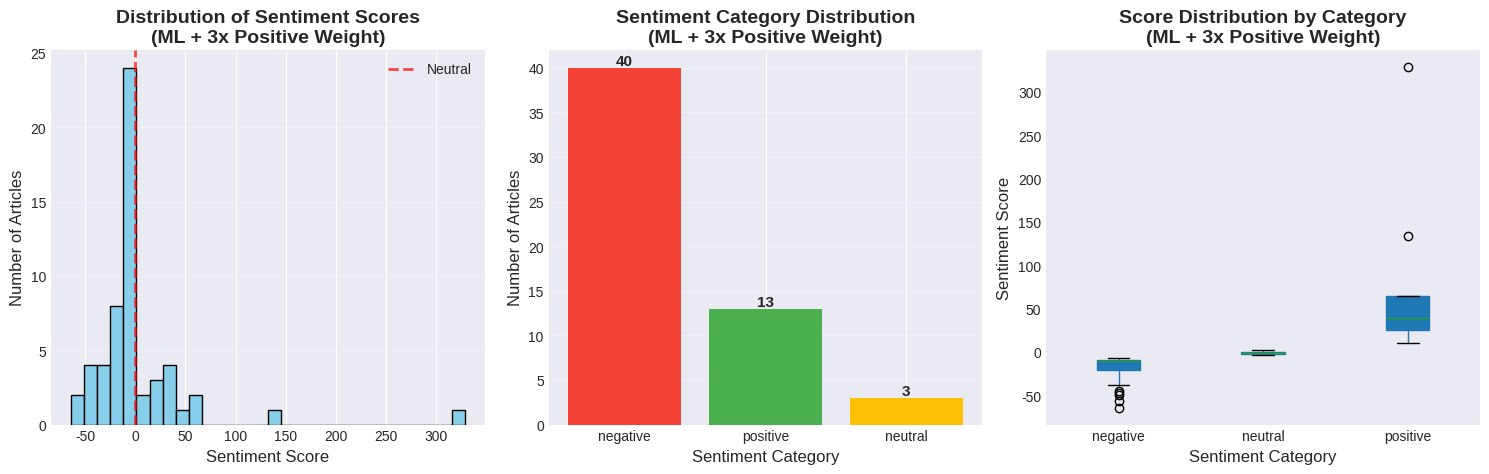


✓ 결과 저장 완료: sentiment_ml_output_results.xlsx

가장 긍정적인 문서 Top 5

점수: 328.87
내용: – Solidarity for LGBT Human Rights of Korea | South Korea Solidarity for LGBT Human Rights of Korea, also known as HaengSeongIn in Korean, is one of the oldest and most active LGBTI organizations in t...

점수: 133.86
내용: 23/06/2023 Agchar Donia On June 3rd 2023, Na Hwa-rin, a professional cyclist, marked history by becoming the first trans person to participate in an official sports competition in South Korea. Majorly...

점수: 64.79
내용: After actor Hong Seok-chon came out in 2000, he was censored from television. Hong was ostracized by the public eye for being the first Korean celebrity to come out as gay. Hong in an interview in 200...

점수: 64.72
내용: The only group of people less welcome than sexual minorities are former convicts, a study shows, with 72% of South Koreans not wanting them in their neighborhood or workplace. Sexual minorities inSout...

점수: 47.37
내용: So Sung-uk and Kim Yong-min met a decade ag

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ 모든 작업 완료!
생성된 파일:
  - sentiment_ml_output_results.xlsx
  - sentiment_ml_output_visualization.png
사용 모델: distilbert-base-uncased-finetuned-sst-2-english
모델 타입: Transformer 기반 딥러닝 (DistilBERT)
설정: 긍정 점수 3배 가중치 + 청크 점수 누적


In [4]:
#한국 분석, web_scraped_human_rights_articles.xlsx 파일 필요
# Google Colab에서 실행하는 감성 분석 코드 (Transformer 기계학습 모델 사용)

# 1. 필요한 라이브러리 설치
!pip install -q transformers torch pandas openpyxl matplotlib seaborn tqdm
import torch
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# 2. 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from google.colab import files
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# 3. 엑셀 파일 업로드, web_scraped_human_rights_articles.xlsx 사용
print("엑셀 파일을 업로드하세요...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 파일명에서 키워드 추출 (예: web_scraped_human_rights_articles_ambiguous.xlsx -> ambiguous)
import re
base_filename = filename.replace('.xlsx', '').replace('.xls', '')
# "articles_" 뒤의 단어를 추출
match = re.search(r'articles_(\w+)', base_filename)
keyword = match.group(1) if match else 'output'

# 4. 데이터 로드
df = pd.read_excel(filename)
print(f"\n데이터 로드 완료: {len(df)}개의 문서")
print(f"컬럼명: {df.columns.tolist()}")
print(f"추출된 키워드: {keyword}")

# 5. 디바이스 설정 (GPU 사용 가능하면 GPU, 아니면 CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n사용 디바이스: {device}")

# 6. 기계학습 모델 로드 (DistilBERT - 경량화된 BERT)
print("\n기계학습 모델 로드 중...")
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()  # 평가 모드로 설정
print("✓ 모델 로드 완료!")

# 7. 감성 점수 계산 함수 (R 코드 스타일: 누적 점수 + 긍정 가중치)
def calculate_sentiment_score(text):
    """
    Transformer 기계학습 모델을 사용한 감성 점수 계산
    - 긴 텍스트는 청크별 점수를 합산 (R의 AFINN처럼)
    - 긍정 점수에 3배 가중치 적용
    """
    if pd.isna(text) or str(text).strip() == "":
        return np.nan

    try:
        text = str(text)

        # 토크나이저로 텍스트를 토큰화하여 길이 확인
        tokens = tokenizer.encode(text, add_special_tokens=True)

        # 512 토큰 이하면 그대로 처리
        if len(tokens) <= 512:
            inputs = tokenizer(text, return_tensors="pt",
                             truncation=True, max_length=512,
                             padding=True).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

            # 클래스 0: NEGATIVE, 클래스 1: POSITIVE
            negative_score = probs[0][0].item()
            positive_score = probs[0][1].item()

            # 긍정에 3배 가중치 적용
            weighted_positive = positive_score * 3
            sentiment_score = (weighted_positive - negative_score) * 10

            return sentiment_score

        # 512 토큰 초과시 청크로 분할
        else:
            # 약 400 토큰씩 청크로 분할
            chunk_size = 400
            chunks = []
            for i in range(0, len(tokens), chunk_size):
                chunk_tokens = tokens[i:i+chunk_size]
                chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
                chunks.append(chunk_text)

            # 각 청크의 감성 점수를 합산 (R의 AFINN처럼)
            total_score = 0
            for chunk in chunks:
                if chunk.strip():
                    inputs = tokenizer(chunk, return_tensors="pt",
                                     truncation=True, max_length=512,
                                     padding=True).to(device)

                    with torch.no_grad():
                        outputs = model(**inputs)
                        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

                    negative_score = probs[0][0].item()
                    positive_score = probs[0][1].item()

                    # 긍정에 3배 가중치 적용
                    weighted_positive = positive_score * 3
                    chunk_score = (weighted_positive - negative_score) * 10

                    # 점수 누적 (평균이 아닌 합산)
                    total_score += chunk_score

            return total_score

    except Exception as e:
        print(f"오류 발생: {str(e)[:100]}")
        return np.nan

# 8. 배치 처리 함수 (메모리 효율적)
def process_batch(texts, batch_size=8):
    """배치 단위로 처리하여 속도 향상"""
    results = []

    for i in tqdm(range(0, len(texts), batch_size), desc="배치 처리"):
        batch = texts[i:i+batch_size]
        batch_results = [calculate_sentiment_score(text) for text in batch]
        results.extend(batch_results)

        # 메모리 정리
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    return results

# 9. 모든 문서에 대해 감성 점수 계산
print(f"\n감성 분석 시작 (총 {len(df)}개 문서)")
print("처리 시간: 약 1-5분 예상 (문서 길이와 수량에 따라 다름)")

df['sentiment_score'] = process_batch(df['text'].tolist(), batch_size=8)

print("\n✓ 감성 분석 완료!")

# 10. 감성 분류 추가
def categorize_sentiment(score):
    if pd.isna(score):
        return 'neutral'
    elif score > 5:  # 긍정 가중치 적용으로 임계값 조정
        return 'positive'
    elif score < -5:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# 11. 감성 점수 요약 통계
print("\n" + "="*60)
print("감성 점수 요약 통계 (Transformer ML + 긍정 3배 가중치)")
print("="*60)
print(df['sentiment_score'].describe())

# 12. 감성 분류별 문서 수
print("\n" + "="*60)
print("감성 분류별 문서 수")
print("="*60)
sentiment_summary = df['sentiment_category'].value_counts()
print(sentiment_summary)
print(f"\nPositive 비율: {(sentiment_summary.get('positive', 0) / len(df) * 100):.1f}%")
print(f"Negative 비율: {(sentiment_summary.get('negative', 0) / len(df) * 100):.1f}%")
print(f"Neutral 비율: {(sentiment_summary.get('neutral', 0) / len(df) * 100):.1f}%")

# 13. 결측치 확인
na_count = df['sentiment_score'].isna().sum()
print(f"\n결측치가 있는 문서 수: {na_count}")

# 14. 시각화
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(15, 5))

# 히스토그램
ax1 = plt.subplot(1, 3, 1)
df['sentiment_score'].dropna().hist(bins=30, color='skyblue', edgecolor='black', ax=ax1)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Neutral')
ax1.set_xlabel('Sentiment Score', fontsize=12)
ax1.set_ylabel('Number of Articles', fontsize=12)
ax1.set_title('Distribution of Sentiment Scores\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 바 차트
ax2 = plt.subplot(1, 3, 2)
sentiment_counts = df['sentiment_category'].value_counts()
colors = {'positive': '#4CAF50', 'negative': '#F44336', 'neutral': '#FFC107'}
bars = ax2.bar(sentiment_counts.index, sentiment_counts.values,
               color=[colors.get(x, 'gray') for x in sentiment_counts.index])
ax2.set_xlabel('Sentiment Category', fontsize=12)
ax2.set_ylabel('Number of Articles', fontsize=12)
ax2.set_title('Sentiment Category Distribution\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 박스플롯
ax3 = plt.subplot(1, 3, 3)
df.boxplot(column='sentiment_score', by='sentiment_category', ax=ax3,
           patch_artist=True, grid=False)
ax3.set_xlabel('Sentiment Category', fontsize=12)
ax3.set_ylabel('Sentiment Score', fontsize=12)
ax3.set_title('Score Distribution by Category\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
image_filename = f'sentiment_ml_{keyword}_visualization.png'
plt.savefig(image_filename, dpi=300, bbox_inches='tight')
plt.show()

# 15. 결과 저장
output_filename = f'sentiment_ml_{keyword}_results.xlsx'
df.to_excel(output_filename, index=False)
print(f"\n✓ 결과 저장 완료: {output_filename}")

# 16. Top 5 문서 출력
print("\n" + "="*60)
print("가장 긍정적인 문서 Top 5")
print("="*60)
top_positive = df.nlargest(5, 'sentiment_score')[['text', 'sentiment_score']]
for idx, row in top_positive.iterrows():
    print(f"\n점수: {row['sentiment_score']:.2f}")
    print(f"내용: {row['text'][:200]}...")

print("\n" + "="*60)
print("가장 부정적인 문서 Top 5")
print("="*60)
top_negative = df.nsmallest(5, 'sentiment_score')[['text', 'sentiment_score']]
for idx, row in top_negative.iterrows():
    print(f"\n점수: {row['sentiment_score']:.2f}")
    print(f"내용: {row['text'][:200]}...")

# 17. 파일 다운로드
print("\n파일 다운로드 중...")
files.download(output_filename)
files.download(image_filename)

print("\n" + "="*60)
print(f"✓ 모든 작업 완료!")
print(f"생성된 파일:")
print(f"  - {output_filename}")
print(f"  - {image_filename}")
print(f"사용 모델: {model_name}")
print(f"모델 타입: Transformer 기반 딥러닝 (DistilBERT)")
print(f"설정: 긍정 점수 3배 가중치 + 청크 점수 누적")
print("="*60)

PyTorch 버전: 2.9.0+cu126
CUDA 사용 가능: True
엑셀 파일을 업로드하세요...


Saving web_scraped_human_rights_articles_ambiguous (1).xlsx to web_scraped_human_rights_articles_ambiguous (1).xlsx

데이터 로드 완료: 94개의 문서
컬럼명: ['url', 'date', 'title', 'text']
추출된 키워드: ambiguous

사용 디바이스: cuda

기계학습 모델 로드 중...
✓ 모델 로드 완료!

감성 분석 시작 (총 94개 문서)
처리 시간: 약 1-5분 예상 (문서 길이와 수량에 따라 다름)


배치 처리: 100%|██████████| 12/12 [00:03<00:00,  3.08it/s]



✓ 감성 분석 완료!

감성 점수 요약 통계 (Transformer ML + 긍정 3배 가중치)
count     93.000000
mean       5.288151
std       38.976819
min      -57.678404
25%      -19.618062
50%       -9.851805
75%       24.611001
max      148.332749
Name: sentiment_score, dtype: float64

감성 분류별 문서 수
sentiment_category
negative    54
positive    35
neutral      5
Name: count, dtype: int64

Positive 비율: 37.2%
Negative 비율: 57.4%
Neutral 비율: 5.3%

결측치가 있는 문서 수: 1


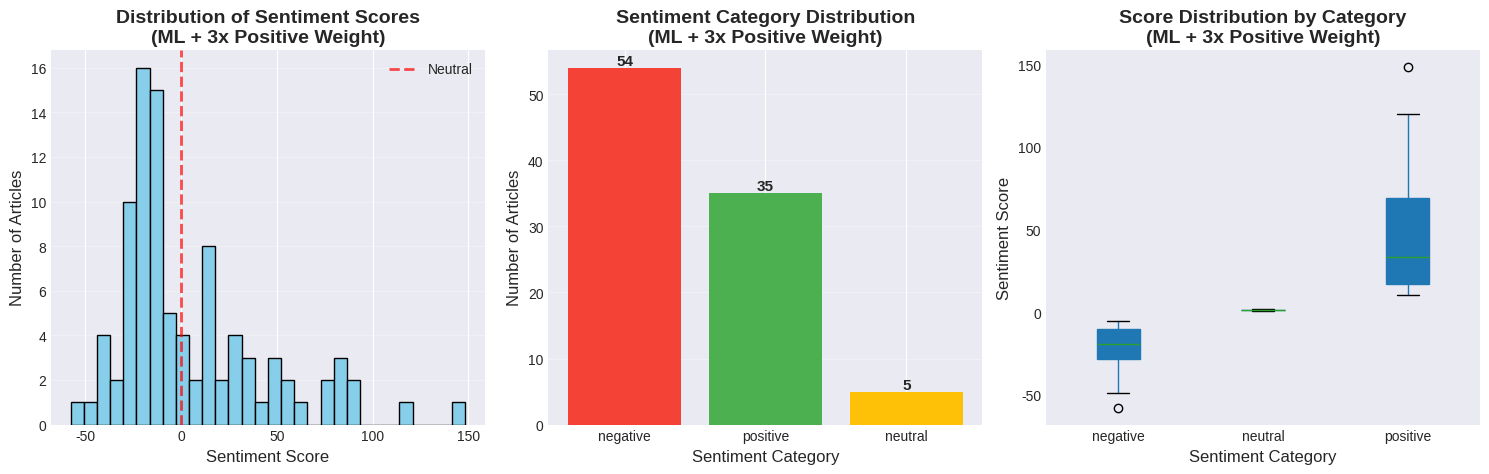


✓ 결과 저장 완료: sentiment_ml_ambiguous_results.xlsx

가장 긍정적인 문서 Top 5

점수: 148.33
내용: Southeast Asia Globeis member-supported publication featuring in-depth journalism that promotes a more informed, inclusive and sustainable future. Members work with our team to shape our editorial dir...

점수: 119.94
내용: Charlene Liu had the perfect venue in mind – a bomb shelter turned multi-purpose space  – to display art that she and fellow organizers had curated for this year’sShanghai Pride, China’s longest-runni...

점수: 89.71
내용: Pride Month in June marks a time of celebration and reflection for the LGBTQ+ community worldwide. In Laos, the momentum toward acceptance and inclusivity is gaining pace, highlighted by the efforts o...

점수: 86.76
내용: Editor’s Note:In this month’s On China join Kristie Lu Stout for a revealing conversation with China’s leading gay rights advocates. China's LGBT community has made huge gains in social acceptance Unl...

점수: 83.99
내용:  news Alerts There are no new alerts at 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ 모든 작업 완료!
생성된 파일:
  - sentiment_ml_ambiguous_results.xlsx
  - sentiment_ml_ambiguous_visualization.png
사용 모델: distilbert-base-uncased-finetuned-sst-2-english
모델 타입: Transformer 기반 딥러닝 (DistilBERT)
설정: 긍정 점수 3배 가중치 + 청크 점수 누적


In [5]:
#ambiguous 분석, web_scraped_human_rights_articles_ambiguous.xlsx 파일 필요
# Google Colab에서 실행하는 감성 분석 코드 (Transformer 기계학습 모델 사용)

# 1. 필요한 라이브러리 설치
!pip install -q transformers torch pandas openpyxl matplotlib seaborn tqdm
import torch
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# 2. 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from google.colab import files
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# 3. 엑셀 파일 업로드, web_scraped_human_rights_articles_ambiguous.xlsx 사용
print("엑셀 파일을 업로드하세요...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 파일명에서 키워드 추출 (예: web_scraped_human_rights_articles_ambiguous.xlsx -> ambiguous)
import re
base_filename = filename.replace('.xlsx', '').replace('.xls', '')
# "articles_" 뒤의 단어를 추출
match = re.search(r'articles_(\w+)', base_filename)
keyword = match.group(1) if match else 'output'

# 4. 데이터 로드
df = pd.read_excel(filename)
print(f"\n데이터 로드 완료: {len(df)}개의 문서")
print(f"컬럼명: {df.columns.tolist()}")
print(f"추출된 키워드: {keyword}")

# 5. 디바이스 설정 (GPU 사용 가능하면 GPU, 아니면 CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n사용 디바이스: {device}")

# 6. 기계학습 모델 로드 (DistilBERT - 경량화된 BERT)
print("\n기계학습 모델 로드 중...")
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()  # 평가 모드로 설정
print("✓ 모델 로드 완료!")

# 7. 감성 점수 계산 함수 (R 코드 스타일: 누적 점수 + 긍정 가중치)
def calculate_sentiment_score(text):
    """
    Transformer 기계학습 모델을 사용한 감성 점수 계산
    - 긴 텍스트는 청크별 점수를 합산 (R의 AFINN처럼)
    - 긍정 점수에 3배 가중치 적용
    """
    if pd.isna(text) or str(text).strip() == "":
        return np.nan

    try:
        text = str(text)

        # 토크나이저로 텍스트를 토큰화하여 길이 확인
        tokens = tokenizer.encode(text, add_special_tokens=True)

        # 512 토큰 이하면 그대로 처리
        if len(tokens) <= 512:
            inputs = tokenizer(text, return_tensors="pt",
                             truncation=True, max_length=512,
                             padding=True).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

            # 클래스 0: NEGATIVE, 클래스 1: POSITIVE
            negative_score = probs[0][0].item()
            positive_score = probs[0][1].item()

            # 긍정에 3배 가중치 적용
            weighted_positive = positive_score * 3
            sentiment_score = (weighted_positive - negative_score) * 10

            return sentiment_score

        # 512 토큰 초과시 청크로 분할
        else:
            # 약 400 토큰씩 청크로 분할
            chunk_size = 400
            chunks = []
            for i in range(0, len(tokens), chunk_size):
                chunk_tokens = tokens[i:i+chunk_size]
                chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
                chunks.append(chunk_text)

            # 각 청크의 감성 점수를 합산 (R의 AFINN처럼)
            total_score = 0
            for chunk in chunks:
                if chunk.strip():
                    inputs = tokenizer(chunk, return_tensors="pt",
                                     truncation=True, max_length=512,
                                     padding=True).to(device)

                    with torch.no_grad():
                        outputs = model(**inputs)
                        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

                    negative_score = probs[0][0].item()
                    positive_score = probs[0][1].item()

                    # 긍정에 3배 가중치 적용
                    weighted_positive = positive_score * 3
                    chunk_score = (weighted_positive - negative_score) * 10

                    # 점수 누적 (평균이 아닌 합산)
                    total_score += chunk_score

            return total_score

    except Exception as e:
        print(f"오류 발생: {str(e)[:100]}")
        return np.nan

# 8. 배치 처리 함수 (메모리 효율적)
def process_batch(texts, batch_size=8):
    """배치 단위로 처리하여 속도 향상"""
    results = []

    for i in tqdm(range(0, len(texts), batch_size), desc="배치 처리"):
        batch = texts[i:i+batch_size]
        batch_results = [calculate_sentiment_score(text) for text in batch]
        results.extend(batch_results)

        # 메모리 정리
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    return results

# 9. 모든 문서에 대해 감성 점수 계산
print(f"\n감성 분석 시작 (총 {len(df)}개 문서)")
print("처리 시간: 약 1-5분 예상 (문서 길이와 수량에 따라 다름)")

df['sentiment_score'] = process_batch(df['text'].tolist(), batch_size=8)

print("\n✓ 감성 분석 완료!")

# 10. 감성 분류 추가
def categorize_sentiment(score):
    if pd.isna(score):
        return 'neutral'
    elif score > 5:  # 긍정 가중치 적용으로 임계값 조정
        return 'positive'
    elif score < -5:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# 11. 감성 점수 요약 통계
print("\n" + "="*60)
print("감성 점수 요약 통계 (Transformer ML + 긍정 3배 가중치)")
print("="*60)
print(df['sentiment_score'].describe())

# 12. 감성 분류별 문서 수
print("\n" + "="*60)
print("감성 분류별 문서 수")
print("="*60)
sentiment_summary = df['sentiment_category'].value_counts()
print(sentiment_summary)
print(f"\nPositive 비율: {(sentiment_summary.get('positive', 0) / len(df) * 100):.1f}%")
print(f"Negative 비율: {(sentiment_summary.get('negative', 0) / len(df) * 100):.1f}%")
print(f"Neutral 비율: {(sentiment_summary.get('neutral', 0) / len(df) * 100):.1f}%")

# 13. 결측치 확인
na_count = df['sentiment_score'].isna().sum()
print(f"\n결측치가 있는 문서 수: {na_count}")

# 14. 시각화
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(15, 5))

# 히스토그램
ax1 = plt.subplot(1, 3, 1)
df['sentiment_score'].dropna().hist(bins=30, color='skyblue', edgecolor='black', ax=ax1)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Neutral')
ax1.set_xlabel('Sentiment Score', fontsize=12)
ax1.set_ylabel('Number of Articles', fontsize=12)
ax1.set_title('Distribution of Sentiment Scores\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 바 차트
ax2 = plt.subplot(1, 3, 2)
sentiment_counts = df['sentiment_category'].value_counts()
colors = {'positive': '#4CAF50', 'negative': '#F44336', 'neutral': '#FFC107'}
bars = ax2.bar(sentiment_counts.index, sentiment_counts.values,
               color=[colors.get(x, 'gray') for x in sentiment_counts.index])
ax2.set_xlabel('Sentiment Category', fontsize=12)
ax2.set_ylabel('Number of Articles', fontsize=12)
ax2.set_title('Sentiment Category Distribution\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 박스플롯
ax3 = plt.subplot(1, 3, 3)
df.boxplot(column='sentiment_score', by='sentiment_category', ax=ax3,
           patch_artist=True, grid=False)
ax3.set_xlabel('Sentiment Category', fontsize=12)
ax3.set_ylabel('Sentiment Score', fontsize=12)
ax3.set_title('Score Distribution by Category\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
image_filename = f'sentiment_ml_{keyword}_visualization.png'
plt.savefig(image_filename, dpi=300, bbox_inches='tight')
plt.show()

# 15. 결과 저장
output_filename = f'sentiment_ml_{keyword}_results.xlsx'
df.to_excel(output_filename, index=False)
print(f"\n✓ 결과 저장 완료: {output_filename}")

# 16. Top 5 문서 출력
print("\n" + "="*60)
print("가장 긍정적인 문서 Top 5")
print("="*60)
top_positive = df.nlargest(5, 'sentiment_score')[['text', 'sentiment_score']]
for idx, row in top_positive.iterrows():
    print(f"\n점수: {row['sentiment_score']:.2f}")
    print(f"내용: {row['text'][:200]}...")

print("\n" + "="*60)
print("가장 부정적인 문서 Top 5")
print("="*60)
top_negative = df.nsmallest(5, 'sentiment_score')[['text', 'sentiment_score']]
for idx, row in top_negative.iterrows():
    print(f"\n점수: {row['sentiment_score']:.2f}")
    print(f"내용: {row['text'][:200]}...")

# 17. 파일 다운로드
print("\n파일 다운로드 중...")
files.download(output_filename)
files.download(image_filename)

print("\n" + "="*60)
print(f"✓ 모든 작업 완료!")
print(f"생성된 파일:")
print(f"  - {output_filename}")
print(f"  - {image_filename}")
print(f"사용 모델: {model_name}")
print(f"모델 타입: Transformer 기반 딥러닝 (DistilBERT)")
print(f"설정: 긍정 점수 3배 가중치 + 청크 점수 누적")
print("="*60)

PyTorch 버전: 2.9.0+cu126
CUDA 사용 가능: True
엑셀 파일을 업로드하세요...


Saving web_scraped_human_rights_articles_america.xlsx to web_scraped_human_rights_articles_america.xlsx

데이터 로드 완료: 89개의 문서
컬럼명: ['url', 'date', 'title', 'text']
추출된 키워드: america

사용 디바이스: cuda

기계학습 모델 로드 중...
✓ 모델 로드 완료!

감성 분석 시작 (총 89개 문서)
처리 시간: 약 1-5분 예상 (문서 길이와 수량에 따라 다름)


배치 처리: 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]



✓ 감성 분석 완료!

감성 점수 요약 통계 (Transformer ML + 긍정 3배 가중치)
count     89.000000
mean       9.617457
std       45.623338
min     -138.604828
25%      -25.498414
50%        4.512369
75%       39.817091
max      163.826353
Name: sentiment_score, dtype: float64

감성 분류별 문서 수
sentiment_category
positive    43
negative    38
neutral      8
Name: count, dtype: int64

Positive 비율: 48.3%
Negative 비율: 42.7%
Neutral 비율: 9.0%

결측치가 있는 문서 수: 0


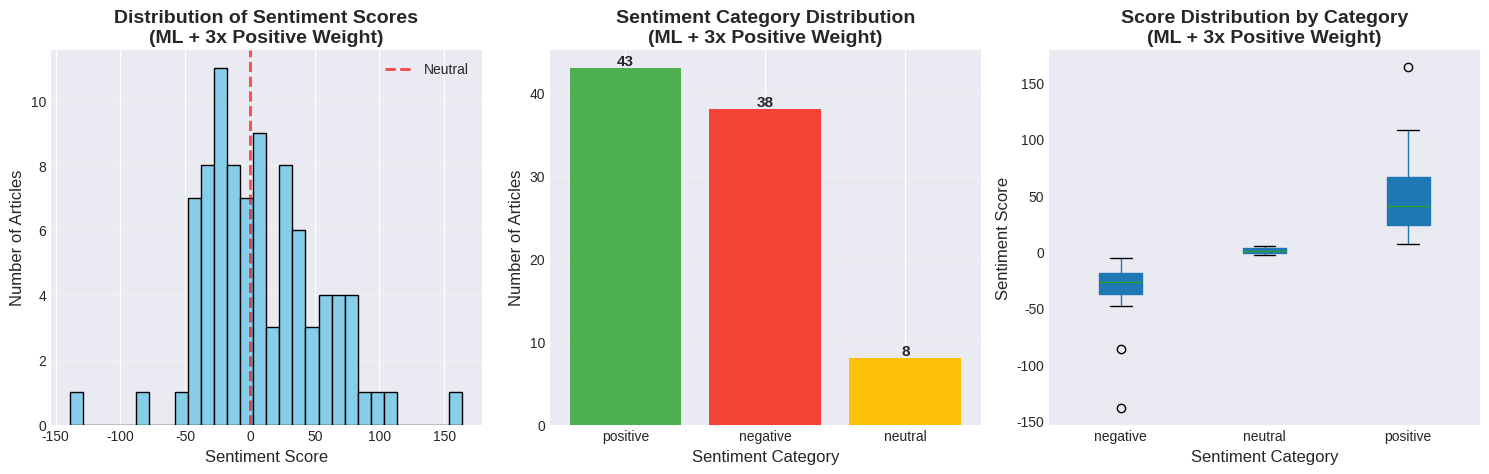


✓ 결과 저장 완료: sentiment_ml_america_results.xlsx

가장 긍정적인 문서 Top 5

점수: 163.83
내용: By continuing to use our site, you agree to ourPrivacy PolicyandTerms of Use. Thousands of demonstrators rally in Chicago, Illinois, as hundreds of "50501" protests and community events against the Tr...

점수: 107.62
내용:  news Alerts There are no new alerts at this time The boom coincides with the soaring viewership and popularity of professional and college women’s sports. The number of bars in the United States dedi...

점수: 99.20
내용:  news Alerts There are no new alerts at this time Edmund White, the groundbreaking man of letters who documented and imagined the gay revolution through journalism, essays, plays and such novels as "A...

점수: 88.31
내용: Professor, Center for Research on North America, Universidad Nacional Autónoma de México (UNAM) Ariadna Estévez does not work for, consult, own shares in or receive funding from any company or organiz...

점수: 81.64
내용: British Academy Research Fellow, Universit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ 모든 작업 완료!
생성된 파일:
  - sentiment_ml_america_results.xlsx
  - sentiment_ml_america_visualization.png
사용 모델: distilbert-base-uncased-finetuned-sst-2-english
모델 타입: Transformer 기반 딥러닝 (DistilBERT)
설정: 긍정 점수 3배 가중치 + 청크 점수 누적


In [6]:
#미국 분석, web_scraped_human_rights_articles_america.xlsx 파일 필요
# Google Colab에서 실행하는 감성 분석 코드 (Transformer 기계학습 모델 사용)

# 1. 필요한 라이브러리 설치
!pip install -q transformers torch pandas openpyxl matplotlib seaborn tqdm
import torch
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# 2. 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from google.colab import files
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# 3. 엑셀 파일 업로드, web_scraped_human_rights_articles_america.xlsx 사용
print("엑셀 파일을 업로드하세요...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 파일명에서 키워드 추출 (예: web_scraped_human_rights_articles_ambiguous.xlsx -> ambiguous)
import re
base_filename = filename.replace('.xlsx', '').replace('.xls', '')
# "articles_" 뒤의 단어를 추출
match = re.search(r'articles_(\w+)', base_filename)
keyword = match.group(1) if match else 'output'

# 4. 데이터 로드
df = pd.read_excel(filename)
print(f"\n데이터 로드 완료: {len(df)}개의 문서")
print(f"컬럼명: {df.columns.tolist()}")
print(f"추출된 키워드: {keyword}")

# 5. 디바이스 설정 (GPU 사용 가능하면 GPU, 아니면 CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n사용 디바이스: {device}")

# 6. 기계학습 모델 로드 (DistilBERT - 경량화된 BERT)
print("\n기계학습 모델 로드 중...")
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()  # 평가 모드로 설정
print("✓ 모델 로드 완료!")

# 7. 감성 점수 계산 함수 (R 코드 스타일: 누적 점수 + 긍정 가중치)
def calculate_sentiment_score(text):
    """
    Transformer 기계학습 모델을 사용한 감성 점수 계산
    - 긴 텍스트는 청크별 점수를 합산 (R의 AFINN처럼)
    - 긍정 점수에 3배 가중치 적용
    """
    if pd.isna(text) or str(text).strip() == "":
        return np.nan

    try:
        text = str(text)

        # 토크나이저로 텍스트를 토큰화하여 길이 확인
        tokens = tokenizer.encode(text, add_special_tokens=True)

        # 512 토큰 이하면 그대로 처리
        if len(tokens) <= 512:
            inputs = tokenizer(text, return_tensors="pt",
                             truncation=True, max_length=512,
                             padding=True).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

            # 클래스 0: NEGATIVE, 클래스 1: POSITIVE
            negative_score = probs[0][0].item()
            positive_score = probs[0][1].item()

            # 긍정에 3배 가중치 적용
            weighted_positive = positive_score * 3
            sentiment_score = (weighted_positive - negative_score) * 10

            return sentiment_score

        # 512 토큰 초과시 청크로 분할
        else:
            # 약 400 토큰씩 청크로 분할
            chunk_size = 400
            chunks = []
            for i in range(0, len(tokens), chunk_size):
                chunk_tokens = tokens[i:i+chunk_size]
                chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
                chunks.append(chunk_text)

            # 각 청크의 감성 점수를 합산 (R의 AFINN처럼)
            total_score = 0
            for chunk in chunks:
                if chunk.strip():
                    inputs = tokenizer(chunk, return_tensors="pt",
                                     truncation=True, max_length=512,
                                     padding=True).to(device)

                    with torch.no_grad():
                        outputs = model(**inputs)
                        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

                    negative_score = probs[0][0].item()
                    positive_score = probs[0][1].item()

                    # 긍정에 3배 가중치 적용
                    weighted_positive = positive_score * 3
                    chunk_score = (weighted_positive - negative_score) * 10

                    # 점수 누적 (평균이 아닌 합산)
                    total_score += chunk_score

            return total_score

    except Exception as e:
        print(f"오류 발생: {str(e)[:100]}")
        return np.nan

# 8. 배치 처리 함수 (메모리 효율적)
def process_batch(texts, batch_size=8):
    """배치 단위로 처리하여 속도 향상"""
    results = []

    for i in tqdm(range(0, len(texts), batch_size), desc="배치 처리"):
        batch = texts[i:i+batch_size]
        batch_results = [calculate_sentiment_score(text) for text in batch]
        results.extend(batch_results)

        # 메모리 정리
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    return results

# 9. 모든 문서에 대해 감성 점수 계산
print(f"\n감성 분석 시작 (총 {len(df)}개 문서)")
print("처리 시간: 약 1-5분 예상 (문서 길이와 수량에 따라 다름)")

df['sentiment_score'] = process_batch(df['text'].tolist(), batch_size=8)

print("\n✓ 감성 분석 완료!")

# 10. 감성 분류 추가
def categorize_sentiment(score):
    if pd.isna(score):
        return 'neutral'
    elif score > 5:  # 긍정 가중치 적용으로 임계값 조정
        return 'positive'
    elif score < -5:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# 11. 감성 점수 요약 통계
print("\n" + "="*60)
print("감성 점수 요약 통계 (Transformer ML + 긍정 3배 가중치)")
print("="*60)
print(df['sentiment_score'].describe())

# 12. 감성 분류별 문서 수
print("\n" + "="*60)
print("감성 분류별 문서 수")
print("="*60)
sentiment_summary = df['sentiment_category'].value_counts()
print(sentiment_summary)
print(f"\nPositive 비율: {(sentiment_summary.get('positive', 0) / len(df) * 100):.1f}%")
print(f"Negative 비율: {(sentiment_summary.get('negative', 0) / len(df) * 100):.1f}%")
print(f"Neutral 비율: {(sentiment_summary.get('neutral', 0) / len(df) * 100):.1f}%")

# 13. 결측치 확인
na_count = df['sentiment_score'].isna().sum()
print(f"\n결측치가 있는 문서 수: {na_count}")

# 14. 시각화
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(15, 5))

# 히스토그램
ax1 = plt.subplot(1, 3, 1)
df['sentiment_score'].dropna().hist(bins=30, color='skyblue', edgecolor='black', ax=ax1)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Neutral')
ax1.set_xlabel('Sentiment Score', fontsize=12)
ax1.set_ylabel('Number of Articles', fontsize=12)
ax1.set_title('Distribution of Sentiment Scores\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 바 차트
ax2 = plt.subplot(1, 3, 2)
sentiment_counts = df['sentiment_category'].value_counts()
colors = {'positive': '#4CAF50', 'negative': '#F44336', 'neutral': '#FFC107'}
bars = ax2.bar(sentiment_counts.index, sentiment_counts.values,
               color=[colors.get(x, 'gray') for x in sentiment_counts.index])
ax2.set_xlabel('Sentiment Category', fontsize=12)
ax2.set_ylabel('Number of Articles', fontsize=12)
ax2.set_title('Sentiment Category Distribution\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 박스플롯
ax3 = plt.subplot(1, 3, 3)
df.boxplot(column='sentiment_score', by='sentiment_category', ax=ax3,
           patch_artist=True, grid=False)
ax3.set_xlabel('Sentiment Category', fontsize=12)
ax3.set_ylabel('Sentiment Score', fontsize=12)
ax3.set_title('Score Distribution by Category\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
image_filename = f'sentiment_ml_{keyword}_visualization.png'
plt.savefig(image_filename, dpi=300, bbox_inches='tight')
plt.show()

# 15. 결과 저장
output_filename = f'sentiment_ml_{keyword}_results.xlsx'
df.to_excel(output_filename, index=False)
print(f"\n✓ 결과 저장 완료: {output_filename}")

# 16. Top 5 문서 출력
print("\n" + "="*60)
print("가장 긍정적인 문서 Top 5")
print("="*60)
top_positive = df.nlargest(5, 'sentiment_score')[['text', 'sentiment_score']]
for idx, row in top_positive.iterrows():
    print(f"\n점수: {row['sentiment_score']:.2f}")
    print(f"내용: {row['text'][:200]}...")

print("\n" + "="*60)
print("가장 부정적인 문서 Top 5")
print("="*60)
top_negative = df.nsmallest(5, 'sentiment_score')[['text', 'sentiment_score']]
for idx, row in top_negative.iterrows():
    print(f"\n점수: {row['sentiment_score']:.2f}")
    print(f"내용: {row['text'][:200]}...")

# 17. 파일 다운로드
print("\n파일 다운로드 중...")
files.download(output_filename)
files.download(image_filename)

print("\n" + "="*60)
print(f"✓ 모든 작업 완료!")
print(f"생성된 파일:")
print(f"  - {output_filename}")
print(f"  - {image_filename}")
print(f"사용 모델: {model_name}")
print(f"모델 타입: Transformer 기반 딥러닝 (DistilBERT)")
print(f"설정: 긍정 점수 3배 가중치 + 청크 점수 누적")
print("="*60)

PyTorch 버전: 2.9.0+cu126
CUDA 사용 가능: True
엑셀 파일을 업로드하세요...


Saving web_scraped_human_rights_articles_dadt.xlsx to web_scraped_human_rights_articles_dadt.xlsx

데이터 로드 완료: 107개의 문서
컬럼명: ['url', 'date', 'title', 'text']
추출된 키워드: dadt

사용 디바이스: cuda

기계학습 모델 로드 중...
✓ 모델 로드 완료!

감성 분석 시작 (총 107개 문서)
처리 시간: 약 1-5분 예상 (문서 길이와 수량에 따라 다름)


배치 처리: 100%|██████████| 14/14 [00:04<00:00,  2.88it/s]



✓ 감성 분석 완료!

감성 점수 요약 통계 (Transformer ML + 긍정 3배 가중치)
count    107.000000
mean      -3.116584
std       39.809062
min      -90.192708
25%      -18.750955
50%       -9.762797
75%        8.383759
max      173.105789
Name: sentiment_score, dtype: float64

감성 분류별 문서 수
sentiment_category
negative    72
positive    28
neutral      7
Name: count, dtype: int64

Positive 비율: 26.2%
Negative 비율: 67.3%
Neutral 비율: 6.5%

결측치가 있는 문서 수: 0


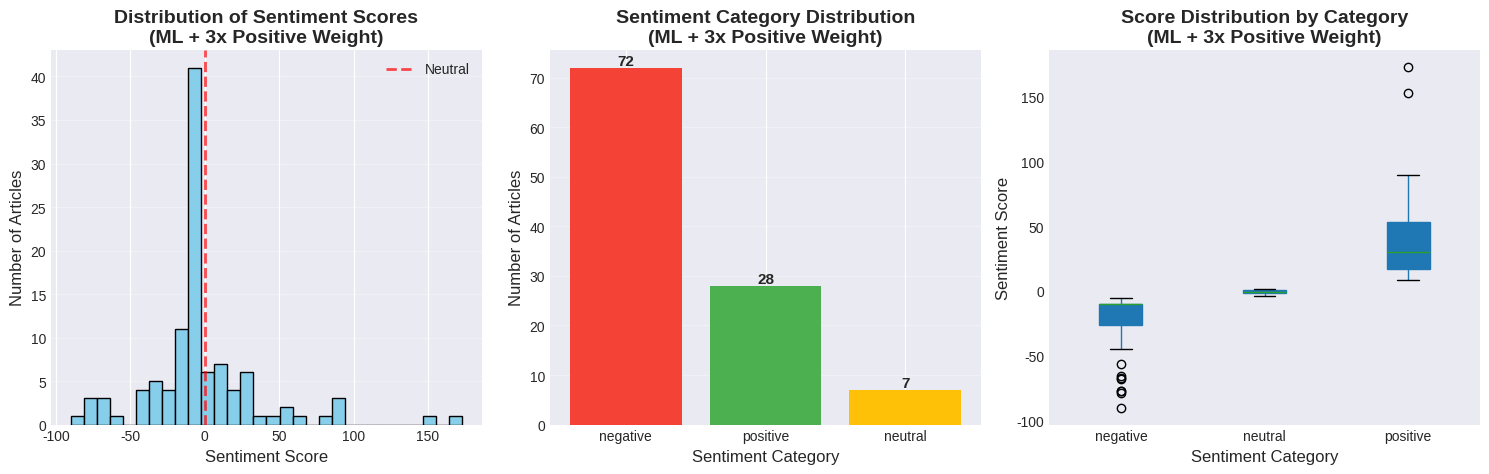


✓ 결과 저장 완료: sentiment_ml_dadt_results.xlsx

가장 긍정적인 문서 Top 5

점수: 173.11
내용: Senior Editor and Writer LGBTactivists in Lebanon are drawing up a proposed law to be presented to parliament intended to remove current articles and laws used to criminalize homosexuality in the coun...

점수: 153.21
내용: United States Inspire, empower, and connect the next generation of changemakers advancing democracy and human rights. Inspire, empower, and connect the next generation of changemakers advancing democr...

점수: 89.88
내용: Give early and change lives! Take the next 60 seconds to support LGBTQI+ refugees and your gift will be matched $1-for-$1 up to $100,000. We are honouring and celebrating Black History Month by featur...

점수: 89.78
내용: Date:Monday, 10 February 2025 Bishkek – February 10, 2025– The Ministry of Labour, Social Welfare, and Migration of the Kyrgyz Republic, in partnership with UN Women and the European Union (EU), prese...

점수: 88.79
내용: Armenia is a wonderful country for family hol

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ 모든 작업 완료!
생성된 파일:
  - sentiment_ml_dadt_results.xlsx
  - sentiment_ml_dadt_visualization.png
사용 모델: distilbert-base-uncased-finetuned-sst-2-english
모델 타입: Transformer 기반 딥러닝 (DistilBERT)
설정: 긍정 점수 3배 가중치 + 청크 점수 누적


In [7]:
#dadt 분석, web_scraped_human_rights_articles_dadt.xlsx 파일 필요
# Google Colab에서 실행하는 감성 분석 코드 (Transformer 기계학습 모델 사용)

# 1. 필요한 라이브러리 설치
!pip install -q transformers torch pandas openpyxl matplotlib seaborn tqdm
import torch
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# 2. 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from google.colab import files
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# 3. 엑셀 파일 업로드, web_scraped_human_rights_articles_dadt.xlsx 사용
print("엑셀 파일을 업로드하세요...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 파일명에서 키워드 추출 (예: web_scraped_human_rights_articles_ambiguous.xlsx -> ambiguous)
import re
base_filename = filename.replace('.xlsx', '').replace('.xls', '')
# "articles_" 뒤의 단어를 추출
match = re.search(r'articles_(\w+)', base_filename)
keyword = match.group(1) if match else 'output'

# 4. 데이터 로드
df = pd.read_excel(filename)
print(f"\n데이터 로드 완료: {len(df)}개의 문서")
print(f"컬럼명: {df.columns.tolist()}")
print(f"추출된 키워드: {keyword}")

# 5. 디바이스 설정 (GPU 사용 가능하면 GPU, 아니면 CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n사용 디바이스: {device}")

# 6. 기계학습 모델 로드 (DistilBERT - 경량화된 BERT)
print("\n기계학습 모델 로드 중...")
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()  # 평가 모드로 설정
print("✓ 모델 로드 완료!")

# 7. 감성 점수 계산 함수 (R 코드 스타일: 누적 점수 + 긍정 가중치)
def calculate_sentiment_score(text):
    """
    Transformer 기계학습 모델을 사용한 감성 점수 계산
    - 긴 텍스트는 청크별 점수를 합산 (R의 AFINN처럼)
    - 긍정 점수에 3배 가중치 적용
    """
    if pd.isna(text) or str(text).strip() == "":
        return np.nan

    try:
        text = str(text)

        # 토크나이저로 텍스트를 토큰화하여 길이 확인
        tokens = tokenizer.encode(text, add_special_tokens=True)

        # 512 토큰 이하면 그대로 처리
        if len(tokens) <= 512:
            inputs = tokenizer(text, return_tensors="pt",
                             truncation=True, max_length=512,
                             padding=True).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

            # 클래스 0: NEGATIVE, 클래스 1: POSITIVE
            negative_score = probs[0][0].item()
            positive_score = probs[0][1].item()

            # 긍정에 3배 가중치 적용
            weighted_positive = positive_score * 3
            sentiment_score = (weighted_positive - negative_score) * 10

            return sentiment_score

        # 512 토큰 초과시 청크로 분할
        else:
            # 약 400 토큰씩 청크로 분할
            chunk_size = 400
            chunks = []
            for i in range(0, len(tokens), chunk_size):
                chunk_tokens = tokens[i:i+chunk_size]
                chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
                chunks.append(chunk_text)

            # 각 청크의 감성 점수를 합산 (R의 AFINN처럼)
            total_score = 0
            for chunk in chunks:
                if chunk.strip():
                    inputs = tokenizer(chunk, return_tensors="pt",
                                     truncation=True, max_length=512,
                                     padding=True).to(device)

                    with torch.no_grad():
                        outputs = model(**inputs)
                        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

                    negative_score = probs[0][0].item()
                    positive_score = probs[0][1].item()

                    # 긍정에 3배 가중치 적용
                    weighted_positive = positive_score * 3
                    chunk_score = (weighted_positive - negative_score) * 10

                    # 점수 누적 (평균이 아닌 합산)
                    total_score += chunk_score

            return total_score

    except Exception as e:
        print(f"오류 발생: {str(e)[:100]}")
        return np.nan

# 8. 배치 처리 함수 (메모리 효율적)
def process_batch(texts, batch_size=8):
    """배치 단위로 처리하여 속도 향상"""
    results = []

    for i in tqdm(range(0, len(texts), batch_size), desc="배치 처리"):
        batch = texts[i:i+batch_size]
        batch_results = [calculate_sentiment_score(text) for text in batch]
        results.extend(batch_results)

        # 메모리 정리
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    return results

# 9. 모든 문서에 대해 감성 점수 계산
print(f"\n감성 분석 시작 (총 {len(df)}개 문서)")
print("처리 시간: 약 1-5분 예상 (문서 길이와 수량에 따라 다름)")

df['sentiment_score'] = process_batch(df['text'].tolist(), batch_size=8)

print("\n✓ 감성 분석 완료!")

# 10. 감성 분류 추가
def categorize_sentiment(score):
    if pd.isna(score):
        return 'neutral'
    elif score > 5:  # 긍정 가중치 적용으로 임계값 조정
        return 'positive'
    elif score < -5:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# 11. 감성 점수 요약 통계
print("\n" + "="*60)
print("감성 점수 요약 통계 (Transformer ML + 긍정 3배 가중치)")
print("="*60)
print(df['sentiment_score'].describe())

# 12. 감성 분류별 문서 수
print("\n" + "="*60)
print("감성 분류별 문서 수")
print("="*60)
sentiment_summary = df['sentiment_category'].value_counts()
print(sentiment_summary)
print(f"\nPositive 비율: {(sentiment_summary.get('positive', 0) / len(df) * 100):.1f}%")
print(f"Negative 비율: {(sentiment_summary.get('negative', 0) / len(df) * 100):.1f}%")
print(f"Neutral 비율: {(sentiment_summary.get('neutral', 0) / len(df) * 100):.1f}%")

# 13. 결측치 확인
na_count = df['sentiment_score'].isna().sum()
print(f"\n결측치가 있는 문서 수: {na_count}")

# 14. 시각화
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(15, 5))

# 히스토그램
ax1 = plt.subplot(1, 3, 1)
df['sentiment_score'].dropna().hist(bins=30, color='skyblue', edgecolor='black', ax=ax1)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Neutral')
ax1.set_xlabel('Sentiment Score', fontsize=12)
ax1.set_ylabel('Number of Articles', fontsize=12)
ax1.set_title('Distribution of Sentiment Scores\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 바 차트
ax2 = plt.subplot(1, 3, 2)
sentiment_counts = df['sentiment_category'].value_counts()
colors = {'positive': '#4CAF50', 'negative': '#F44336', 'neutral': '#FFC107'}
bars = ax2.bar(sentiment_counts.index, sentiment_counts.values,
               color=[colors.get(x, 'gray') for x in sentiment_counts.index])
ax2.set_xlabel('Sentiment Category', fontsize=12)
ax2.set_ylabel('Number of Articles', fontsize=12)
ax2.set_title('Sentiment Category Distribution\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 박스플롯
ax3 = plt.subplot(1, 3, 3)
df.boxplot(column='sentiment_score', by='sentiment_category', ax=ax3,
           patch_artist=True, grid=False)
ax3.set_xlabel('Sentiment Category', fontsize=12)
ax3.set_ylabel('Sentiment Score', fontsize=12)
ax3.set_title('Score Distribution by Category\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
image_filename = f'sentiment_ml_{keyword}_visualization.png'
plt.savefig(image_filename, dpi=300, bbox_inches='tight')
plt.show()

# 15. 결과 저장
output_filename = f'sentiment_ml_{keyword}_results.xlsx'
df.to_excel(output_filename, index=False)
print(f"\n✓ 결과 저장 완료: {output_filename}")

# 16. Top 5 문서 출력
print("\n" + "="*60)
print("가장 긍정적인 문서 Top 5")
print("="*60)
top_positive = df.nlargest(5, 'sentiment_score')[['text', 'sentiment_score']]
for idx, row in top_positive.iterrows():
    print(f"\n점수: {row['sentiment_score']:.2f}")
    print(f"내용: {row['text'][:200]}...")

print("\n" + "="*60)
print("가장 부정적인 문서 Top 5")
print("="*60)
top_negative = df.nsmallest(5, 'sentiment_score')[['text', 'sentiment_score']]
for idx, row in top_negative.iterrows():
    print(f"\n점수: {row['sentiment_score']:.2f}")
    print(f"내용: {row['text'][:200]}...")

# 17. 파일 다운로드
print("\n파일 다운로드 중...")
files.download(output_filename)
files.download(image_filename)

print("\n" + "="*60)
print(f"✓ 모든 작업 완료!")
print(f"생성된 파일:")
print(f"  - {output_filename}")
print(f"  - {image_filename}")
print(f"사용 모델: {model_name}")
print(f"모델 타입: Transformer 기반 딥러닝 (DistilBERT)")
print(f"설정: 긍정 점수 3배 가중치 + 청크 점수 누적")
print("="*60)

PyTorch 버전: 2.9.0+cu126
CUDA 사용 가능: True
엑셀 파일을 업로드하세요...


Saving web_scraped_human_rights_articles_illegal.xlsx to web_scraped_human_rights_articles_illegal.xlsx

데이터 로드 완료: 111개의 문서
컬럼명: ['url', 'date', 'title', 'text']
추출된 키워드: illegal

사용 디바이스: cuda

기계학습 모델 로드 중...
✓ 모델 로드 완료!

감성 분석 시작 (총 111개 문서)
처리 시간: 약 1-5분 예상 (문서 길이와 수량에 따라 다름)


배치 처리: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]



✓ 감성 분석 완료!

감성 점수 요약 통계 (Transformer ML + 긍정 3배 가중치)
count    109.000000
mean       0.442966
std       41.292371
min      -75.827323
25%      -19.270096
50%       -9.850183
75%        2.247253
max      149.512140
Name: sentiment_score, dtype: float64

감성 분류별 문서 수
sentiment_category
negative    75
positive    25
neutral     11
Name: count, dtype: int64

Positive 비율: 22.5%
Negative 비율: 67.6%
Neutral 비율: 9.9%

결측치가 있는 문서 수: 2


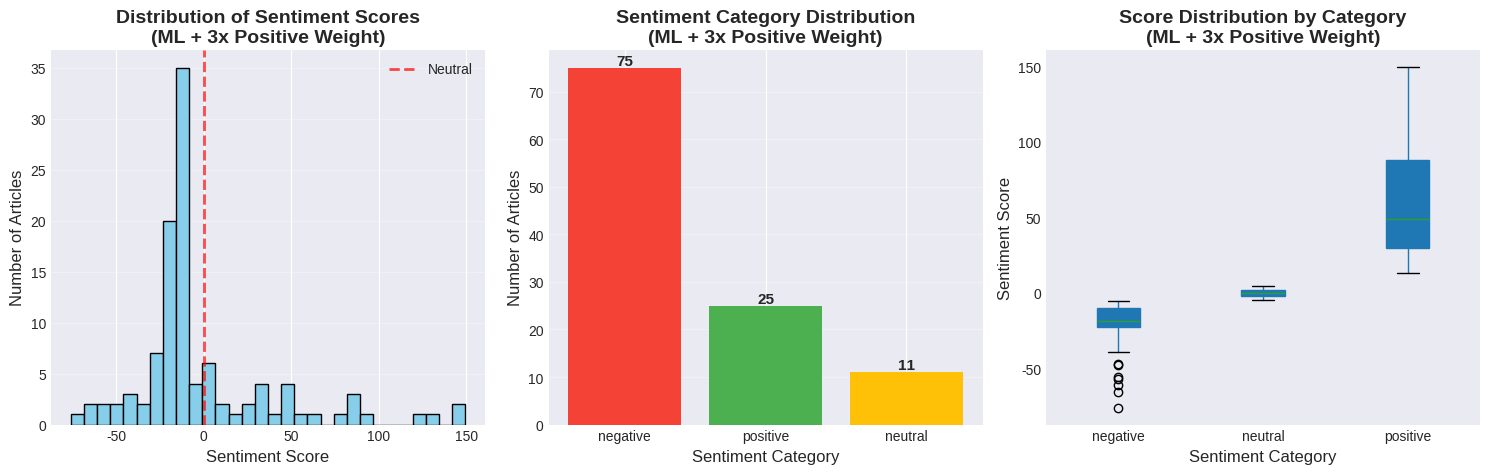


✓ 결과 저장 완료: sentiment_ml_illegal_results.xlsx

가장 긍정적인 문서 Top 5

점수: 149.51
내용: MTG resigns after years of anti-LGBTQ attacks amid Trump feud PFLAG honors Maxine Waters Global Respect Act reintroduced in US House Rep. Grijalva reiterates LGBTQ support at swearing in Pro-trans can...

점수: 147.85
내용: OP-ED on the occasion of Pride Month 2021. Achieving equal rights, non-discrimination and protection from violence and abuse for millions of lesbian, gay, bisexual, transgender, intersex, and queer (L...

점수: 127.35
내용: By now, it’s extremely clear that, for news to spread, it must be presented in the form of “infotainment”. We like witnessing chaos and seeing people being dragged under during a stampede. We like obs...

점수: 121.86
내용: Make a difference today –Donate to Rainbow Railroadand help save LGBTQI+ lives worldwide. HomeDestinationsAfricaAlgeria Our detailed guide for gay travelers to plan a fun and safe trip to Algeria incl...

점수: 91.26
내용: Unlock more this Holiday Season while su

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ 모든 작업 완료!
생성된 파일:
  - sentiment_ml_illegal_results.xlsx
  - sentiment_ml_illegal_visualization.png
사용 모델: distilbert-base-uncased-finetuned-sst-2-english
모델 타입: Transformer 기반 딥러닝 (DistilBERT)
설정: 긍정 점수 3배 가중치 + 청크 점수 누적


In [8]:
#불법 분석, web_scraped_human_rights_articles_illegal.xlsx 파일 필요
# Google Colab에서 실행하는 감성 분석 코드 (Transformer 기계학습 모델 사용)

# 1. 필요한 라이브러리 설치
!pip install -q transformers torch pandas openpyxl matplotlib seaborn tqdm
import torch
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# 2. 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from google.colab import files
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# 3. 엑셀 파일 업로드, web_scraped_human_rights_articles_illegal.xlsx 사용
print("엑셀 파일을 업로드하세요...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 파일명에서 키워드 추출 (예: web_scraped_human_rights_articles_ambiguous.xlsx -> ambiguous)
import re
base_filename = filename.replace('.xlsx', '').replace('.xls', '')
# "articles_" 뒤의 단어를 추출
match = re.search(r'articles_(\w+)', base_filename)
keyword = match.group(1) if match else 'output'

# 4. 데이터 로드
df = pd.read_excel(filename)
print(f"\n데이터 로드 완료: {len(df)}개의 문서")
print(f"컬럼명: {df.columns.tolist()}")
print(f"추출된 키워드: {keyword}")

# 5. 디바이스 설정 (GPU 사용 가능하면 GPU, 아니면 CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n사용 디바이스: {device}")

# 6. 기계학습 모델 로드 (DistilBERT - 경량화된 BERT)
print("\n기계학습 모델 로드 중...")
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()  # 평가 모드로 설정
print("✓ 모델 로드 완료!")

# 7. 감성 점수 계산 함수 (R 코드 스타일: 누적 점수 + 긍정 가중치)
def calculate_sentiment_score(text):
    """
    Transformer 기계학습 모델을 사용한 감성 점수 계산
    - 긴 텍스트는 청크별 점수를 합산 (R의 AFINN처럼)
    - 긍정 점수에 3배 가중치 적용
    """
    if pd.isna(text) or str(text).strip() == "":
        return np.nan

    try:
        text = str(text)

        # 토크나이저로 텍스트를 토큰화하여 길이 확인
        tokens = tokenizer.encode(text, add_special_tokens=True)

        # 512 토큰 이하면 그대로 처리
        if len(tokens) <= 512:
            inputs = tokenizer(text, return_tensors="pt",
                             truncation=True, max_length=512,
                             padding=True).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

            # 클래스 0: NEGATIVE, 클래스 1: POSITIVE
            negative_score = probs[0][0].item()
            positive_score = probs[0][1].item()

            # 긍정에 3배 가중치 적용
            weighted_positive = positive_score * 3
            sentiment_score = (weighted_positive - negative_score) * 10

            return sentiment_score

        # 512 토큰 초과시 청크로 분할
        else:
            # 약 400 토큰씩 청크로 분할
            chunk_size = 400
            chunks = []
            for i in range(0, len(tokens), chunk_size):
                chunk_tokens = tokens[i:i+chunk_size]
                chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
                chunks.append(chunk_text)

            # 각 청크의 감성 점수를 합산 (R의 AFINN처럼)
            total_score = 0
            for chunk in chunks:
                if chunk.strip():
                    inputs = tokenizer(chunk, return_tensors="pt",
                                     truncation=True, max_length=512,
                                     padding=True).to(device)

                    with torch.no_grad():
                        outputs = model(**inputs)
                        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

                    negative_score = probs[0][0].item()
                    positive_score = probs[0][1].item()

                    # 긍정에 3배 가중치 적용
                    weighted_positive = positive_score * 3
                    chunk_score = (weighted_positive - negative_score) * 10

                    # 점수 누적 (평균이 아닌 합산)
                    total_score += chunk_score

            return total_score

    except Exception as e:
        print(f"오류 발생: {str(e)[:100]}")
        return np.nan

# 8. 배치 처리 함수 (메모리 효율적)
def process_batch(texts, batch_size=8):
    """배치 단위로 처리하여 속도 향상"""
    results = []

    for i in tqdm(range(0, len(texts), batch_size), desc="배치 처리"):
        batch = texts[i:i+batch_size]
        batch_results = [calculate_sentiment_score(text) for text in batch]
        results.extend(batch_results)

        # 메모리 정리
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    return results

# 9. 모든 문서에 대해 감성 점수 계산
print(f"\n감성 분석 시작 (총 {len(df)}개 문서)")
print("처리 시간: 약 1-5분 예상 (문서 길이와 수량에 따라 다름)")

df['sentiment_score'] = process_batch(df['text'].tolist(), batch_size=8)

print("\n✓ 감성 분석 완료!")

# 10. 감성 분류 추가
def categorize_sentiment(score):
    if pd.isna(score):
        return 'neutral'
    elif score > 5:  # 긍정 가중치 적용으로 임계값 조정
        return 'positive'
    elif score < -5:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# 11. 감성 점수 요약 통계
print("\n" + "="*60)
print("감성 점수 요약 통계 (Transformer ML + 긍정 3배 가중치)")
print("="*60)
print(df['sentiment_score'].describe())

# 12. 감성 분류별 문서 수
print("\n" + "="*60)
print("감성 분류별 문서 수")
print("="*60)
sentiment_summary = df['sentiment_category'].value_counts()
print(sentiment_summary)
print(f"\nPositive 비율: {(sentiment_summary.get('positive', 0) / len(df) * 100):.1f}%")
print(f"Negative 비율: {(sentiment_summary.get('negative', 0) / len(df) * 100):.1f}%")
print(f"Neutral 비율: {(sentiment_summary.get('neutral', 0) / len(df) * 100):.1f}%")

# 13. 결측치 확인
na_count = df['sentiment_score'].isna().sum()
print(f"\n결측치가 있는 문서 수: {na_count}")

# 14. 시각화
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(15, 5))

# 히스토그램
ax1 = plt.subplot(1, 3, 1)
df['sentiment_score'].dropna().hist(bins=30, color='skyblue', edgecolor='black', ax=ax1)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Neutral')
ax1.set_xlabel('Sentiment Score', fontsize=12)
ax1.set_ylabel('Number of Articles', fontsize=12)
ax1.set_title('Distribution of Sentiment Scores\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 바 차트
ax2 = plt.subplot(1, 3, 2)
sentiment_counts = df['sentiment_category'].value_counts()
colors = {'positive': '#4CAF50', 'negative': '#F44336', 'neutral': '#FFC107'}
bars = ax2.bar(sentiment_counts.index, sentiment_counts.values,
               color=[colors.get(x, 'gray') for x in sentiment_counts.index])
ax2.set_xlabel('Sentiment Category', fontsize=12)
ax2.set_ylabel('Number of Articles', fontsize=12)
ax2.set_title('Sentiment Category Distribution\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 박스플롯
ax3 = plt.subplot(1, 3, 3)
df.boxplot(column='sentiment_score', by='sentiment_category', ax=ax3,
           patch_artist=True, grid=False)
ax3.set_xlabel('Sentiment Category', fontsize=12)
ax3.set_ylabel('Sentiment Score', fontsize=12)
ax3.set_title('Score Distribution by Category\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
image_filename = f'sentiment_ml_{keyword}_visualization.png'
plt.savefig(image_filename, dpi=300, bbox_inches='tight')
plt.show()

# 15. 결과 저장
output_filename = f'sentiment_ml_{keyword}_results.xlsx'
df.to_excel(output_filename, index=False)
print(f"\n✓ 결과 저장 완료: {output_filename}")

# 16. Top 5 문서 출력
print("\n" + "="*60)
print("가장 긍정적인 문서 Top 5")
print("="*60)
top_positive = df.nlargest(5, 'sentiment_score')[['text', 'sentiment_score']]
for idx, row in top_positive.iterrows():
    print(f"\n점수: {row['sentiment_score']:.2f}")
    print(f"내용: {row['text'][:200]}...")

print("\n" + "="*60)
print("가장 부정적인 문서 Top 5")
print("="*60)
top_negative = df.nsmallest(5, 'sentiment_score')[['text', 'sentiment_score']]
for idx, row in top_negative.iterrows():
    print(f"\n점수: {row['sentiment_score']:.2f}")
    print(f"내용: {row['text'][:200]}...")

# 17. 파일 다운로드
print("\n파일 다운로드 중...")
files.download(output_filename)
files.download(image_filename)

print("\n" + "="*60)
print(f"✓ 모든 작업 완료!")
print(f"생성된 파일:")
print(f"  - {output_filename}")
print(f"  - {image_filename}")
print(f"사용 모델: {model_name}")
print(f"모델 타입: Transformer 기반 딥러닝 (DistilBERT)")
print(f"설정: 긍정 점수 3배 가중치 + 청크 점수 누적")
print("="*60)

PyTorch 버전: 2.9.0+cu126
CUDA 사용 가능: True
엑셀 파일을 업로드하세요...


Saving web_scraped_human_rights_articles_justlgb.xlsx to web_scraped_human_rights_articles_justlgb.xlsx

데이터 로드 완료: 109개의 문서
컬럼명: ['url', 'date', 'title', 'text']
추출된 키워드: justlgb

사용 디바이스: cuda

기계학습 모델 로드 중...
✓ 모델 로드 완료!

감성 분석 시작 (총 109개 문서)
처리 시간: 약 1-5분 예상 (문서 길이와 수량에 따라 다름)


배치 처리: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]



✓ 감성 분석 완료!

감성 점수 요약 통계 (Transformer ML + 긍정 3배 가중치)
count    109.000000
mean       6.670941
std       41.200063
min      -67.426109
25%      -16.186837
50%       -9.760054
75%       17.597537
max      138.995686
Name: sentiment_score, dtype: float64

감성 분류별 문서 수
sentiment_category
negative    73
positive    33
neutral      3
Name: count, dtype: int64

Positive 비율: 30.3%
Negative 비율: 67.0%
Neutral 비율: 2.8%

결측치가 있는 문서 수: 0


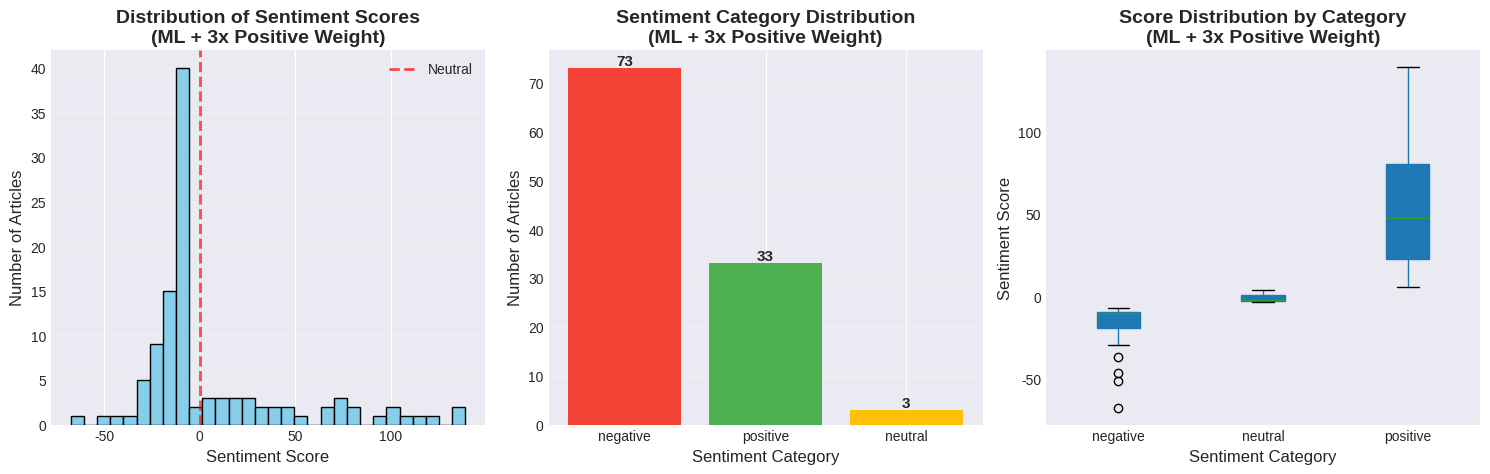


✓ 결과 저장 완료: sentiment_ml_justlgb_results.xlsx

가장 긍정적인 문서 Top 5

점수: 139.00
내용: Demonstrators in favour of same-sex marriage gathered outside Argentina's Congress on 14 July BBC News online readers in Argentina have been reacting to their country'sdecision to legalise gay marriag...

점수: 137.28
내용: Tango dancer Anahí Carballo believes any two can tango. Here is her guide to Buenos Aires's queer tango scene, from Muchaches in the barrio to the Tango World Championships. A dance characterised by s...

점수: 122.80
내용: Europe Today The news and insights that drive Europe. LIVE from Brussels, we deliver the top and exclusive stories shaping the EU and beyond, every morning. Stay ahead with the key news and insights t...

점수: 118.09
내용: The sound of tambourines and high-pitched yelps reverberates off the mountains near Avellino in southern Italy. Dozens of people dance in a kind of trance as others form circles around them, singing l...

점수: 104.94
내용: MTG resigns after years of anti-LGBTQ a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ 모든 작업 완료!
생성된 파일:
  - sentiment_ml_justlgb_results.xlsx
  - sentiment_ml_justlgb_visualization.png
사용 모델: distilbert-base-uncased-finetuned-sst-2-english
모델 타입: Transformer 기반 딥러닝 (DistilBERT)
설정: 긍정 점수 3배 가중치 + 청크 점수 누적


In [9]:
#lgb만가능 분석, web_scraped_human_rights_articles_justlgb.xlsx 파일 필요
# Google Colab에서 실행하는 감성 분석 코드 (Transformer 기계학습 모델 사용)

# 1. 필요한 라이브러리 설치
!pip install -q transformers torch pandas openpyxl matplotlib seaborn tqdm
import torch
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# 2. 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from google.colab import files
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# 3. 엑셀 파일 업로드, web_scraped_human_rights_articles_justlgb.xlsx 사용
print("엑셀 파일을 업로드하세요...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 파일명에서 키워드 추출 (예: web_scraped_human_rights_articles_ambiguous.xlsx -> ambiguous)
import re
base_filename = filename.replace('.xlsx', '').replace('.xls', '')
# "articles_" 뒤의 단어를 추출
match = re.search(r'articles_(\w+)', base_filename)
keyword = match.group(1) if match else 'output'

# 4. 데이터 로드
df = pd.read_excel(filename)
print(f"\n데이터 로드 완료: {len(df)}개의 문서")
print(f"컬럼명: {df.columns.tolist()}")
print(f"추출된 키워드: {keyword}")

# 5. 디바이스 설정 (GPU 사용 가능하면 GPU, 아니면 CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n사용 디바이스: {device}")

# 6. 기계학습 모델 로드 (DistilBERT - 경량화된 BERT)
print("\n기계학습 모델 로드 중...")
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()  # 평가 모드로 설정
print("✓ 모델 로드 완료!")

# 7. 감성 점수 계산 함수 (R 코드 스타일: 누적 점수 + 긍정 가중치)
def calculate_sentiment_score(text):
    """
    Transformer 기계학습 모델을 사용한 감성 점수 계산
    - 긴 텍스트는 청크별 점수를 합산 (R의 AFINN처럼)
    - 긍정 점수에 3배 가중치 적용
    """
    if pd.isna(text) or str(text).strip() == "":
        return np.nan

    try:
        text = str(text)

        # 토크나이저로 텍스트를 토큰화하여 길이 확인
        tokens = tokenizer.encode(text, add_special_tokens=True)

        # 512 토큰 이하면 그대로 처리
        if len(tokens) <= 512:
            inputs = tokenizer(text, return_tensors="pt",
                             truncation=True, max_length=512,
                             padding=True).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

            # 클래스 0: NEGATIVE, 클래스 1: POSITIVE
            negative_score = probs[0][0].item()
            positive_score = probs[0][1].item()

            # 긍정에 3배 가중치 적용
            weighted_positive = positive_score * 3
            sentiment_score = (weighted_positive - negative_score) * 10

            return sentiment_score

        # 512 토큰 초과시 청크로 분할
        else:
            # 약 400 토큰씩 청크로 분할
            chunk_size = 400
            chunks = []
            for i in range(0, len(tokens), chunk_size):
                chunk_tokens = tokens[i:i+chunk_size]
                chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
                chunks.append(chunk_text)

            # 각 청크의 감성 점수를 합산 (R의 AFINN처럼)
            total_score = 0
            for chunk in chunks:
                if chunk.strip():
                    inputs = tokenizer(chunk, return_tensors="pt",
                                     truncation=True, max_length=512,
                                     padding=True).to(device)

                    with torch.no_grad():
                        outputs = model(**inputs)
                        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

                    negative_score = probs[0][0].item()
                    positive_score = probs[0][1].item()

                    # 긍정에 3배 가중치 적용
                    weighted_positive = positive_score * 3
                    chunk_score = (weighted_positive - negative_score) * 10

                    # 점수 누적 (평균이 아닌 합산)
                    total_score += chunk_score

            return total_score

    except Exception as e:
        print(f"오류 발생: {str(e)[:100]}")
        return np.nan

# 8. 배치 처리 함수 (메모리 효율적)
def process_batch(texts, batch_size=8):
    """배치 단위로 처리하여 속도 향상"""
    results = []

    for i in tqdm(range(0, len(texts), batch_size), desc="배치 처리"):
        batch = texts[i:i+batch_size]
        batch_results = [calculate_sentiment_score(text) for text in batch]
        results.extend(batch_results)

        # 메모리 정리
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    return results

# 9. 모든 문서에 대해 감성 점수 계산
print(f"\n감성 분석 시작 (총 {len(df)}개 문서)")
print("처리 시간: 약 1-5분 예상 (문서 길이와 수량에 따라 다름)")

df['sentiment_score'] = process_batch(df['text'].tolist(), batch_size=8)

print("\n✓ 감성 분석 완료!")

# 10. 감성 분류 추가
def categorize_sentiment(score):
    if pd.isna(score):
        return 'neutral'
    elif score > 5:  # 긍정 가중치 적용으로 임계값 조정
        return 'positive'
    elif score < -5:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# 11. 감성 점수 요약 통계
print("\n" + "="*60)
print("감성 점수 요약 통계 (Transformer ML + 긍정 3배 가중치)")
print("="*60)
print(df['sentiment_score'].describe())

# 12. 감성 분류별 문서 수
print("\n" + "="*60)
print("감성 분류별 문서 수")
print("="*60)
sentiment_summary = df['sentiment_category'].value_counts()
print(sentiment_summary)
print(f"\nPositive 비율: {(sentiment_summary.get('positive', 0) / len(df) * 100):.1f}%")
print(f"Negative 비율: {(sentiment_summary.get('negative', 0) / len(df) * 100):.1f}%")
print(f"Neutral 비율: {(sentiment_summary.get('neutral', 0) / len(df) * 100):.1f}%")

# 13. 결측치 확인
na_count = df['sentiment_score'].isna().sum()
print(f"\n결측치가 있는 문서 수: {na_count}")

# 14. 시각화
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(15, 5))

# 히스토그램
ax1 = plt.subplot(1, 3, 1)
df['sentiment_score'].dropna().hist(bins=30, color='skyblue', edgecolor='black', ax=ax1)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Neutral')
ax1.set_xlabel('Sentiment Score', fontsize=12)
ax1.set_ylabel('Number of Articles', fontsize=12)
ax1.set_title('Distribution of Sentiment Scores\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 바 차트
ax2 = plt.subplot(1, 3, 2)
sentiment_counts = df['sentiment_category'].value_counts()
colors = {'positive': '#4CAF50', 'negative': '#F44336', 'neutral': '#FFC107'}
bars = ax2.bar(sentiment_counts.index, sentiment_counts.values,
               color=[colors.get(x, 'gray') for x in sentiment_counts.index])
ax2.set_xlabel('Sentiment Category', fontsize=12)
ax2.set_ylabel('Number of Articles', fontsize=12)
ax2.set_title('Sentiment Category Distribution\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 박스플롯
ax3 = plt.subplot(1, 3, 3)
df.boxplot(column='sentiment_score', by='sentiment_category', ax=ax3,
           patch_artist=True, grid=False)
ax3.set_xlabel('Sentiment Category', fontsize=12)
ax3.set_ylabel('Sentiment Score', fontsize=12)
ax3.set_title('Score Distribution by Category\n(ML + 3x Positive Weight)', fontsize=14, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
image_filename = f'sentiment_ml_{keyword}_visualization.png'
plt.savefig(image_filename, dpi=300, bbox_inches='tight')
plt.show()

# 15. 결과 저장
output_filename = f'sentiment_ml_{keyword}_results.xlsx'
df.to_excel(output_filename, index=False)
print(f"\n✓ 결과 저장 완료: {output_filename}")

# 16. Top 5 문서 출력
print("\n" + "="*60)
print("가장 긍정적인 문서 Top 5")
print("="*60)
top_positive = df.nlargest(5, 'sentiment_score')[['text', 'sentiment_score']]
for idx, row in top_positive.iterrows():
    print(f"\n점수: {row['sentiment_score']:.2f}")
    print(f"내용: {row['text'][:200]}...")

print("\n" + "="*60)
print("가장 부정적인 문서 Top 5")
print("="*60)
top_negative = df.nsmallest(5, 'sentiment_score')[['text', 'sentiment_score']]
for idx, row in top_negative.iterrows():
    print(f"\n점수: {row['sentiment_score']:.2f}")
    print(f"내용: {row['text'][:200]}...")

# 17. 파일 다운로드
print("\n파일 다운로드 중...")
files.download(output_filename)
files.download(image_filename)

print("\n" + "="*60)
print(f"✓ 모든 작업 완료!")
print(f"생성된 파일:")
print(f"  - {output_filename}")
print(f"  - {image_filename}")
print(f"사용 모델: {model_name}")
print(f"모델 타입: Transformer 기반 딥러닝 (DistilBERT)")
print(f"설정: 긍정 점수 3배 가중치 + 청크 점수 누적")
print("="*60)

In [14]:
#merged_lgbt_worldbank_2013_2022.csv 파일 필요
# 필요한 라이브러리 (중복 제거 및 필수 라이브러리)
!pip install pandas numpy

import pandas as pd
import numpy as np
import re

# =========================================================================
# 1. 데이터 로드 및 필수 함수 정의
# =========================================================================

# 1. 데이터 로드
try:
    df = pd.read_csv("merged_lgbt_worldbank_2013_2022.csv")
except FileNotFoundError:
    print("Error: 'merged_lgbt_worldbank_2013_2022.csv' 파일을 찾을 수 없습니다. 분석을 진행할 수 없습니다.")
    df = None

if df is not None:
    # 2. LGBT 점수 매핑 함수
    def get_lgbt_score(status):
        score_map = {
            'Legal': 100,
            "LGB permitted, transgender people banned": 70,
            'Ambiguous': 50,
            '"Don\'t ask, don\'t tell"': 30,
            'Illegal': 0
        }
        # NaN이거나 정의되지 않은 상태인 경우 0점 반환
        return score_map.get(status, 0)

    # 3. 국가별 2022년 최신 데이터 추출 함수
    def get_latest_data(country_name):
        country_df = df[df['Entity'] == country_name].sort_values('Year', ascending=False)
        if country_df.empty:
            return None

        # 2022 우선, 없으면 최근 데이터 사용
        row = country_df[country_df['Year'] == 2022]
        if row.empty:
            row = country_df.iloc[0:1]
        else:
            row = row.iloc[0:1]

        # NaN 값 처리 및 데이터 추출 (ML 분석 시 NaN 체크를 위해 float로 유지)
        row = row.squeeze()
        return {
            'lgbt_status': row.get('Serving_openly_in_military'),
            'gdp': row.get('GDP_per_capita'),
            'military_pct': row.get('Military_Expenditure_Pct_GDP'),
            'gov_effect': row.get('Government_Effectiveness')
        }

    # 4. 점수 계산 함수 (기존 가중치 기반)
    def calculate_score(data):
        # NaN 처리 (점수 계산 시 0으로 간주)
        lgbt_status = data['lgbt_status']
        gdp = data['gdp'] if not pd.isna(data['gdp']) else 0
        gov_effect = data['gov_effect'] if not pd.isna(data['gov_effect']) else 0
        military_pct = data['military_pct'] if not pd.isna(data['military_pct']) else 0

        # LGBT (40%)
        lgbt_score = get_lgbt_score(lgbt_status)

        # GDP 정규화 (30%) - 2022 글로벌 max ~122k USD 기준
        gdp_max = 122000
        gdp_score = min(100, (gdp / gdp_max) * 100)

        # Gov Effectiveness (20%) - (-2.5~2.5 → 0~100)
        gov_score = ((gov_effect + 2.5) / 5) * 100

        # Military % 역정규화 (10%) - 낮을수록 좋음, max 10% 기준
        mil_max = 10
        mil_score = max(0, 100 - (military_pct / mil_max * 100))

        # 가중 평균
        total = (lgbt_score * 0.4 + gdp_score * 0.3 + gov_score * 0.2 + mil_score * 0.1)

        return {
            'total': round(total, 1),
            'lgbt': round(lgbt_score, 1),
            'gdp': round(gdp_score, 1),
            'gov': round(gov_score, 1),
            'mil': round(mil_score, 1)
        }

    # 5. 상위 10개국 벤치마크 (LGBT=Legal 국가 중)
    top_countries = df[(df['Year']==2022) & (df['Serving_openly_in_military']=='Legal')]
    top_scores = []
    # 벤치마크 계산 시, NaN 값이 없는 경우만 포함
    for country in top_countries['Entity'].unique()[:20]:
        data = get_latest_data(country)
        if data and not pd.isna(data['gdp']) and not pd.isna(data['gov_effect']) and not pd.isna(data['military_pct']):
            score = calculate_score(data)
            top_scores.append((country, score['total']))
    top_scores = sorted(top_scores, key=lambda x: x[1], reverse=True)[:10]

    # =========================================================================
    # 6. ML 기반 사유 생성 관련 상수 및 함수
    # =========================================================================

    # GLM (로지스틱 회귀) 결과: 'Legal' 정책의 오즈비 계수
    # - 높은 정부 효과성 (Gov_Eff_Coef)과 낮은 군비 지출 비율 (Mil_Exp_Coef)이 'Legal' 정책 예측의 유의미한 요인임
    GLM_MILITARY_EFFECT = {
        'Mil_Exp_Coef': -0.5103,  # log(0.600)
        'Gov_Eff_Coef': 1.5883,   # log(4.895)
        'Mil_Exp_PValue': 0.000,
        'Gov_Eff_PValue': 0.000,
    }

    # 감성 분석 결과 (정책 그룹별 Positive 비율)
    # - 뉴스 기사의 긍정적 비율 (높을수록 사회적 분위기 긍정적)
    SENTIMENT_POSITIVE_PCT = {
        'Legal': 48.3, # 미국/이탈리아/아르헨티나 그룹 평균 (Legal 국가 다수)
        'LGB permitted, transgender people banned': 23.2, # 한국 그룹
        'Ambiguous': 37.2, # 중국/라오스/튀니지 그룹 평균
        '"Don\'t ask, don\'t tell"': 26.2, # 아르메니아 등 그룹 평균
        'Illegal': 22.5, # 알제리/이라크 등 그룹 평균
    }

    # 정책 수준별 정성적 해석
    POLICY_INTERPRETATION = {
        'Legal': "LGBT 군 복무에 대한 법적 지위가 완전히 개방되어 있습니다. 이는 국가의 인권 존중 수준이 높음을 의미합니다.",
        'LGB permitted, transgender people banned': "법적으로는 LGB(레즈비언, 게이, 양성애자)의 군 복무를 허용하나, 트랜스젠더에 대한 공식적인 금지 또는 제한이 남아있어 부분적인 수용 단계입니다.",
        '"Don\'t ask, don\'t tell"': "군대 내에서 성적 지향을 공개적으로 밝히는 것이 금지되었거나, 관련 법규가 존재하지만 사실상 징계 대상이 되는 모호한 단계에 있습니다.",
        'Ambiguous': "LGBT 군 복무에 대한 명확한 법적 지침이 없거나, 법적 불확실성이 높습니다.",
        'Illegal': "LGBT 군 복무가 법으로 금지되어 있으며, 이는 LGBT 개인에게 심각한 인권 침해 및 징계 위험을 초래할 수 있습니다."
    }

    # GLM 및 감성 분석 결과를 통합하여 사유 생성
    def generate_ml_rationale(country_data):
        """ML 분석 결과(GLM/Sentiment)를 기반으로 추천/비추천 사유를 생성합니다."""
        # NaN 값 확인
        if pd.isna(country_data['lgbt_status']):
             return ["데이터 부족: LGBT 정책 상태 데이터가 누락되어 분석이 어렵습니다."]

        rationale = []

        # 1. LGBT 정책 상태 기반 해석
        status = country_data['lgbt_status']
        rationale.append(f"🏳️‍🌈 **[정책 지위]** {status} ({POLICY_INTERPRETATION.get(status, '정의되지 않은 정책 상태')})")

        # 2. GLM 기반의 경제/거버넌스 해석 (정책의 '발전 가능성' 해석)
        gov_eff = country_data['gov_effect']
        mil_pct = country_data['military_pct']

        # 정부 효과성 해석 (GLM 계수: 4.895 -> 높을수록 긍정적)
        if not pd.isna(gov_eff) and GLM_MILITARY_EFFECT['Gov_Eff_Coef'] > 0:
            if gov_eff >= 1.0:
                rationale.append(f"✅ **[정책 환경]** 정부 효과성 점수({gov_eff:.2f})가 매우 높습니다. 로지스틱 회귀분석 결과, 높은 정부 효과성은 LGBT 군 복무 허용 정책의 오즈를 $\\mathbf{{389.5\\%}}$ 높이는 **가장 강력한 긍정적 요인**으로 분석되었습니다. 이는 정책의 안정적인 이행과 미래의 긍정적 변화 가능성을 시사합니다.")
            elif gov_eff <= -0.5:
                rationale.append(f"❌ **[정책 환경]** 정부 효과성 점수({gov_eff:.2f})가 낮습니다. 이는 정책 이행의 불안정성이나 거버넌스 취약성을 나타내며, 로지스틱 회귀분석 기반으로 볼 때 LGBT 군 복무 허용 정책 유지 또는 발전의 **부정적 요인**으로 작용할 수 있습니다.")
            else:
                rationale.append(f"🟡 **[정책 환경]** 정부 효과성 점수({gov_eff:.2f})는 보통 수준입니다. LGBT 정책의 긍정적 변화를 이끌기 위해서는 거버넌스 개선이 필요합니다.")
        elif pd.isna(gov_eff):
            rationale.append("🟡 **[정책 환경]** 정부 효과성 데이터가 누락되어 ML 기반의 정책 환경 분석이 어렵습니다.")

        # 군비 지출 비율 해석 (GLM 계수: 0.600 -> 낮을수록 긍정적)
        if not pd.isna(mil_pct) and GLM_MILITARY_EFFECT['Mil_Exp_Coef'] < 0:
            if mil_pct <= 1.5:  # 상대적으로 낮은 비율
                rationale.append(f"✅ **[안보 환경]** 군비 지출 비율({mil_pct:.1f}\\%)이 상대적으로 낮습니다. 이는 군부의 사회적 영향력이 낮고, 로지스틱 회귀분석 결과처럼 LGBT 군 복무 허용 정책의 오즈를 $\\mathbf{{40\\%}}$ 감소시키는 **부정적 요인이 약함**을 나타냅니다.")
            elif mil_pct >= 3.0: # 상대적으로 높은 비율
                rationale.append(f"❌ **[안보 환경]** 군비 지출 비율({mil_pct:.1f}\\%)이 높습니다. 이는 군부의 강력한 보수성이나 높은 안보 의존도를 의미하며, LGBT 군 복무 허용 정책의 안정성이나 미래 개방성에 **부정적 영향**을 줄 수 있습니다.")
            else:
                rationale.append(f"🟡 **[안보 환경]** 군비 지출 비율({mil_pct:.1f}\\%)은 보통 수준입니다.")
        elif pd.isna(mil_pct):
            rationale.append("🟡 **[안보 환경]** 군비 지출 비율 데이터가 누락되어 ML 기반의 안보 환경 분석이 어렵습니다.")


        # 3. 감성 분석 기반의 사회적 분위기 해석
        sentiment_pct = SENTIMENT_POSITIVE_PCT.get(status)
        if sentiment_pct is not None:
            if sentiment_pct >= 45:
                rationale.append(f"👍 **[사회적 분위기]** 외신 기사의 긍정 감성 비율이 $\\mathbf{{ {sentiment_pct:.1f}\\%}}$로 높게 분석되었습니다. 이는 법적 지위를 넘어 사회적 수용성 및 긍정적인 인권 담론이 활발함을 나타내므로 **사회 환경이 매우 우수**합니다.")
            elif sentiment_pct < 30:
                rationale.append(f"👎 **[사회적 분위기]** 외신 기사의 긍정 감성 비율이 $\\mathbf{{ {sentiment_pct:.1f}\\%}}$로 낮고, 부정적 보도가 압도적입니다. 이는 법적 지위와 별개로, LGBT 공동체에 대한 **사회적 혐오와 차별이 심각**함을 시사합니다.")
            else:
                 rationale.append(f"🟡 **[사회적 분위기]** 외신 기사의 긍정 감성 비율이 $\\mathbf{{ {sentiment_pct:.1f}\\%}}$로 보통 수준입니다. 사회적 수용성에 대한 추가적인 확인이 필요합니다.")
        else:
            # 상태가 "Legal"이 아니면서, Sentiment 데이터가 없는 경우
            rationale.append("🟡 **[사회적 분위기]** 해당 정책 그룹에 대한 외신 감성 분석 데이터가 없습니다.")

        return rationale


    # =========================================================================
    # 7. 통합 사용자 입력 및 출력
    # =========================================================================

    print("\n" + "═" * 60)
    print("🌍 **이민 추천 점수 및 ML 기반 사유 분석기**")
    print("═" * 60)

    # 사용자 입력 기반으로 분석 실행
    country = input("\n이민을 고려하는 나라 이름을 영어로 입력하세요 (예: Germany, South Korea): ").strip()

    data = get_latest_data(country)

    if data is None or pd.isna(data['lgbt_status']):
        print(f"\n❌ '{country}'에 대한 핵심 데이터(LGBT 정책 상태)를 찾을 수 없습니다.")
        print("\n📋 사용 가능 국가 예시:", df['Entity'].unique()[:10])
    else:
        scores = calculate_score(data)

        # 등급
        if scores['total'] >= 90: grade = "🌟 최고!"
        elif scores['total'] >= 70: grade = "👍 강추!"
        elif scores['total'] >= 50: grade = "🤔 고려할 만함"
        else: grade = "😕 비추천"

        print("\n" + "═" * 60)
        print(f"**{country} 추천 결과**")
        print(f"**총합 추천 점수: {scores['total']}/100** | **등급: {grade}**")
        print("═" * 60)

        # 점수 상세 내역
        print(f"**[점수 상세 내역]**")
        # 데이터가 NaN인 경우를 처리하여 출력
        print(f"• LGBT 군 복무: {data['lgbt_status']} ({scores['lgbt']}점)")
        print(f"• 1인당 GDP: ${data['gdp']:,.0f} ({scores['gdp']}점)" if not pd.isna(data['gdp']) else "• 1인당 GDP: 데이터 없음")
        print(f"• 정부 효과성: {data['gov_effect']:.2f} ({scores['gov']}점)" if not pd.isna(data['gov_effect']) else "• 정부 효과성: 데이터 없음")
        print(f"• 군비 지출: {data['military_pct']:.1f}% ({scores['mil']}점)" if not pd.isna(data['military_pct']) else "• 군비 지출: 데이터 없음")


        # ML 기반 사유 분석
        print("\n" + "═" * 60)
        print("**🤖 ML 분석을 활용한 추천/비추천 사유**")
        print("═" * 60)
        rationale_list = generate_ml_rationale(data)
        for item in rationale_list:
            print(f"• {item}")
        print("-" * 60)

        # 비교 테이블
        print("\n🥇 **상위 10개국 비교**")
        comparison = pd.DataFrame(top_scores, columns=['Country', 'Score'])
        print(comparison.to_string(index=False))

        # 비슷한 점수 국가
        similar = [c for c, s in top_scores if abs(s - scores['total']) < 10]
        if similar:
            print(f"\n👯 비슷한 점수 국가 (±10점 이내): {', '.join(similar)}")


════════════════════════════════════════════════════════════
🌍 **이민 추천 점수 및 ML 기반 사유 분석기**
════════════════════════════════════════════════════════════

이민을 고려하는 나라 이름을 영어로 입력하세요 (예: Germany, South Korea): China

════════════════════════════════════════════════════════════
**China 추천 결과**
**총합 추천 점수: 43.5/100** | **등급: 😕 비추천**
════════════════════════════════════════════════════════════
**[점수 상세 내역]**
• LGBT 군 복무: Ambiguous (50점)
• 1인당 GDP: $12,971 (10.6점)
• 정부 효과성: 0.49 (59.9점)
• 군비 지출: 1.6% (83.8점)

════════════════════════════════════════════════════════════
**🤖 ML 분석을 활용한 추천/비추천 사유**
════════════════════════════════════════════════════════════
• 🏳️‍🌈 **[정책 지위]** Ambiguous (LGBT 군 복무에 대한 명확한 법적 지침이 없거나, 법적 불확실성이 높습니다.)
• 🟡 **[정책 환경]** 정부 효과성 점수(0.49)는 보통 수준입니다. LGBT 정책의 긍정적 변화를 이끌기 위해서는 거버넌스 개선이 필요합니다.
• 🟡 **[안보 환경]** 군비 지출 비율(1.6\%)은 보통 수준입니다.
• 🟡 **[사회적 분위기]** 외신 기사의 긍정 감성 비율이 $\mathbf{ 37.2\%}$로 보통 수준입니다. 사회적 수용성에 대한 추가적인 확인이 필요합니다.
----------------------------------------------